In [1]:
# To reset all the variables on the memory
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Import relevant package(s)
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import random
from collections import deque
import matplotlib as mpl

%matplotlib inline

In [3]:
# Read data
data = pd.read_csv('hourly_pol_data_ex.csv', index_col=[0], parse_dates = [0])

In [4]:
# Print the head of the data to see how it looks
data.head()

positive  negative
timestamp                       
2014/5/16:17  0.166924 -0.323421
2014/5/16:18  0.156326 -0.337527
2014/5/16:19  0.160065 -0.350448
2014/5/16:20  0.159889 -0.359096
2014/5/16:21  0.160754 -0.348988

In [5]:
# Create new dataframe where each index is a datetime instead of string
# dataFr is the new dataframe
formattedIndex = []
for t in data.index:
    element = datetime.datetime.strptime(t,"%Y/%m/%d:%H") 
    formattedIndex.append(element)
dataFr = data.set_index(pd.Index(formattedIndex))
dataFr.rename(columns = {'positive':'pos', 'negative':'neg'}, inplace = True)
dataFr

pos       neg
2014-05-16 17:00:00  0.166924 -0.323421
2014-05-16 18:00:00  0.156326 -0.337527
2014-05-16 19:00:00  0.160065 -0.350448
2014-05-16 20:00:00  0.159889 -0.359096
2014-05-16 21:00:00  0.160754 -0.348988
...                       ...       ...
2015-01-01 00:00:00  0.171641 -0.337959
2015-01-01 01:00:00  0.174609 -0.347718
2015-01-01 02:00:00  0.165537 -0.348260
2015-01-01 03:00:00  0.174688 -0.307910
2015-01-01 04:00:00  0.175032 -0.333467

[5347 rows x 2 columns]

Mean: 0.15934208692537866
Median: 0.158017043


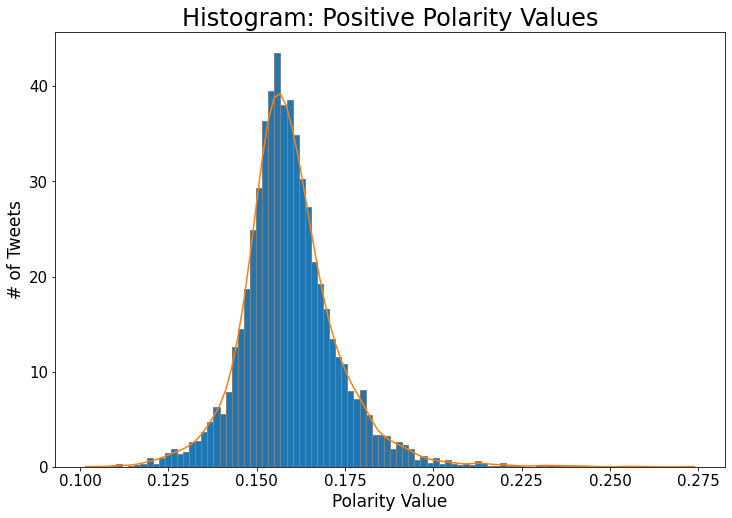

In [6]:
# Print the histogram of positive polarity values
density = stats.gaussian_kde(dataFr['pos'])
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(dataFr['pos'], 100, density=True, edgecolor='gray')
plt.plot(bins, density(bins))
plt.title('Histogram: Positive Polarity Values', fontsize=24)
plt.xlabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel('# of Tweets', fontsize=17)
plt.yticks(fontsize=15)

print('Mean:', dataFr['pos'].mean())
print('Median:', dataFr['pos'].median())

Mean: -0.3427210877237698
Median: -0.342882594


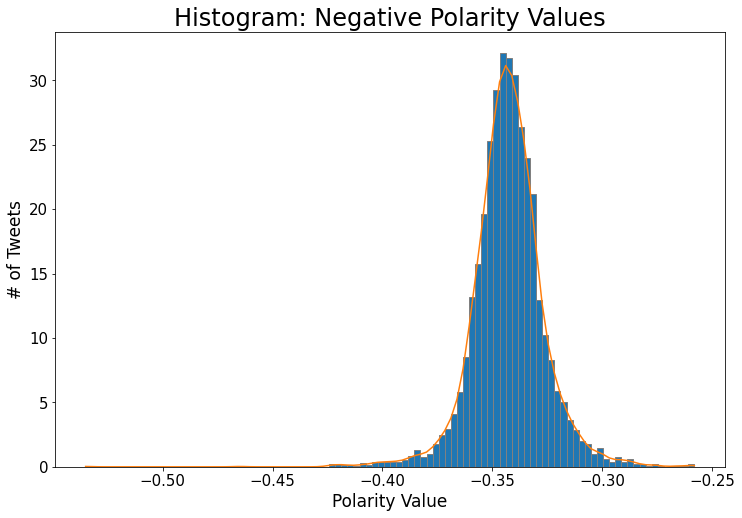

In [7]:
# Print the histogram of negative polarity values
density = stats.gaussian_kde(dataFr['neg'])
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(dataFr['neg'], 100, density=True, edgecolor='gray')
plt.plot(bins, density(bins))
plt.title('Histogram: Negative Polarity Values', fontsize=24)
plt.xlabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel('# of Tweets', fontsize=17)
plt.yticks(fontsize=15)


print('Mean:', dataFr['neg'].mean())
print('Median:', dataFr['neg'].median())

(array([0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 , 0.275,
        0.3  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

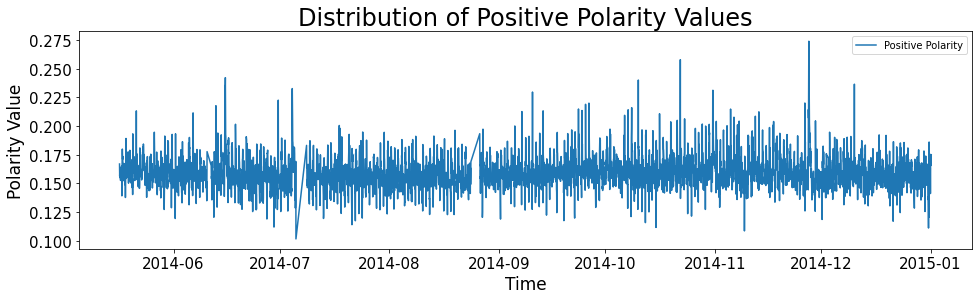

In [8]:
# Distribution of positive polarity over time
plt.figure(figsize=(16,4))
plt.plot(dataFr['pos'], label = "Positive Polarity")
plt.legend(loc='best')
plt.title('Distribution of Positive Polarity Values', fontsize=24)
plt.xlabel('Time', fontsize=17)
plt.ylabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


(array([0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 , 0.275,
        0.3  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

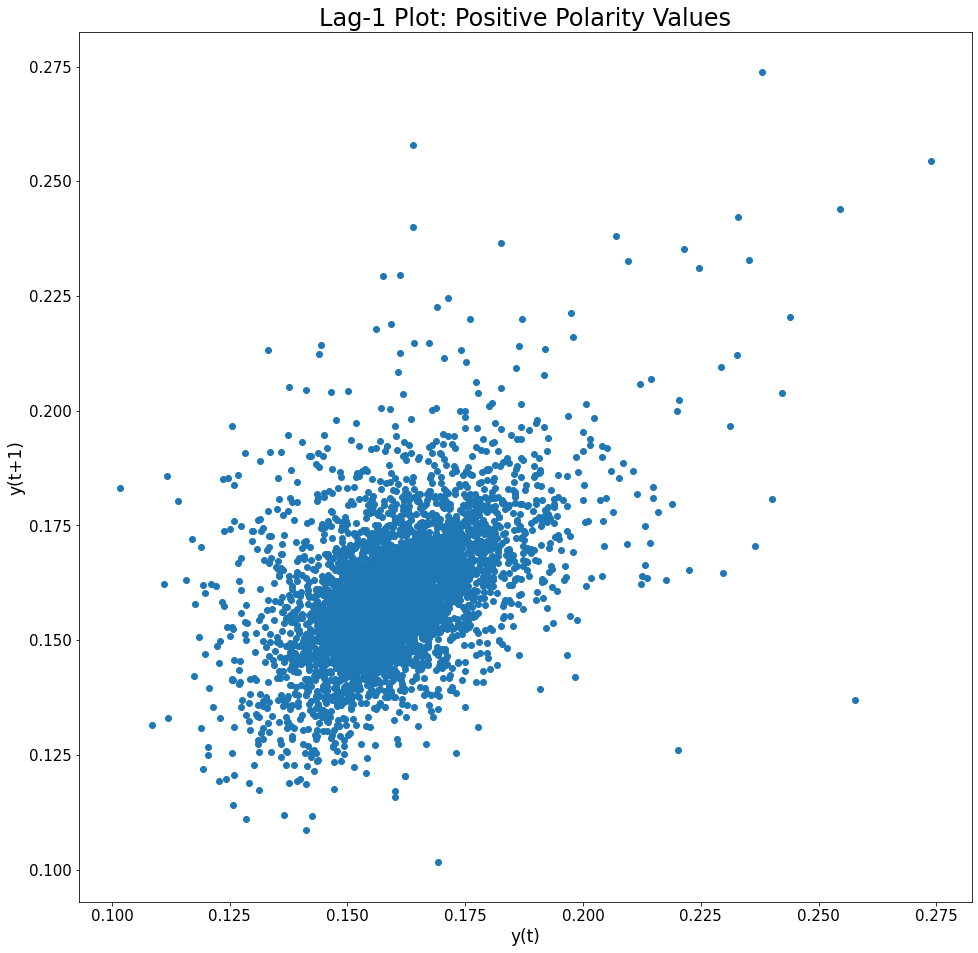

In [9]:
# TEMP LAG PLOT
plt.figure(figsize=(16,16))
pd.plotting.lag_plot(dataFr['pos'], lag= 1)
plt.title('Lag-1 Plot: Positive Polarity Values', fontsize=24)
plt.xlabel('y(t)', fontsize=17)
plt.ylabel('y(t+1)', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

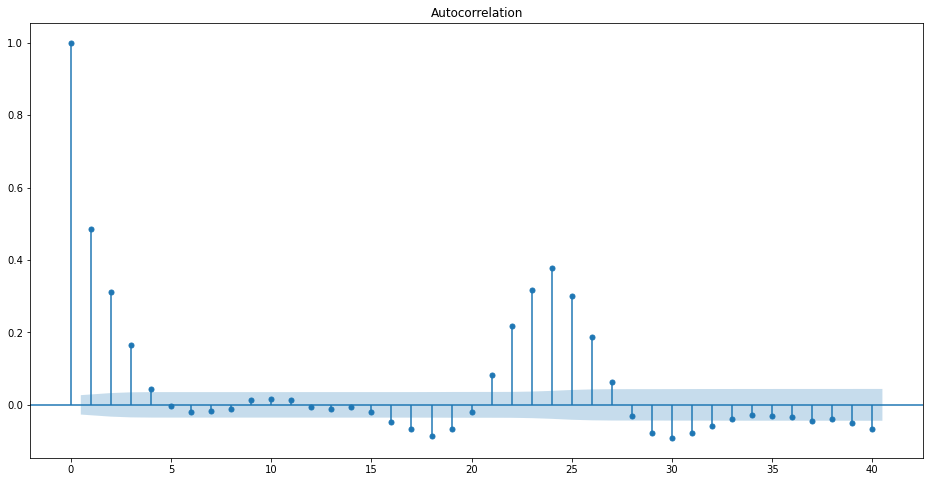

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
sm.graphics.tsa.plot_acf(dataFr['pos'].values.squeeze(), lags=40, ax=ax)
plt.show()

(array([0.12, 0.14, 0.16, 0.18, 0.2 , 0.22]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

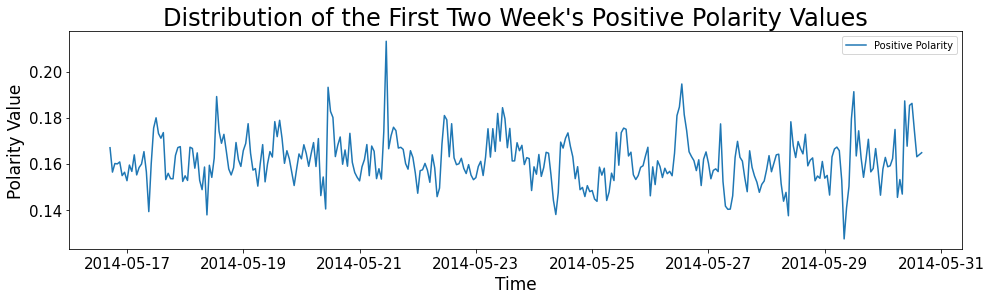

In [11]:
# Distribution of positive polarity over time (for the first two weeks)
plt.figure(figsize=(16,4))
plt.plot(dataFr['pos'][:24*14], label = "Positive Polarity")
plt.legend(loc='best')
plt.title('Distribution of the First Two Week\'s Positive Polarity Values', fontsize=24)
plt.xlabel('Time', fontsize=17)
plt.ylabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([-0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

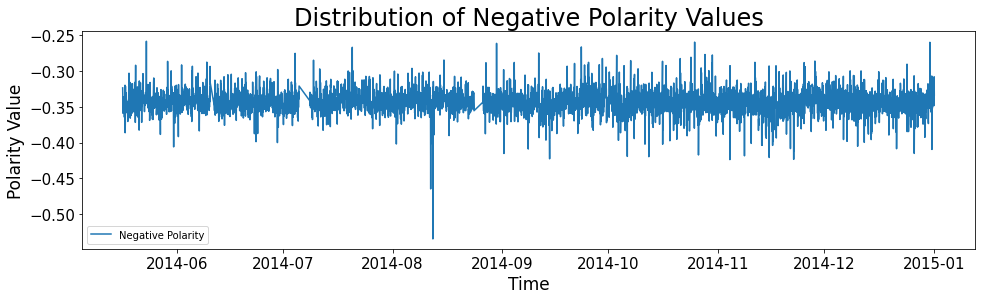

In [12]:
# Distribution of negative polarity over time
plt.figure(figsize=(16,4))
plt.plot(dataFr['neg'], label = "Negative Polarity")
plt.legend(loc='best')
plt.title('Distribution of Negative Polarity Values', fontsize=24)
plt.xlabel('Time', fontsize=17)
plt.ylabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([-0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

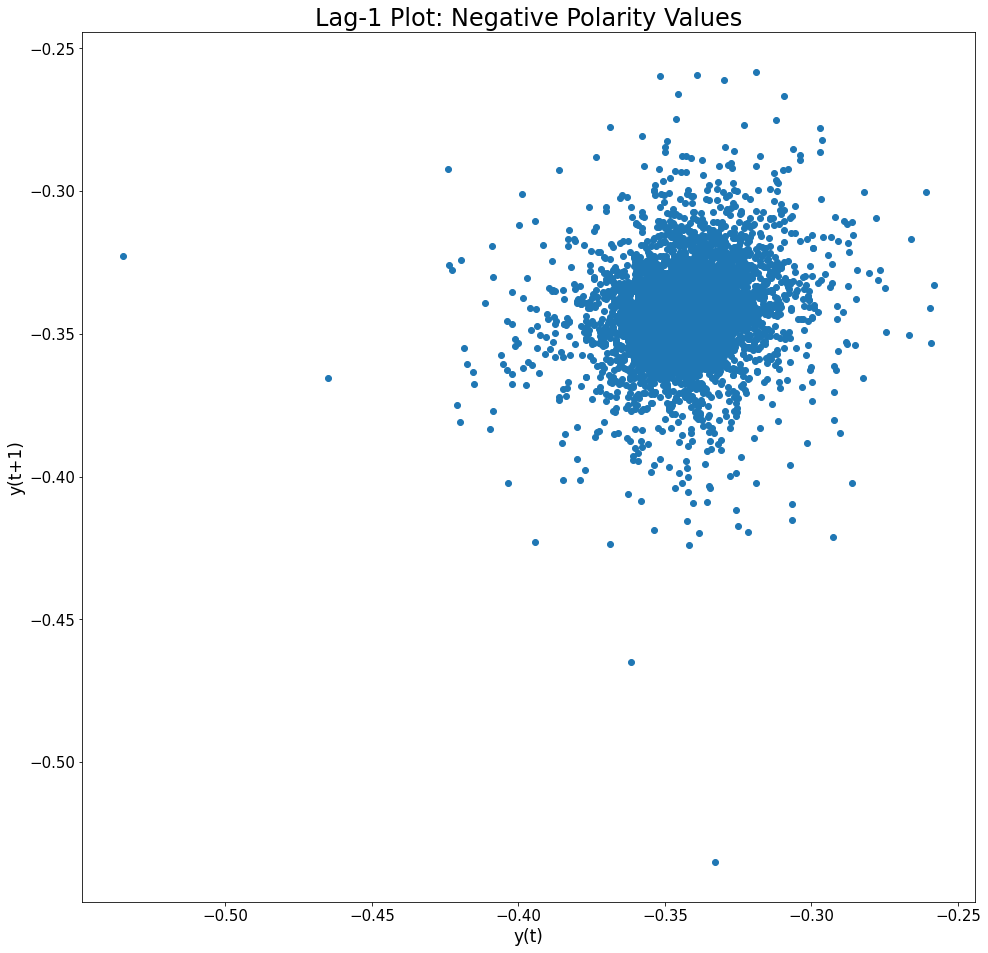

In [13]:
# TEMP LAG PLOT
plt.figure(figsize=(16,16))
pd.plotting.lag_plot(dataFr['neg'], lag= 1)
plt.title('Lag-1 Plot: Negative Polarity Values', fontsize=24)
plt.xlabel('y(t)', fontsize=17)
plt.ylabel('y(t+1)', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

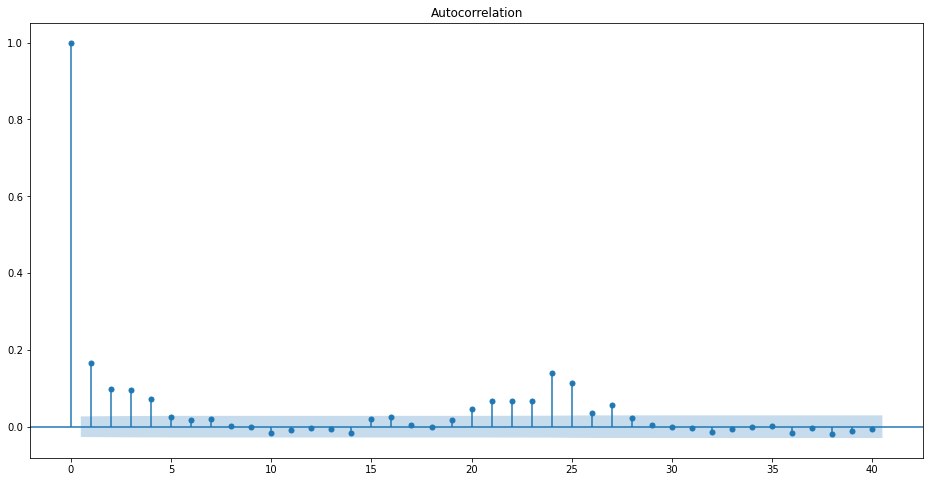

In [14]:
fig, ax = plt.subplots(figsize=(16, 8))
sm.graphics.tsa.plot_acf(dataFr['neg'].values.squeeze(), lags=40, ax=ax)
plt.show()

(array([-0.4 , -0.38, -0.36, -0.34, -0.32, -0.3 , -0.28, -0.26, -0.24]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

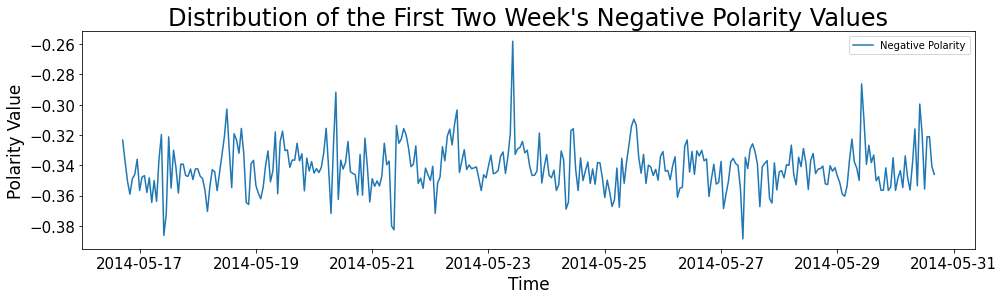

In [15]:
# Distribution of negative polarity over time (for the first two weeks)
plt.figure(figsize=(16,4))
plt.plot(dataFr['neg'][:24*14], label = "Negative Polarity")
plt.legend(loc='best')
plt.title('Distribution of the First Two Week\'s Negative Polarity Values', fontsize=24)
plt.xlabel('Time', fontsize=17)
plt.ylabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Missing Value(s)

In [16]:
# Look for any missing timestamp in the data
# Lets see the first timestamp and the last timestamp to identify the range of the data
start = dataFr.index[0]
end = dataFr.index[len(dataFr)-1]
print('Data ranges between', start, 'and', end)

Data ranges between 2014-05-16 17:00:00 and 2015-01-01 04:00:00


In [17]:
# Create a list of index with all the timestamp from start to end
# ------------- Creating Index for the 'Data_Filled' dataframe
year = start.year
month = start.month
day = start.day
hour = start.hour
indexList = []

for _ in iter(int, 1): # Infinite loop; it will break when the last timestamp will come
    dtStamp = datetime.datetime(year, month, day, hour)
    indexList.append(dtStamp)
    if(year==end.year and month==end.month and day==end.day and hour==end.hour):
        break
    hour = hour+1
    if(hour == 24):
        hour = 0
        day = day+1
        if(day == 29 and month == 2): # Handling February with 28 days
            day = 1
            month = month+1
        elif(day == 31 and (month == 6 or month == 9 or month == 11)): # Handling months with 30 days
            day = 1
            month = month+1
        elif(day == 32): # Handling months with 31 days
            day = 1
            month = month+1
        if(month == 13):
            month = 1
            year = year+1
        # Not considering leap year yet; can be handled that too with another condition on year!

In [18]:
# Compare the newly created list of index and the list of index from the original data to see if we have missing values
print('There are', (len(indexList)-len(dataFr.index)), 'missing value(s)!')

There are 161 missing value(s)!


In [19]:
# Lets create a new dataframe with all the possible timestamps ('indexList' as the index) and populate that
# If there are no values for a timestamp, I will keep it empty
Data_Filled = pd.DataFrame(np.nan, columns = ['pos', 'neg'], 
                   index = indexList)
i = 0
for idx in dataFr.index:
    Data_Filled.loc[idx]['pos'] = float(dataFr.loc[idx]['pos'])
    Data_Filled.loc[idx]['neg'] = float(dataFr.loc[idx]['neg'])
# Lets see how the dataframe looks like    
print(Data_Filled)
# Lets see how many missing values I have here and verify!
print('\n\nMissing Value(s) Statistics:\n',Data_Filled.isna().sum())

                          pos       neg
2014-05-16 17:00:00  0.166924 -0.323421
2014-05-16 18:00:00  0.156326 -0.337527
2014-05-16 19:00:00  0.160065 -0.350448
2014-05-16 20:00:00  0.159889 -0.359096
2014-05-16 21:00:00  0.160754 -0.348988
...                       ...       ...
2015-01-01 00:00:00  0.171641 -0.337959
2015-01-01 01:00:00  0.174609 -0.347718
2015-01-01 02:00:00  0.165537 -0.348260
2015-01-01 03:00:00  0.174688 -0.307910
2015-01-01 04:00:00  0.175032 -0.333467

[5508 rows x 2 columns]


Missing Value(s) Statistics:
 pos    161
neg    161
dtype: int64


In [20]:
# Handle Missing Values

# Use interpolation
df1 = Data_Filled.interpolate()

# Use forward fill
df2 = Data_Filled.ffill()

# Use backward fill
df3 = Data_Filled.bfill()

(array([0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

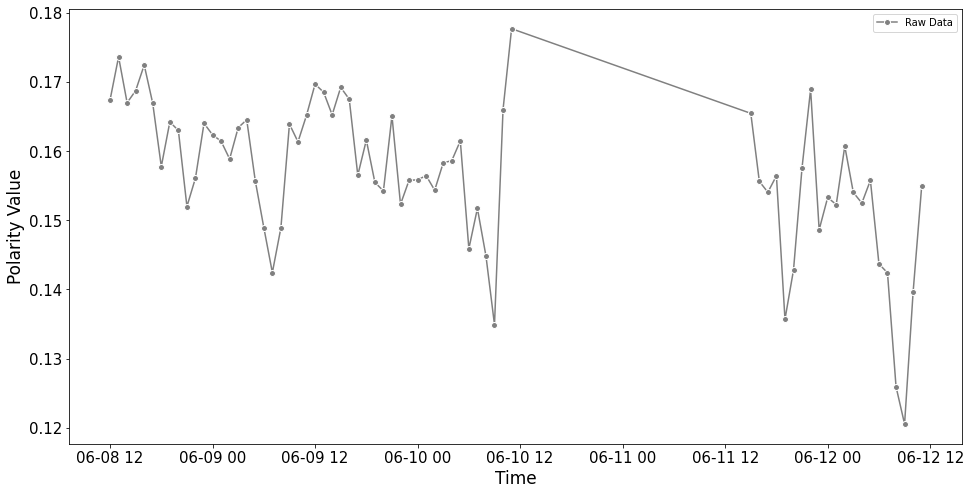

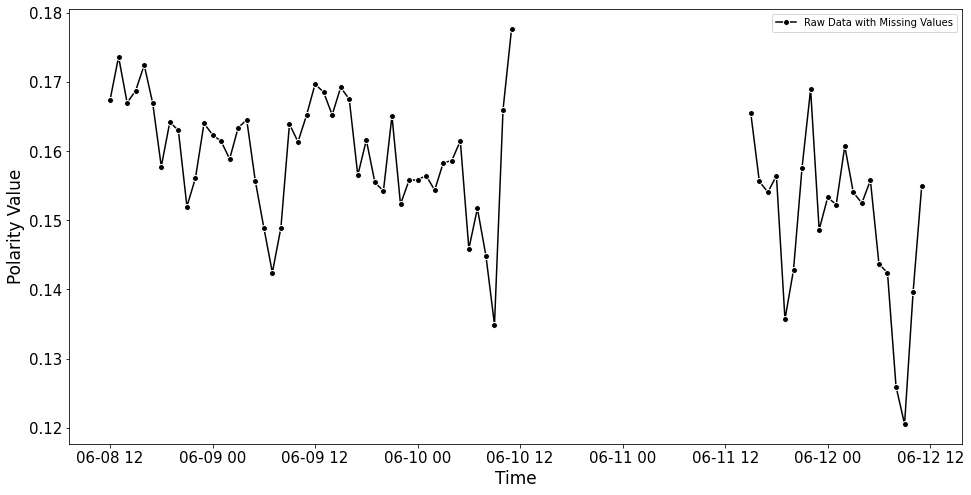

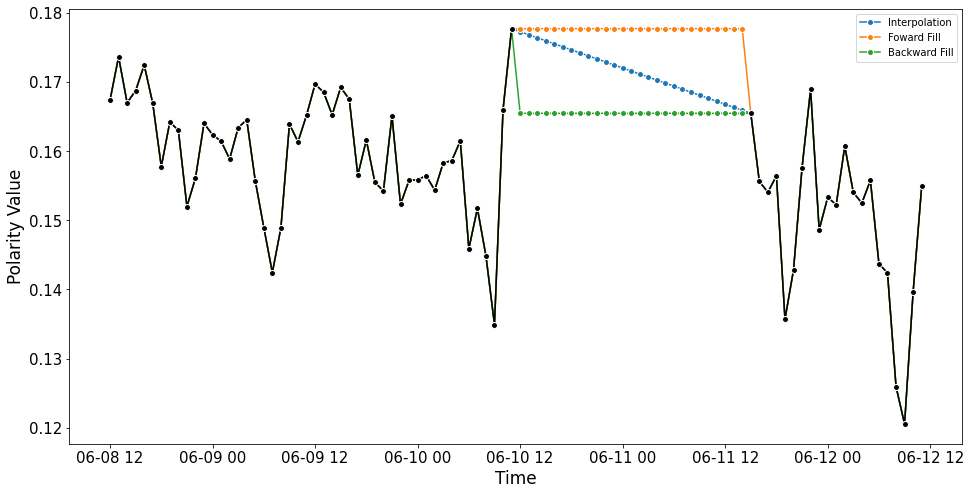

In [21]:
# Identify the first index with a missing value

firstMissingValIndex = pd.isnull(Data_Filled).any(1).to_numpy().nonzero()[0][0]

# Plot data from two days before to two days after (24*4 steps) of that timestamp where I found the fist missing value

# I do this plots for all of the five differents dataframe that I have and they are:
# 1. dataFr: This contains the source data where we have missing timestamp
# 2. Data_Filled: This contains the source data but with all the possible timestamps; meaning, if we have missing values,
#    they will can be seen here since the plot will be disjoint in those places
# 3. df1: Here, I handled missing values using interpolation; meaning, I took a straight line between the two available points
#    before and after a sequence of missing values and used that fitting line to fill up the missing values
# 4. df1: Here, I handled missing values using forward fill; meaning, I took the previous value when I saw a missing value
#    and did this recursively
# 5. df1: Here, I handled missing values using backward fill; meaning, I did the same thing as forward fill but instead of starting
#    the process from the begining of the series, here I started from the end and did this backward.    


# dataFr
plt.figure(figsize=(16,8))
# Manually adjusted the ending of it to match others
plt.plot(dataFr['pos'][firstMissingValIndex-24*2:firstMissingValIndex+21], label = "Raw Data", marker = 'o', markeredgecolor = 'white', color = 'gray')
plt.legend(loc='best')
#plt.title('Distribution of the First Two Week\'s Negative Polarity Values', fontsize=24)
plt.xlabel('Time', fontsize=17)
plt.ylabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Data_Filled
plt.figure(figsize=(16,8))
plt.plot(Data_Filled['pos'][firstMissingValIndex-24*2:firstMissingValIndex+24*2], label = "Raw Data with Missing Values", marker = 'o', markeredgecolor = 'white', color = 'black')
plt.legend(loc='best')
plt.xlabel('Time', fontsize=17)
plt.ylabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# df1, df2 and df3
plt.figure(figsize=(16,8))
plt.plot(df1['pos'][firstMissingValIndex-24*2:firstMissingValIndex+24*2], label = "Interpolation", marker = 'o', markeredgecolor = 'white')
plt.plot(df2['pos'][firstMissingValIndex-24*2:firstMissingValIndex+24*2], label = "Foward Fill", marker = 'o', markeredgecolor = 'white')
plt.plot(df3['pos'][firstMissingValIndex-24*2:firstMissingValIndex+24*2], label = "Backward Fill", marker = 'o', markeredgecolor = 'white')
plt.plot(Data_Filled['pos'][firstMissingValIndex-24*2:firstMissingValIndex+24*2], marker = 'o', markeredgecolor = 'white', color = 'black')
plt.legend(loc='best')
plt.xlabel('Time', fontsize=17)
plt.ylabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Statistical tests used to test whether the time series is stationary or not

### Augmented Dickey-Fuller test (ADF Test)

In [22]:
# Augmented Dickey-Fuller test (ADF Test) Function
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print('Test Statistic > Critical Value (1%)', dfoutput['Test Statistic']>dfoutput['Critical Value (1%)'])
    print('Test Statistic > Critical Value (5%)', dfoutput['Test Statistic']>dfoutput['Critical Value (5%)'])
    print('Test Statistic > Critical Value (10%)', dfoutput['Test Statistic']>dfoutput['Critical Value (10%)'])
    print('p-value > 0.05', dfoutput['p-value']>0.05)
    print(0.05/dfoutput['p-value'])

In [23]:
print('===================\nPositive Statistics:\n===================')
adf_test(dataFr['pos'])
adf_test(df1['pos'])
adf_test(df2['pos'])
adf_test(df3['pos'])

print('===================\nNegative Statistics:\n===================')
adf_test(dataFr['neg'])
adf_test(df1['neg'])
adf_test(df2['neg'])
adf_test(df3['neg'])

Positive Statistics:
Results of Dickey-Fuller Test:
Test Statistic                -1.035362e+01
p-value                        2.499448e-18
#Lags Used                     3.000000e+01
Number of Observations Used    5.316000e+03
Critical Value (1%)           -3.431581e+00
Critical Value (5%)           -2.862084e+00
Critical Value (10%)          -2.567059e+00
dtype: float64
Test Statistic > Critical Value (1%) False
Test Statistic > Critical Value (5%) False
Test Statistic > Critical Value (10%) False
p-value > 0.05 False
2.000441964676663e+16
Results of Dickey-Fuller Test:
Test Statistic                -1.115977e+01
p-value                        2.806902e-20
#Lags Used                     3.100000e+01
Number of Observations Used    5.476000e+03
Critical Value (1%)           -3.431545e+00
Critical Value (5%)           -2.862068e+00
Critical Value (10%)          -2.567051e+00
dtype: float64
Test Statistic > Critical Value (1%) False
Test Statistic > Critical Value (5%) False
Test Statist

### Kwiatkowski-Phillips-Schmidt-Shin test (KPSS test)

In [24]:
#Kwiatkowski-Phillips-Schmidt-Shin test (KPSS test) Function
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    print('Test Statistic < Critical Value (10%)', kpss_output['Test Statistic']<kpss_output['Critical Value (10%)'])
    print('Test Statistic < Critical Value (5%)', kpss_output['Test Statistic']<kpss_output['Critical Value (5%)'])
    print('Test Statistic < Critical Value (2.5%)', kpss_output['Test Statistic']<kpss_output['Critical Value (2.5%)'])
    print('Test Statistic < Critical Value (1%)', kpss_output['Test Statistic']<kpss_output['Critical Value (1%)'])
    
    print('p-value < 0.05', kpss_output['p-value']<0.05)
    print(0.05/kpss_output['p-value'])

In [25]:
print('===================\nPositive Statistics:\n===================')
kpss_test(dataFr['pos'])
kpss_test(df1['pos'])
kpss_test(df2['pos'])
kpss_test(df3['pos'])

print('===================\nNegative Statistics:\n===================')
kpss_test(dataFr['neg'])
kpss_test(df1['neg'])
kpss_test(df2['neg'])
kpss_test(df3['neg'])

Positive Statistics:
Results of KPSS Test:
Test Statistic            1.321066
p-value                   0.010000
#Lags Used               21.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Test Statistic < Critical Value (10%) False
Test Statistic < Critical Value (5%) False
Test Statistic < Critical Value (2.5%) False
Test Statistic < Critical Value (1%) False
p-value < 0.05 True
5.0
Results of KPSS Test:
Test Statistic            0.797588
p-value                   0.010000
#Lags Used               28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Test Statistic < Critical Value (10%) False
Test Statistic < Critical Value (5%) False
Test Statistic < Critical Value (2.5%) False
Test Statistic < Critical Value (1%) False
p-value < 0.05 True
5.0
Results of KPSS T

C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater t

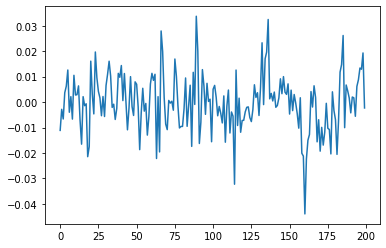

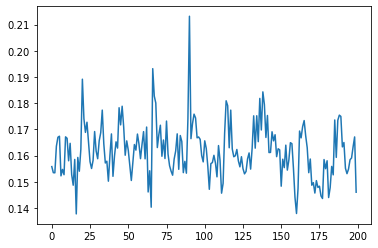

Positive Stats:
Results of Dickey-Fuller Test:
Test Statistic                  -19.811923
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    5296.000000
Critical Value (1%)              -3.431585
Critical Value (5%)              -2.862086
Critical Value (10%)             -2.567061
dtype: float64
Test Statistic > Critical Value (1%) False
Test Statistic > Critical Value (5%) False
Test Statistic > Critical Value (10%) False
p-value > 0.05 False
inf
Positive Stats:
Results of KPSS Test:
Test Statistic            0.005162
p-value                   0.100000
#Lags Used               30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Test Statistic < Critical Value (10%) True
Test Statistic < Critical Value (5%) True
Test Statistic < Critical Value (2.5%) True
Test Statistic < Critical Value (1%) True
p-value < 0.0

<ipython-input-22-0404f9b5e7bc>:13: RuntimeWarning: divide by zero encountered in double_scalars
  print(0.05/dfoutput['p-value'])
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [26]:
###############################################
# DO NOT EXECUTE THIS
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob
 
# difference the dataset
diffPositive = difference(data['positive'], 24)
pyplot.plot(diffPositive[:200])
pyplot.show()

# invert the difference
inverted = [inverse_difference(data['positive'][i], diffPositive[i]) for i in range(len(diffPositive))]
pyplot.plot(inverted[:200])
pyplot.show()

print('Positive Stats:')
adf_test(diffPositive)
print('Positive Stats:')
kpss_test(diffPositive)
###############################################

# Train Test Split for Simple Models

In [27]:
# Now, I have four different versions of the data
# Version 1: dataFr where I do not handle the missing values and use the data as is
# Version 2: df1 where I use interpolation to fill-up the missing values
# Version 3: df2 where I use forward fill to fill-up the missing values
# Version 4: df3 where I use backward fill to fill-up the missing values

#from sktime.forecasting.naive import NaiveForecaster
#from sktime.forecasting.model_selection import temporal_train_test_split

test_size=24*45 # I am setting aside last 45 days of data as test set

# Here I create four different sets of train and test for each of the different versions
y_train_dataFr_pos, y_test_dataFr_pos = temporal_train_test_split(dataFr['pos'], test_size = test_size)
y_train_dataFr_neg, y_test_dataFr_neg = temporal_train_test_split(dataFr['neg'], test_size = test_size)

y_train_df1_pos, y_test_df1_pos = temporal_train_test_split(df1['pos'], test_size = test_size)
y_train_df1_neg, y_test_df1_neg = temporal_train_test_split(df1['neg'], test_size = test_size)

y_train_df2_pos, y_test_df2_pos = temporal_train_test_split(df2['pos'], test_size = test_size)
y_train_df2_neg, y_test_df2_neg = temporal_train_test_split(df2['neg'], test_size = test_size)

y_train_df3_pos, y_test_df3_pos = temporal_train_test_split(df3['pos'], test_size = test_size)
y_train_df3_neg, y_test_df3_neg = temporal_train_test_split(df3['neg'], test_size = test_size)

print('\nStat for dataFr or missing values not handled')
print(len(y_train_dataFr_pos), len(y_test_dataFr_pos))
print(len(y_train_dataFr_neg), len(y_test_dataFr_neg))

print('\nStat for df1 or missing values handled by interpolation')
print(len(y_train_df1_pos), len(y_test_df1_pos))
print(len(y_train_df1_neg), len(y_test_df1_neg))

print('\nStat for df2 or missing values handled by forward fill')
print(len(y_train_df2_pos), len(y_test_df2_pos))
print(len(y_train_df2_neg), len(y_test_df2_neg))

print('\nStat for df3 or missing values handled by backward fill')
print(len(y_train_df3_pos), len(y_test_df3_pos))
print(len(y_train_df3_neg), len(y_test_df3_neg))


Stat for dataFr or missing values not handled
4267 1080
4267 1080

Stat for df1 or missing values handled by interpolation
4428 1080
4428 1080

Stat for df2 or missing values handled by forward fill
4428 1080
4428 1080

Stat for df3 or missing values handled by backward fill
4428 1080
4428 1080


# Organize Data to Execute Simple Models Easily

In [28]:
listOfData = [dataFr, df1, df2, df3]
listOfTrainData_Simple_Models = [y_train_dataFr_pos, y_train_df1_pos, y_train_df2_pos, y_train_df3_pos, y_train_dataFr_neg, y_train_df1_neg, y_train_df2_neg, y_train_df3_neg]
listOfTestData_Simple_Models = [y_test_dataFr_pos, y_test_df1_pos, y_test_df2_pos, y_test_df3_pos, y_test_dataFr_neg, y_test_df1_neg, y_test_df2_neg, y_test_df3_neg]

# Simple Models
- Naive
- Average
- Seasonal Naive
- Drift
- Rolling Average

In [29]:
# Naïve: Use last value as the predicted value
def naive(train, test):
    pred = pd.Series(train[len(train)-1], index = test.index)
    return pred

In [30]:
# Average: Use the average of the specified window as the predicted value
def average(train, test, window):
    if(window>len(train)):
        color = '\033[91m'
        print(f"{color}Window cannot be larger than the available Training Set!{color}")
        return
    pred = pd.Series(np.mean(train[-window:]), index = test.index)
    return pred

In [31]:
# Seasonal naïve: Use the observed values of the season specified by the given parameter.
def snNaive(train, test, season):
    seasonalValues = train[-season:]
    seasonalValuesLength = len(seasonalValues)
    testLength = len(test)
    pred = pd.Series(float, index = test.index)
    predIndex = 0
    while(testLength>=seasonalValuesLength):
        testLength = testLength-seasonalValuesLength
        pred[predIndex:predIndex+seasonalValuesLength] = seasonalValues
        predIndex = predIndex+seasonalValuesLength
    pred[predIndex:predIndex+testLength] = seasonalValues[0:testLength]
    return pred

In [32]:
# Drift: fit a line between the first and last value of the specified window to predict future.
# Last value of this rangle will be the last value of the training set; first value can be set using the 'window' parameter.
def drift(train, test, window):
    endVal = train[len(train)-1]
    startVal = train[-window]
    endIdx = len(train)-1
    startIdx = len(train)-window
    m = (endVal-startVal)/(endIdx-startIdx)
    c = endVal - m*endIdx
    pred = pd.Series(float, index = test.index)
    for i in range(0, len(test)):
        delta = test.index[i] - train.index[endIdx]
        delta = delta.days*24+delta.seconds//3600
        pred[test.index[i]] = m*(endIdx+delta)+c
    return pred

In [33]:
# Rolling Average: Use the rolling average of the specified window as the predicted value.
def rollingAverage(train, test, wndw):
    if(wndw>len(train)):
        color = '\033[91m'
        print(f"{color}Horizon cannot be larger than the available Training Set!{color}")
        return
    window = deque(train[-wndw:])
    pred = pd.Series(float, index = test.index)
    for i in range(0, len(pred)):
        pred[i] = np.mean(window)
        window.rotate(-1)
        window[len(window)-1] = pred[i]
    return pred

# Execute Simple Models Easily

In [34]:
listOfNaivePrediction = [None]*8
for i in range(0,len(listOfNaivePrediction)):
    listOfNaivePrediction[i]=naive(listOfTrainData_Simple_Models[i], listOfTestData_Simple_Models[i])

In [35]:
listOfAverage1WeekPrediction = [None]*8
window = 24*7
for i in range(0,len(listOfAverage1WeekPrediction)):
    listOfAverage1WeekPrediction[i]=average(listOfTrainData_Simple_Models[i], listOfTestData_Simple_Models[i], window)

In [36]:
listOfAverage4WeekPrediction = [None]*8
window = 24*7*4
for i in range(0,len(listOfAverage4WeekPrediction)):
    listOfAverage4WeekPrediction[i]=average(listOfTrainData_Simple_Models[i], listOfTestData_Simple_Models[i], window)

In [37]:
listOfSeasonalNaive1WeekPrediction = [None]*8
season = 24*7
for i in range(0,len(listOfSeasonalNaive1WeekPrediction)):
    listOfSeasonalNaive1WeekPrediction[i]=snNaive(listOfTrainData_Simple_Models[i], listOfTestData_Simple_Models[i], season)

In [38]:
listOfSeasonalNaive4WeekPrediction = [None]*8
season = 24*7*4
for i in range(0,len(listOfSeasonalNaive4WeekPrediction)):
    listOfSeasonalNaive4WeekPrediction[i]=snNaive(listOfTrainData_Simple_Models[i], listOfTestData_Simple_Models[i], season)

In [39]:
listOfDrift1WeekPrediction = [None]*8
window = 24*7
for i in range(0,len(listOfDrift1WeekPrediction)):
    listOfDrift1WeekPrediction[i]=drift(listOfTrainData_Simple_Models[i], listOfTestData_Simple_Models[i], window)

In [40]:
listOfDrift4WeekPrediction = [None]*8
window = 24*7*4
for i in range(0,len(listOfDrift4WeekPrediction)):
    listOfDrift4WeekPrediction[i]=drift(listOfTrainData_Simple_Models[i], listOfTestData_Simple_Models[i], window)

In [41]:
listOfRollingAverage1WeekPrediction = [None]*8
window = 24*7
for i in range(0,len(listOfRollingAverage1WeekPrediction)):
    listOfRollingAverage1WeekPrediction[i]=rollingAverage(listOfTrainData_Simple_Models[i], listOfTestData_Simple_Models[i], window)

In [42]:
listOfRollingAverage4WeekPrediction = [None]*8
window = 24*7*4
for i in range(0,len(listOfRollingAverage4WeekPrediction)):
    listOfRollingAverage4WeekPrediction[i]=rollingAverage(listOfTrainData_Simple_Models[i], listOfTestData_Simple_Models[i], window)

# Create the Performance Metrics Function

In [43]:
def performanceMetricsEntryGenerator(test, pred, i, algo, data=None):
    # R-squared
    r2 = r2_score(test, pred)
    # MAE = Mean Absolute Error
    mae = mean_absolute_error(test, pred)
    # MAPE = Mean Absolute Percentage Error
    mape = mean_absolute_percentage_error(test, pred)
    # MSE = Mean Squared Error
    mse = mean_squared_error(test, pred)
    # RMSE = Root Mean Squared Error
    rmse = math.sqrt(mean_squared_error(test, pred))
    # NRMSE = Normalized Root Mean Squared Error
    nrmse = math.sqrt(mean_squared_error(test, pred))/np.mean(test)
    # ME = Mean Error
    me = np.mean(test-pred)
    # MPE = Mean Percentage Error
    mpe = np.mean((test-pred)/test)
    if(data==None):
        dataAsDict = {'Algorithm':algo, 'R-squared':r2, 'MAE':mae, 'MAPE':mape, 'MSE':mse, 'RMSE':rmse, 'NRMSE':nrmse, 'ME':me, 'MPE':mpe}
    else:
        dataAsDict = {'Algorithm':algo, 'Data':data, 'R-squared':r2, 'MAE':mae, 'MAPE':mape, 'MSE':mse, 'RMSE':rmse, 'NRMSE':nrmse, 'ME':me, 'MPE':mpe}
    return dataAsDict

# Create the Performance Table

In [44]:
list1 = [None, None, None, None, None, None, None, None]
list2 = [None, None, None, None, None, None, None, None]
list3 = [None, None, None, None, None, None, None, None]
performanceTable = [list1, list2, list3]
namesOfPerformanceTableLayer1 = ['Simple Algorithms', 'Regressions', 'ARIMAs']
namesOfPerformanceTableLayer2 = ['Positive Data (allows missing values)', 'Positive Data (missing value handled through interpolation)', 'Positive Data (missing value handled through forward fill)', 'Positive Data (missing value handled through backward fill)', 'Negative Data (allows missing values)', 'Negative Data (missing value handled through interpolation)', 'Negative Data (missing value handled through forward fill)', 'Negative Data (missing value handled through backward fill)']

# Create the Calc-Friendly Performance Table

In [45]:
performanceTableCalcFriendly = [None, None, None]

# Fill-up the Performance Table with Simple Models' Data

In [46]:
for dataIndex in range(0,8):
    entryTable = pd.DataFrame(columns=['Algorithm', 'R-squared', 'MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'ME', 'MPE'])
    listOfAlgoNames = ['Naive', 'Average of 1 Week', 'Average of 4 Week', 'Seasonal Naive 1 Week', 'Seasonal Naive 4 Week', 'Drift 1 Week', 'Drift 4 Week', 'Rolling Average 1 Week', 'Rolling Average 4 Week']
    listOfPredictedSets = [listOfNaivePrediction, listOfAverage1WeekPrediction, listOfAverage4WeekPrediction, listOfSeasonalNaive1WeekPrediction, listOfSeasonalNaive4WeekPrediction, listOfDrift1WeekPrediction, listOfDrift4WeekPrediction, listOfRollingAverage1WeekPrediction, listOfRollingAverage4WeekPrediction]
    for i in range(0, len(listOfAlgoNames)):
        entry = performanceMetricsEntryGenerator(listOfTestData_Simple_Models[dataIndex], listOfPredictedSets[i][dataIndex], 0, listOfAlgoNames[i])
        entryTable = entryTable.append(entry, ignore_index=True)
    performanceTable[0][dataIndex] = entryTable

In [47]:
performanceTable[0][0]

Algorithm  R-squared       MAE      MAPE       MSE      RMSE  \
0                   Naive  -0.022055  0.009715  0.059577  0.000201  0.014169   
1       Average of 1 Week  -0.071682  0.010682  0.067842  0.000211  0.014509   
2       Average of 4 Week  -0.052448  0.010492  0.066447  0.000207  0.014378   
3   Seasonal Naive 1 Week  -0.462071  0.011612  0.073593  0.000287  0.016947   
4   Seasonal Naive 4 Week  -0.809750  0.013033  0.082835  0.000355  0.018854   
5            Drift 1 Week  -4.530495  0.027684  0.179228  0.001086  0.032960   
6            Drift 4 Week  -0.148093  0.010382  0.062430  0.000226  0.015017   
7  Rolling Average 1 Week  -0.023037  0.010185  0.064169  0.000201  0.014176   
8  Rolling Average 4 Week  -0.040161  0.010382  0.065648  0.000204  0.014294   

      NRMSE        ME       MPE  
0  0.088956  0.002081  0.006045  
1  0.091090 -0.003752 -0.030842  
2  0.090269 -0.003210 -0.027410  
3  0.106395 -0.003911 -0.030231  
4  0.118371 -0.003378 -0.027403  
5  0.206928 -0.024168 -0.161352  
6  0.094281  0.005949  0.030712  
7  0.088999 -0.002253 -0.021353  
8  0.089740 -0.002908 -0.025489

# Fill-up the Calc-Friendly Performance Table with Simple Models' Data

In [48]:
entryTable = pd.DataFrame(columns=['Algorithm', 'Data', 'R-squared', 'MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'ME', 'MPE'])
data = ['Positive Data (allows missing values)', 'Positive Data (missing value handled through interpolation)', 'Positive Data (missing value handled through forward fill)', 'Positive Data (missing value handled through backward fill)', 'Negative Data (allows missing values)', 'Negative Data (missing value handled through interpolation)', 'Negative Data (missing value handled through forward fill)', 'Negative Data (missing value handled through backward fill)']
for dataIndex in range(0,8):
    listOfAlgoNames = ['Naive', 'Average of 1 Week', 'Average of 4 Week', 'Seasonal Naive 1 Week', 'Seasonal Naive 4 Week', 'Drift 1 Week', 'Drift 4 Week', 'Rolling Average 1 Week', 'Rolling Average 4 Week']
    listOfPredictedSets = [listOfNaivePrediction, listOfAverage1WeekPrediction, listOfAverage4WeekPrediction, listOfSeasonalNaive1WeekPrediction, listOfSeasonalNaive4WeekPrediction, listOfDrift1WeekPrediction, listOfDrift4WeekPrediction, listOfRollingAverage1WeekPrediction, listOfRollingAverage4WeekPrediction]
    for i in range(0, len(listOfAlgoNames)):
        entry = performanceMetricsEntryGenerator(listOfTestData_Simple_Models[dataIndex], listOfPredictedSets[i][dataIndex], 0, listOfAlgoNames[i], data[dataIndex])
        entryTable = entryTable.append(entry, ignore_index=True) 
performanceTableCalcFriendly[0] = entryTable

In [49]:
performanceTableCalcFriendly[0]

Algorithm                                               Data  \
0                    Naive              Positive Data (allows missing values)   
1        Average of 1 Week              Positive Data (allows missing values)   
2        Average of 4 Week              Positive Data (allows missing values)   
3    Seasonal Naive 1 Week              Positive Data (allows missing values)   
4    Seasonal Naive 4 Week              Positive Data (allows missing values)   
..                     ...                                                ...   
67   Seasonal Naive 4 Week  Negative Data (missing value handled through b...   
68            Drift 1 Week  Negative Data (missing value handled through b...   
69            Drift 4 Week  Negative Data (missing value handled through b...   
70  Rolling Average 1 Week  Negative Data (missing value handled through b...   
71  Rolling Average 4 Week  Negative Data (missing value handled through b...   

    R-squared       MAE      MAPE       MSE      RMSE     NRMSE        ME  \
0   -0.022055  0.009715  0.059577  0.000201  0.014169  0.088956  0.002081   
1   -0.071682  0.010682  0.067842  0.000211  0.014509  0.091090 -0.003752   
2   -0.052448  0.010492  0.066447  0.000207  0.014378  0.090269 -0.003210   
3   -0.462071  0.011612  0.073593  0.000287  0.016947  0.106395 -0.003911   
4   -0.809750  0.013033  0.082835  0.000355  0.018854  0.118371 -0.003378   
..        ...       ...       ...       ...       ...       ...       ...   
67  -1.059940  0.017541  0.051344  0.000589  0.024278 -0.070684  0.000471   
68  -5.025398  0.034577  0.098966  0.001724  0.041522 -0.120888 -0.032516   
69  -0.376575  0.015545  0.046188  0.000394  0.019847 -0.057782  0.009369   
70  -0.197615  0.014083  0.041859  0.000343  0.018512 -0.053895  0.007484   
71  -0.026025  0.012620  0.037106  0.000294  0.017134 -0.049885  0.002491   

         MPE  
0   0.006045  
1  -0.030842  
2  -0.027410  
3  -0.030231  
4  -0.027403  
..       ...  
67 -0.003716  
68  0.092287  
69 -0.029708  
70 -0.024267  
71 -0.009696  

[72 rows x 10 columns]

# Identify Best Performer from the Performance Table

In [50]:
def bestPerformer(dfEntryTable):
    cols = dfEntryTable.columns
    for i in range(1, len(cols)):
        eachCol = dfEntryTable[cols[i]]
        if(cols[i]=='R-squared'):
            maxVal = eachCol.max()
            maxIndex = eachCol.idxmax()
            algo = dfEntryTable['Algorithm'][maxIndex]
            print(cols[i], '=>', algo, maxVal, maxIndex)
        else:
            minVal = eachCol.abs().min()
            minIndex = eachCol.abs().idxmin()
            algo = dfEntryTable['Algorithm'][minIndex]
            print(cols[i], '=>', algo, eachCol[minIndex], minIndex)

In [51]:
for idxSm in range(0, len(performanceTable[0])):
    print(namesOfPerformanceTableLayer2[idxSm])
    bestPerformer(performanceTable[0][idxSm])
    print('\n')

Positive Data (allows missing values)
R-squared => Naive -0.02205544329408138 0
MAE => Naive 0.009714643972222223 0
MAPE => Naive 0.059576890298754404 0
MSE => Naive 0.00020076185537795508 0
RMSE => Naive 0.014169045676331031 0
NRMSE => Naive 0.08895591115536865 0
ME => Naive 0.0020814274037037075 0
MPE => Naive 0.00604485290978223 0


Positive Data (missing value handled through interpolation)
R-squared => Naive -0.02205544329408138 0
MAE => Naive 0.009714643972222223 0
MAPE => Naive 0.059576890298754404 0
MSE => Naive 0.00020076185537795508 0
RMSE => Naive 0.014169045676331031 0
NRMSE => Naive 0.08895591115536865 0
ME => Naive 0.0020814274037037075 0
MPE => Naive 0.00604485290978223 0


Positive Data (missing value handled through forward fill)
R-squared => Naive -0.02205544329408138 0
MAE => Naive 0.009714643972222223 0
MAPE => Naive 0.059576890298754404 0
MSE => Naive 0.00020076185537795508 0
RMSE => Naive 0.014169045676331031 0
NRMSE => Naive 0.08895591115536865 0
ME => Naive 0.00

# Identify Best Performer from the Calc-Friendly Performance Table

In [52]:
def bestPerformerCalcFriendly(dfEntryTable):
    cols = dfEntryTable.columns
    for i in range(2, len(cols)):
        eachCol = dfEntryTable[cols[i]]
        if(cols[i]=='R-squared'):
            maxVal = eachCol.max()
            maxIndex = eachCol.idxmax()
            algo = dfEntryTable['Algorithm'][maxIndex]
            data = dfEntryTable['Data'][maxIndex]
            print(cols[i], '=>', algo, '=>', data, '=>', maxVal, '=>', maxIndex)
        else:
            minVal = eachCol.abs().min()
            minIndex = eachCol.abs().idxmin()
            algo = dfEntryTable['Algorithm'][minIndex]
            data = dfEntryTable['Data'][minIndex]
            print(cols[i], '=>', algo, '=>', data, '=>', eachCol[minIndex], '=>', minIndex)

In [53]:
print('Positive Data Group')
bestPerformerCalcFriendly(performanceTableCalcFriendly[0][:len(performanceTableCalcFriendly[0])//2])
print('\n')
print('Negative Data Group')
bestPerformerCalcFriendly(performanceTableCalcFriendly[0][len(performanceTableCalcFriendly[0])//2:])

Positive Data Group
R-squared => Naive => Positive Data (allows missing values) => -0.02205544329408138 => 0
MAE => Naive => Positive Data (allows missing values) => 0.009714643972222223 => 0
MAPE => Naive => Positive Data (allows missing values) => 0.059576890298754404 => 0
MSE => Naive => Positive Data (allows missing values) => 0.00020076185537795508 => 0
RMSE => Naive => Positive Data (allows missing values) => 0.014169045676331031 => 0
NRMSE => Naive => Positive Data (allows missing values) => 0.08895591115536865 => 0
ME => Naive => Positive Data (allows missing values) => 0.0020814274037037075 => 0
MPE => Naive => Positive Data (allows missing values) => 0.00604485290978223 => 0


Negative Data Group
R-squared => Naive => Negative Data (allows missing values) => -0.0013962515967456124 => 36
MAE => Naive => Negative Data (allows missing values) => 0.012403671787037036 => 36
MAPE => Naive => Negative Data (allows missing values) => 0.036148634112235366 => 36
MSE => Naive => Negativ

# For both the positive and negative data, the naive method where I used the last observation from the training set to predict or estimate the future worked best regardless of data-cleaning.

# Train Test Split for Regressions


In [54]:
def reduction(data, nF = 24):
    features = []
    target = []
    for i in range(len(data)-nF):
        features.append(data[i:i+nF])
        target.append(data[i+nF])
    features = np.array(features)
    target = np.array(target)
    return features, target

In [55]:
def temporal_features_target_split(features, target, test_size):
    features_train, features_test = temporal_train_test_split(features, test_size = test_size)
    target_train, target_test = temporal_train_test_split(target, test_size = test_size)
    return features_train, target_train, features_test, target_test

In [56]:
test_size=24*45 #Set-aside last 45 days of data as test set

# Here I create four different sets of train and test for each of the different versions
# dataFr Positive
dataFr_pos_features, dataFr_pos_target= reduction(dataFr['pos'])
dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test = temporal_features_target_split(dataFr_pos_features, dataFr_pos_target, test_size)
# dataFr Negative
dataFr_neg_features, dataFr_neg_target= reduction(dataFr['neg'])
dataFr_neg_features_train, dataFr_neg_target_train, dataFr_neg_features_test, dataFr_neg_target_test = temporal_features_target_split(dataFr_neg_features, dataFr_neg_target, test_size)



# df1 Positive
df1_pos_features, df1_pos_target= reduction(df1['pos'])
df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test = temporal_features_target_split(df1_pos_features, df1_pos_target, test_size)
# df1 Negative
df1_neg_features, df1_neg_target= reduction(df1['neg'])
df1_neg_features_train, df1_neg_target_train, df1_neg_features_test, df1_neg_target_test = temporal_features_target_split(df1_neg_features, df1_neg_target, test_size)



# df2 Positive
df2_pos_features, df2_pos_target= reduction(df2['pos'])
df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test = temporal_features_target_split(df2_pos_features, df2_pos_target, test_size)
# df2 Negative
df2_neg_features, df2_neg_target= reduction(df2['neg'])
df2_neg_features_train, df2_neg_target_train, df2_neg_features_test, df2_neg_target_test = temporal_features_target_split(df2_neg_features, df2_neg_target, test_size)



# df3 Positive
df3_pos_features, df3_pos_target= reduction(df3['pos'])
df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test = temporal_features_target_split(df3_pos_features, df3_pos_target, test_size)
# df3 Negative
df3_neg_features, df3_neg_target= reduction(df3['neg'])
df3_neg_features_train, df3_neg_target_train, df3_neg_features_test, df3_neg_target_test = temporal_features_target_split(df3_neg_features, df3_neg_target, test_size)


# Organize Data to Execute Regression Models Easily

In [57]:
listOfFeatures_Regressions = [dataFr_pos_features, df1_pos_features, df2_pos_features, df3_pos_features, dataFr_neg_features, df1_neg_features, df2_neg_features, df3_neg_features]
listOfTarget_Regressions = [dataFr_pos_target, df1_pos_target, df2_pos_target, df3_pos_target, dataFr_neg_target, df1_neg_target, df2_neg_target, df3_neg_target]

listOfTrainFeatures_Regressions = [dataFr_pos_features_train, df1_pos_features_train, df2_pos_features_train, df3_pos_features_train, 
                                  dataFr_neg_features_train, df1_neg_features_train, df2_neg_features_train, df3_neg_features_train]
listOfTrainTarget_Regressions = [dataFr_pos_target_train, df1_pos_target_train, df2_pos_target_train, df3_pos_target_train, 
                                dataFr_neg_target_train, df1_neg_target_train, df2_neg_target_train, df3_neg_target_train]

listOfTestFeatures_Regressions = [dataFr_pos_features_test, df1_pos_features_test, df2_pos_features_test, df3_pos_features_test, 
                                 dataFr_neg_features_test, df1_neg_features_test, df2_neg_features_test, df3_neg_features_test]
listOfTestTarget_Regressions = [dataFr_pos_target_test, df1_pos_target_test, df2_pos_target_test, df3_pos_target_test, 
                               dataFr_neg_target_test, df1_neg_target_test, df2_neg_target_test, df3_neg_target_test, ]


#listOfTrainData_Simple_Models = [y_train_dataFr_pos, y_train_df1_pos, y_train_df2_pos, y_train_df3_pos, y_train_dataFr_neg, y_train_df1_neg, y_train_df2_neg, y_train_df3_neg]
#listOfTestData_Simple_Models = [y_test_dataFr_pos, y_test_df1_pos, y_test_df2_pos, y_test_df3_pos, y_test_dataFr_neg, y_test_df1_neg, y_test_df2_neg, y_test_df3_neg]

# Regression Models
- Linear Regression
- Support Vector Regression
- K Neighbors Regression
- Decision Tree Regression
- Random Forest Regression

In [58]:
def linearReg(features_train, target_train, features_test, target_test):
    reg = LinearRegression().fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    return target_pred

In [59]:
def SVReg(features_train, target_train, features_test, target_test):
    reg = SVR(kernel='rbf').fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    return target_pred

In [60]:
def KNReg(features_train, target_train, features_test, target_test):
    reg = KNeighborsRegressor(n_neighbors=8).fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    return target_pred

In [61]:
def DTReg(features_train, target_train, features_test, target_test):
    reg = DecisionTreeRegressor(random_state=0).fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    return target_pred

In [62]:
def RFReg(features_train, target_train, features_test, target_test):
    reg = RandomForestRegressor(max_depth=12, random_state=0).fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    return target_pred

# Execute Regression Models Easily

In [63]:
listOfLinearRegPrediction = [None]*8
for i in range(0,len(listOfLinearRegPrediction)):
    listOfLinearRegPrediction[i]=linearReg(listOfTrainFeatures_Regressions[i], listOfTrainTarget_Regressions[i],
                                          listOfTestFeatures_Regressions[i], listOfTestTarget_Regressions[i])

In [64]:
listOfSVRegPrediction = [None]*8
for i in range(0,len(listOfSVRegPrediction)):
    listOfSVRegPrediction[i]=SVReg(listOfTrainFeatures_Regressions[i], listOfTrainTarget_Regressions[i],
                                          listOfTestFeatures_Regressions[i], listOfTestTarget_Regressions[i])

In [65]:
listOfKNRegPrediction = [None]*8
for i in range(0,len(listOfKNRegPrediction)):
    listOfKNRegPrediction[i]=KNReg(listOfTrainFeatures_Regressions[i], listOfTrainTarget_Regressions[i],
                                          listOfTestFeatures_Regressions[i], listOfTestTarget_Regressions[i])

In [66]:
listOfDTRegPrediction = [None]*8
for i in range(0,len(listOfDTRegPrediction)):
    listOfDTRegPrediction[i]=DTReg(listOfTrainFeatures_Regressions[i], listOfTrainTarget_Regressions[i],
                                          listOfTestFeatures_Regressions[i], listOfTestTarget_Regressions[i])

In [67]:
listOfRFRegPrediction = [None]*8
for i in range(0,len(listOfRFRegPrediction)):
    listOfRFRegPrediction[i]=RFReg(listOfTrainFeatures_Regressions[i], listOfTrainTarget_Regressions[i],
                                          listOfTestFeatures_Regressions[i], listOfTestTarget_Regressions[i])

# Fill-up the Performance Table with Regression Models' Data

In [68]:
for dataIndex in range(0,8):
    entryTable = pd.DataFrame(columns=['Algorithm', 'R-squared', 'MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'ME', 'MPE'])
    listOfAlgoNames = ['Linear Regression', 'Support Vector Regression', 'K Neighbors Regression', 'Decision Tree Regression', 'Random Forest Regression']
    listOfPredictedSets = [listOfLinearRegPrediction, listOfSVRegPrediction, listOfKNRegPrediction, listOfDTRegPrediction, listOfRFRegPrediction]
    for i in range(0, len(listOfAlgoNames)):
        entry = performanceMetricsEntryGenerator(listOfTestTarget_Regressions[dataIndex], listOfPredictedSets[i][dataIndex], 0, listOfAlgoNames[i])
        entryTable = entryTable.append(entry, ignore_index=True)
    #print(entryTable)
    performanceTable[1][dataIndex] = entryTable

In [69]:
performanceTable[1][0]

Algorithm  R-squared       MAE      MAPE       MSE  \
0          Linear Regression   0.205066  0.008882  0.055549  0.000156   
1  Support Vector Regression  -2.125377  0.022145  0.144280  0.000614   
2     K Neighbors Regression   0.206979  0.008996  0.056534  0.000156   
3   Decision Tree Regression  -0.488800  0.012344  0.077518  0.000292   
4   Random Forest Regression   0.253046  0.008604  0.054027  0.000147   

       RMSE     NRMSE        ME       MPE  
0  0.012496  0.078452 -0.000036 -0.005737  
1  0.024777  0.155557 -0.020432 -0.136308  
2  0.012481  0.078357 -0.000492 -0.008461  
3  0.017101  0.107363 -0.000906 -0.011063  
4  0.012113  0.076047 -0.000333 -0.007445

# Identify Best Performer from the Performance Table

In [70]:
for idxRm in range(0, len(performanceTable[1])):
    print(namesOfPerformanceTableLayer2[idxRm])
    bestPerformer(performanceTable[1][idxRm])
    print('\n')

Positive Data (allows missing values)
R-squared => Random Forest Regression 0.2530456911685528 4
MAE => Random Forest Regression 0.008604406354444247 4
MAPE => Random Forest Regression 0.054027385546719035 4
MSE => Random Forest Regression 0.00014672387286568235 4
RMSE => Random Forest Regression 0.012112963009341783 4
NRMSE => Random Forest Regression 0.0760474407311171 4
ME => Linear Regression -3.619430414885295e-05 0
MPE => Linear Regression -0.005736577369869964 0


Positive Data (missing value handled through interpolation)
R-squared => Linear Regression 0.23319157658701573 0
MAE => Random Forest Regression 0.008690924457720012 4
MAPE => Random Forest Regression 0.054536100625513034 4
MSE => Linear Regression 0.00015062380697045968 0
RMSE => Linear Regression 0.012272889104463532 0
NRMSE => Linear Regression 0.07705148658106734 0
ME => Linear Regression -3.626409272238059e-05 0
MPE => Linear Regression -0.0054926211964320204 0


Positive Data (missing value handled through forwar

# Fill-up the Calc-Friendly Performance Table with Regression Models' Data

In [71]:
entryTable = pd.DataFrame(columns=['Algorithm', 'Data', 'R-squared', 'MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'ME', 'MPE'])
data = ['Positive Data (allows missing values)', 'Positive Data (missing value handled through interpolation)', 'Positive Data (missing value handled through forward fill)', 'Positive Data (missing value handled through backward fill)', 'Negative Data (allows missing values)', 'Negative Data (missing value handled through interpolation)', 'Negative Data (missing value handled through forward fill)', 'Negative Data (missing value handled through backward fill)']
for dataIndex in range(0,8):
    listOfAlgoNames = ['Linear Regression', 'Support Vector Regression', 'K Neighbors Regression', 'Decision Tree Regression', 'Random Forest Regression']
    listOfPredictedSets = [listOfLinearRegPrediction, listOfSVRegPrediction, listOfKNRegPrediction, listOfDTRegPrediction, listOfRFRegPrediction]
    for i in range(0, len(listOfAlgoNames)):
        entry = performanceMetricsEntryGenerator(listOfTestTarget_Regressions[dataIndex], listOfPredictedSets[i][dataIndex], 0, listOfAlgoNames[i], data[dataIndex])
        entryTable = entryTable.append(entry, ignore_index=True) 
#entryTable
performanceTableCalcFriendly[1] = entryTable

In [72]:
performanceTableCalcFriendly[1]

Algorithm  \
0           Linear Regression   
1   Support Vector Regression   
2      K Neighbors Regression   
3    Decision Tree Regression   
4    Random Forest Regression   
5           Linear Regression   
6   Support Vector Regression   
7      K Neighbors Regression   
8    Decision Tree Regression   
9    Random Forest Regression   
10          Linear Regression   
11  Support Vector Regression   
12     K Neighbors Regression   
13   Decision Tree Regression   
14   Random Forest Regression   
15          Linear Regression   
16  Support Vector Regression   
17     K Neighbors Regression   
18   Decision Tree Regression   
19   Random Forest Regression   
20          Linear Regression   
21  Support Vector Regression   
22     K Neighbors Regression   
23   Decision Tree Regression   
24   Random Forest Regression   
25          Linear Regression   
26  Support Vector Regression   
27     K Neighbors Regression   
28   Decision Tree Regression   
29   Random Forest Regression   
30          Linear Regression   
31  Support Vector Regression   
32     K Neighbors Regression   
33   Decision Tree Regression   
34   Random Forest Regression   
35          Linear Regression   
36  Support Vector Regression   
37     K Neighbors Regression   
38   Decision Tree Regression   
39   Random Forest Regression   

                                                 Data  R-squared       MAE  \
0               Positive Data (allows missing values)   0.205066  0.008882   
1               Positive Data (allows missing values)  -2.125377  0.022145   
2               Positive Data (allows missing values)   0.206979  0.008996   
3               Positive Data (allows missing values)  -0.488800  0.012344   
4               Positive Data (allows missing values)   0.253046  0.008604   
5   Positive Data (missing value handled through i...   0.233192  0.008766   
6   Positive Data (missing value handled through i...  -2.125377  0.022145   
7   Positive Data (missing value handled through i...   0.199829  0.009027   
8   Positive Data (missing value handled through i...  -0.368408  0.011803   
9   Positive Data (missing value handled through i...   0.229014  0.008691   
10  Positive Data (missing value handled through f...   0.231673  0.008757   
11  Positive Data (missing value handled through f...  -2.125377  0.022145   
12  Positive Data (missing value handled through f...   0.205728  0.008995   
13  Positive Data (missing value handled through f...  -0.364609  0.011756   
14  Positive Data (missing value handled through f...   0.253839  0.008583   
15  Positive Data (missing value handled through b...   0.224561  0.008799   
16  Positive Data (missing value handled through b...  -2.125377  0.022145   
17  Positive Data (missing value handled through b...   0.208854  0.008957   
18  Positive Data (missing value handled through b...  -0.307896  0.011657   
19  Positive Data (missing value handled through b...   0.260998  0.008613   
20              Negative Data (allows missing values)   0.036681  0.012144   
21              Negative Data (allows missing values)  -3.024686  0.030477   
22              Negative Data (allows missing values)  -0.073606  0.012984   
23              Negative Data (allows missing values)  -1.021789  0.018324   
24              Negative Data (allows missing values)   0.002366  0.012320   
25  Negative Data (missing value handled through i...   0.035548  0.012155   
26  Negative Data (missing value handled through i...  -2.738409  0.029231   
27  Negative Data (missing value handled through i...  -0.053941  0.012786   
28  Negative Data (missing value handled through i...  -1.083467  0.018048   
29  Negative Data (missing value handled through i...  -0.004948  0.012292   
30  Negative Data (missing value handled through f...   0.034192  0.012169   
31  Negative Data (missing value handled through f...  -2.778966  0.029389   
32  Negative Data (missing value handled through f...  -0.064882  0.012901   
33  Negative D

# Identify Best Performer from the Calc-Friendly Performance Table

In [73]:
print('Positive Data Group')
bestPerformerCalcFriendly(performanceTableCalcFriendly[1][:len(performanceTableCalcFriendly[1])//2])
print('\n')
print('Negative Data Group')
bestPerformerCalcFriendly(performanceTableCalcFriendly[1][len(performanceTableCalcFriendly[1])//2:])

Positive Data Group
R-squared => Random Forest Regression => Positive Data (missing value handled through backward fill) => 0.260998412166099 => 19
MAE => Random Forest Regression => Positive Data (missing value handled through forward fill) => 0.00858276079131929 => 14
MAPE => Random Forest Regression => Positive Data (missing value handled through forward fill) => 0.05396173414479203 => 14
MSE => Random Forest Regression => Positive Data (missing value handled through backward fill) => 0.00014516172373449162 => 19
RMSE => Random Forest Regression => Positive Data (missing value handled through backward fill) => 0.012048307919973312 => 19
NRMSE => Random Forest Regression => Positive Data (missing value handled through backward fill) => 0.0756415240224702 => 19
ME => Decision Tree Regression => Positive Data (missing value handled through backward fill) => -1.784915833333338e-05 => 18
MPE => Decision Tree Regression => Positive Data (missing value handled through backward fill) => -0.

# For the positive data, it seems that handling missing values using forward fill works in the favor of prediction when I use Random Forest.

# For the negative data, it can be used as-is but if we want to handle the missing values, we should use interpolation this time. As an algorithm, if we fill the data using inperpolation, we should use Random Forest; however, raw data in combination to linear regression works the best.

# ARIMA

In [74]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

In [75]:
auto_arima1_stepwise = auto_arima(listOfTrainData_Simple_Models[0], d=0, max_d=3, trace=True,
                         supress_warnings=True, stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-25735.522, Time=1.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-24534.196, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-25712.256, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-25387.889, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3531.197, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-25754.695, Time=0.57 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-25669.148, Time=0.90 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-25728.298, Time=2.16 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-25757.393, Time=1.62 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-25755.866, Time=1.50 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-25770.156, Time=2.94 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-25770.380, Time=3.26 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-25739.309, Time=1.98 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-25768.320, Time=4.36 sec
 ARIMA

In [76]:
auto_arima1_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4267
Model:               SARIMAX(3, 0, 4)   Log Likelihood               12894.404
Date:                Wed, 11 May 2022   AIC                         -25770.808
Time:                        22:55:19   BIC                         -25713.580
Sample:                             0   HQIC                        -25750.588
                               - 4267                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0858      0.448      0.192      0.848      -0.792       0.964
ar.L1          0.4162      8.640      0.048      0.962     -16.518      17.350
ar.L2          0.3551      9.606      0.037      0.971     -18.472      19.183
ar.L3         -0.3097      3.771     -0.082      0.935      -7.701       7.082
ma.L1          0.0357      8.640      0.004      0.997     -16.899      16.970
ma.L2         -0.2237      5.705     -0.039      0.969     -11.405      10.957
ma.L3          0.1780      2.188      0.081      0.935      -4.111       4.467
ma.L4         -0.0006      0.055     -0.010      0.992      -0.107       0.106
sigma2         0.0001   1.75e-06     79.459      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5415.73
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
arima304=ARIMA(listOfTrainData_Simple_Models[0], order=(3,0,4))
arima304 = arima304.fit()
arima304.summary()

C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency i

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    pos   No. Observations:                 4267
Model:                     ARMA(3, 4)   Log Likelihood               13014.743
Method:                       css-mle   S.D. of innovations              0.011
Date:                Wed, 11 May 2022   AIC                         -26011.485
Time:                        22:55:23   BIC                         -25954.257
Sample:                             0   HQIC                        -25991.266
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1594      0.000    461.534      0.000       0.159       0.160
ar.L1.pos      2.3185      0.045     51.880      0.000       2.231       2.406
ar.L2.pos     -2.0152      0.077    -26.136      0.000      -2.166      -1.864
ar.L3.pos      0.5869      0.044     13.198      0.000       0.500       0.674
ma.L1.pos     -1.9158      0.047    -40.391      0.000      -2.009      -1.823
ma.L2.pos      1.3446      0.065     20.816      0.000       1.218       1.471
ma.L3.pos     -0.2435      0.034     -7.087      0.000      -0.311      -0.176
ma.L4.pos      0.0308      0.025      1.220      0.223      -0.019       0.080
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8677           -0.5004j            1.0017           -0.0833
AR.2            0.8677           +0.5004j            1.0017            0.0833
AR.3            1.6980           -0.0000j            1.6980           -0.0000
MA.1            0.8784           -0.4982j            1.0098           -0.0821
MA.2            0.8784           +0.4982j            1.0098            0.0821
MA.3            3.0719           -4.7314j            5.6411           -0.1584
MA.4            3.0719           +4.7314j            5.6411            0.1584
-----------------------------------------------------------------------------
"""

C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


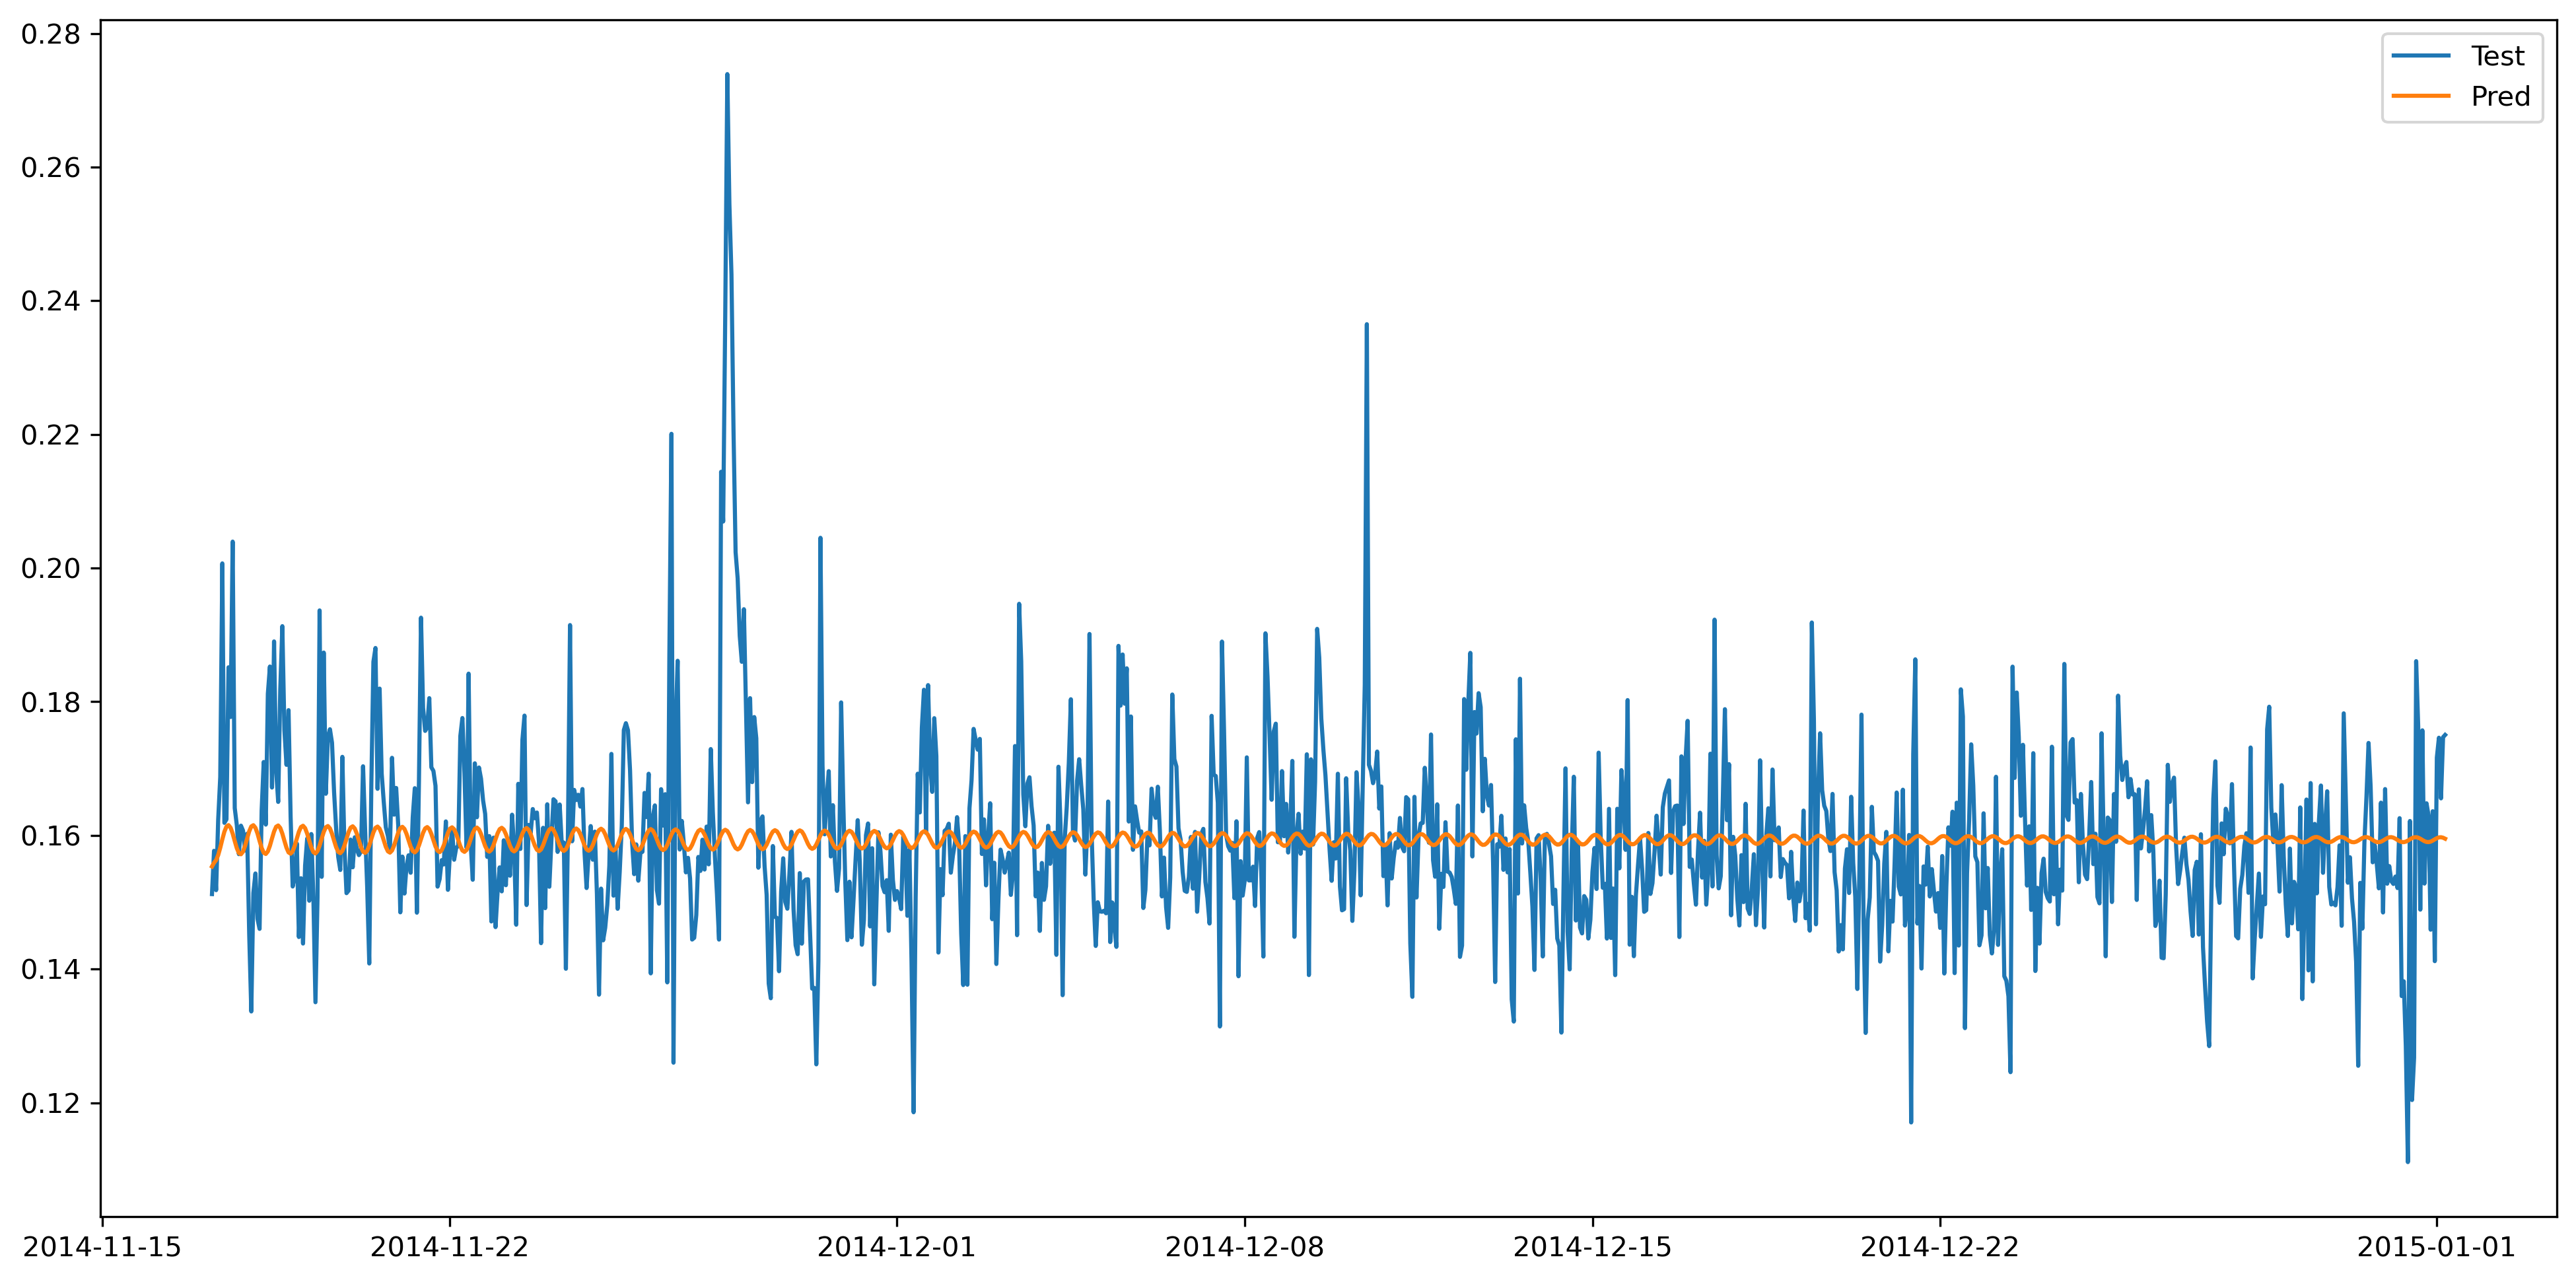

In [78]:
pred = arima304.predict(start=len(listOfTrainData_Simple_Models[0]), end=len(listOfTrainData_Simple_Models[0])+len(listOfTestData_Simple_Models[0])-1)
pred.index = listOfTestData_Simple_Models[0].index
pred
plt.figure(figsize=(16,8), dpi=300)
plt.plot(listOfTestData_Simple_Models[0], label='Test')
plt.plot(pred, label='Pred')
plt.legend()

In [79]:
auto_arima1 = auto_arima(listOfTrainData_Simple_Models[0], d=0, max_d=3, trace=True,
                         supress_warnings=True, stepwise=False
)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=-24534.196, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=-25387.889, Time=0.65 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=-25669.148, Time=0.90 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=-25755.866, Time=1.54 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=-25768.964, Time=1.60 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=-25768.397, Time=1.78 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=-25712.256, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=-25728.298, Time=2.17 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=-25754.695, Time=0.57 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=-25757.393, Time=1.66 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=-25758.079, Time=2.09 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=-25734.511, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=-25739.347, Time=1.66 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=-25735.522, Time=1.95 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=-25770

In [80]:
auto_arima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4267
Model:               SARIMAX(5, 0, 0)   Log Likelihood               12894.663
Date:                Wed, 11 May 2022   AIC                         -25775.326
Time:                        22:56:31   BIC                         -25730.815
Sample:                             0   HQIC                        -25759.599
                               - 4267                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0888      0.003     30.435      0.000       0.083       0.094
ar.L1          0.4525      0.010     46.725      0.000       0.433       0.471
ar.L2          0.1128      0.013      8.917      0.000       0.088       0.138
ar.L3         -0.0327      0.014     -2.275      0.023      -0.061      -0.005
ar.L4         -0.0534      0.016     -3.401      0.001      -0.084      -0.023
ar.L5         -0.0362      0.017     -2.159      0.031      -0.069      -0.003
sigma2         0.0001   1.73e-06     80.003      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5384.59
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [81]:
arima500=ARIMA(listOfTrainData_Simple_Models[0], order=(5,0,0))
arima500 = arima500.fit()
arima500.summary()

C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency i

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    pos   No. Observations:                 4267
Model:                     ARMA(5, 0)   Log Likelihood               12894.664
Method:                       css-mle   S.D. of innovations              0.012
Date:                Wed, 11 May 2022   AIC                         -25775.327
Time:                        22:56:36   BIC                         -25730.816
Sample:                             0   HQIC                        -25759.601
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1594      0.000    492.198      0.000       0.159       0.160
ar.L1.pos      0.4523      0.015     29.567      0.000       0.422       0.482
ar.L2.pos      0.1128      0.017      6.723      0.000       0.080       0.146
ar.L3.pos     -0.0327      0.017     -1.941      0.052      -0.066       0.000
ar.L4.pos     -0.0534      0.017     -3.182      0.001      -0.086      -0.020
ar.L5.pos     -0.0362      0.015     -2.366      0.018      -0.066      -0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3092           -0.6863j            1.4781           -0.0768
AR.2            1.3092           +0.6863j            1.4781            0.0768
AR.3           -2.3645           -0.0000j            2.3645           -0.5000
AR.4           -0.8643           -2.1452j            2.3127           -0.3110
AR.5           -0.8643           +2.1452j            2.3127            0.3110
-----------------------------------------------------------------------------
"""

C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


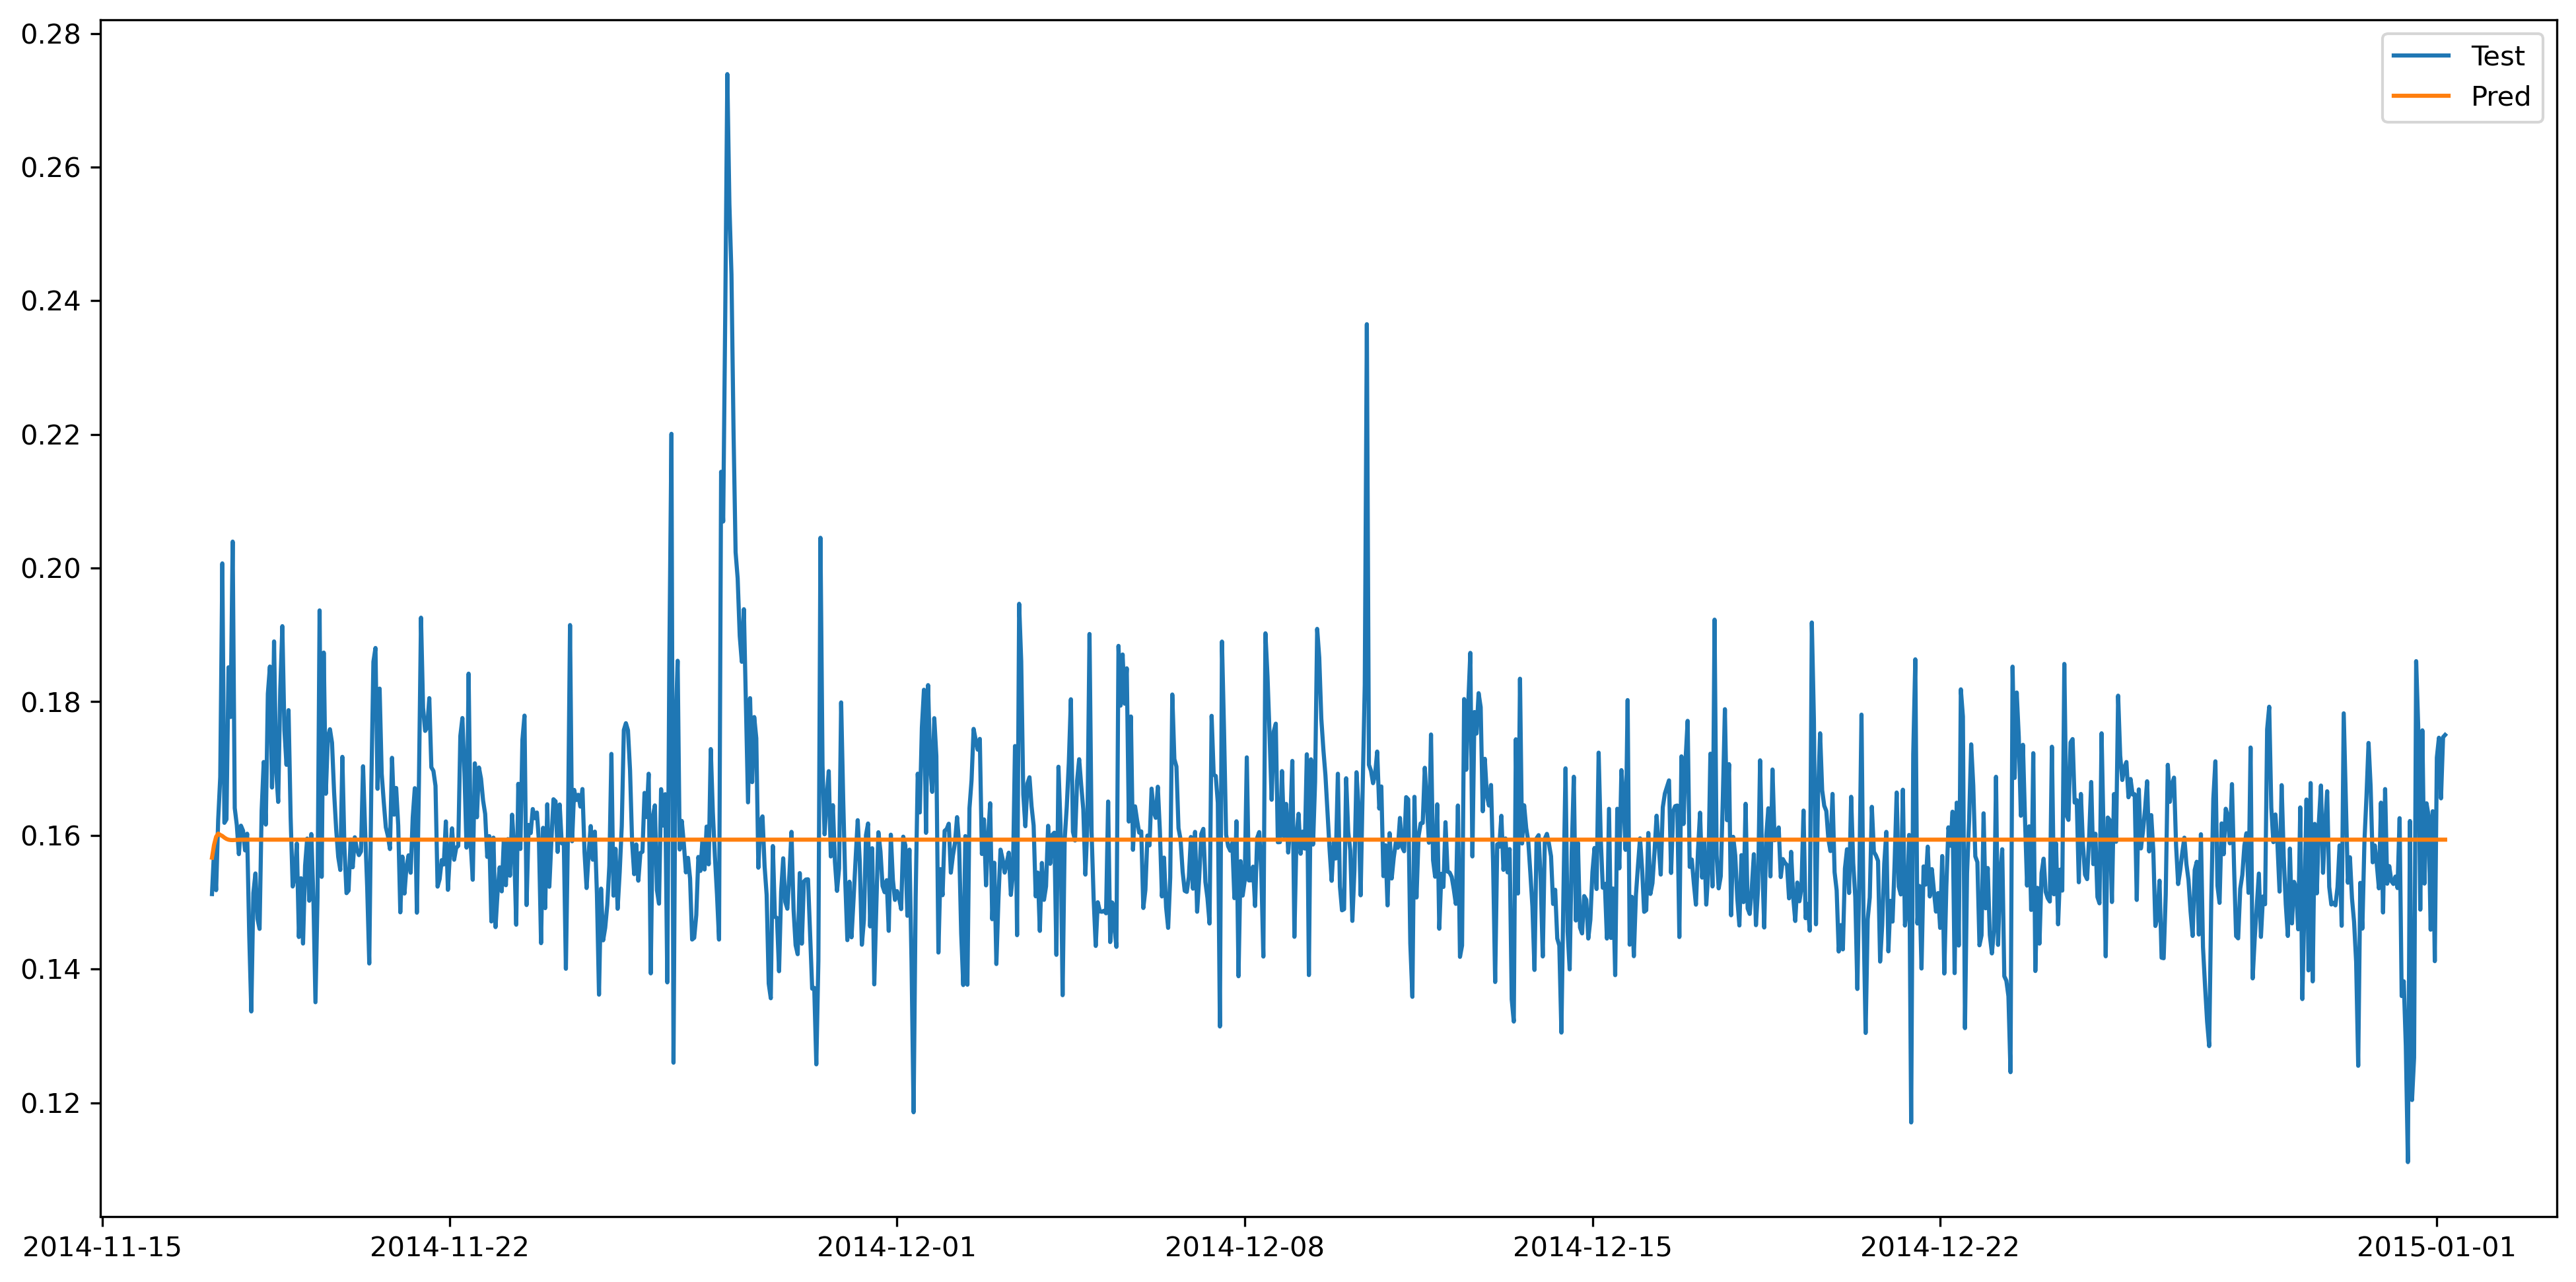

In [82]:
pred = arima500.predict(start=len(listOfTrainData_Simple_Models[0]), end=len(listOfTrainData_Simple_Models[0])+len(listOfTestData_Simple_Models[0])-1)
pred.index = listOfTestData_Simple_Models[0].index
pred
plt.figure(figsize=(16,8), dpi=300)
plt.plot(listOfTestData_Simple_Models[0], label='Test')
plt.plot(pred, label='Pred')
plt.legend()

# Execute ARIMA Models Easily

In [84]:
arima304=ARIMA(listOfTrainData_Simple_Models[0], order=(3,0,4))
arima304 = arima304.fit()
pred = arima304.predict(start=len(listOfTrainData_Simple_Models[0]), end=len(listOfTrainData_Simple_Models[0])+len(listOfTestData_Simple_Models[0])-1)
pred.index = listOfTestData_Simple_Models[i].index
print(len(pred))


C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency i

1080


C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [85]:
listOfARIMA304Prediction = [None]*8
for i in range(0,len(listOfARIMA304Prediction)):
    arima304=ARIMA(listOfTrainData_Simple_Models[i], order=(3,0,4))
    arima304 = arima304.fit()
    pred = arima304.predict(start=len(listOfTrainData_Simple_Models[i]), end=len(listOfTrainData_Simple_Models[i])+len(listOfTestData_Simple_Models[i])-1)
    pred.index = listOfTestData_Simple_Models[i].index
    print(len(pred))
    listOfARIMA304Prediction[i]=pred

C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency i

1080
1080


C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will 

1080


C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will 

1080


C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency i

1080
1080


C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will 

1080


C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will 

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [86]:
listOfARIMA304Prediction

[2014-11-17 05:00:00    0.155345
 2014-11-17 06:00:00    0.155898
 2014-11-17 07:00:00    0.156295
 2014-11-17 08:00:00    0.157049
 2014-11-17 09:00:00    0.158145
                          ...   
 2015-01-01 00:00:00    0.159582
 2015-01-01 01:00:00    0.159697
 2015-01-01 02:00:00    0.159721
 2015-01-01 03:00:00    0.159649
 2015-01-01 04:00:00    0.159499
 Length: 1080, dtype: float64,
 2014-11-17 05:00:00    0.156362
 2014-11-17 06:00:00    0.158202
 2014-11-17 07:00:00    0.159256
 2014-11-17 08:00:00    0.159588
 2014-11-17 09:00:00    0.159493
                          ...   
 2015-01-01 00:00:00    0.159466
 2015-01-01 01:00:00    0.159466
 2015-01-01 02:00:00    0.159466
 2015-01-01 03:00:00    0.159466
 2015-01-01 04:00:00    0.159466
 Length: 1080, dtype: float64,
 2014-11-17 05:00:00    0.156097
 2014-11-17 06:00:00    0.157792
 2014-11-17 07:00:00    0.158665
 2014-11-17 08:00:00    0.158918
 2014-11-17 09:00:00    0.158796
                          ...   
 2015-01-01 00

In [87]:
listOfARIMA500Prediction = [None]*8
for i in range(0,len(listOfARIMA500Prediction)):
    arima500=ARIMA(listOfTrainData_Simple_Models[i], order=(5,0,0))
    arima500 = arima500.fit()
    pred = arima500.predict(start=len(listOfTrainData_Simple_Models[i]), end=len(listOfTrainData_Simple_Models[i])+len(listOfTestData_Simple_Models[i])-1)
    pred.index = listOfTestData_Simple_Models[i].index
    listOfARIMA500Prediction[i]=pred

C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Sami\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency i

In [88]:
listOfARIMA500Prediction

[2014-11-17 05:00:00    0.156659
 2014-11-17 06:00:00    0.158571
 2014-11-17 07:00:00    0.159784
 2014-11-17 08:00:00    0.160269
 2014-11-17 09:00:00    0.160066
                          ...   
 2015-01-01 00:00:00    0.159359
 2015-01-01 01:00:00    0.159359
 2015-01-01 02:00:00    0.159359
 2015-01-01 03:00:00    0.159359
 2015-01-01 04:00:00    0.159359
 Length: 1080, dtype: float64,
 2014-11-17 05:00:00    0.156214
 2014-11-17 06:00:00    0.158115
 2014-11-17 07:00:00    0.159104
 2014-11-17 08:00:00    0.159255
 2014-11-17 09:00:00    0.159476
                          ...   
 2015-01-01 00:00:00    0.159468
 2015-01-01 01:00:00    0.159468
 2015-01-01 02:00:00    0.159468
 2015-01-01 03:00:00    0.159468
 2015-01-01 04:00:00    0.159468
 Length: 1080, dtype: float64,
 2014-11-17 05:00:00    0.155507
 2014-11-17 06:00:00    0.157139
 2014-11-17 07:00:00    0.157682
 2014-11-17 08:00:00    0.157453
 2014-11-17 09:00:00    0.157926
                          ...   
 2015-01-01 00

# Fill-up the Performance Table with ARIMA Models' Data

In [89]:
for dataIndex in range(0,8):
    entryTable = pd.DataFrame(columns=['Algorithm', 'R-squared', 'MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'ME', 'MPE'])
    listOfAlgoNames = ['ARIMA(5,0,0)', 'ARIMA(3,0,4)']
    listOfPredictedSets = [listOfARIMA500Prediction, listOfARIMA304Prediction]
    for i in range(0, len(listOfAlgoNames)):
        if(listOfAlgoNames[i]=='ARIMA(3,0,4)' and dataIndex==7):
            pass
        else:
            entry = performanceMetricsEntryGenerator(listOfTestTarget_Regressions[dataIndex], listOfPredictedSets[i][dataIndex], 0, listOfAlgoNames[i])
            entryTable = entryTable.append(entry, ignore_index=True)
    performanceTable[2][dataIndex] = entryTable

In [90]:
performanceTable[2][0]

Algorithm  R-squared       MAE      MAPE       MSE      RMSE     NRMSE  \
0  ARIMA(5,0,0)   0.000384  0.009754  0.060640  0.000196  0.014013  0.087974   
1  ARIMA(3,0,4)   0.013218  0.009705  0.060355  0.000194  0.013922  0.087407   

         ME       MPE  
0 -0.000076 -0.007596  
1 -0.000068 -0.007491

In [91]:
for idxAr in range(0, len(performanceTable[2])):
    print(namesOfPerformanceTableLayer2[idxAr])
    bestPerformer(performanceTable[2][idxAr])
    print('\n')

Positive Data (allows missing values)
R-squared => ARIMA(3,0,4) 0.013218352308989934 1
MAE => ARIMA(3,0,4) 0.009704691405671444 1
MAPE => ARIMA(3,0,4) 0.060354959353717 1
MSE => ARIMA(3,0,4) 0.00019383304080340395 1
RMSE => ARIMA(3,0,4) 0.013922393501241227 1
NRMSE => ARIMA(3,0,4) 0.08740738280174648 1
ME => ARIMA(3,0,4) -6.82529276440361e-05 1
MPE => ARIMA(3,0,4) -0.007490592116510907 1


Positive Data (missing value handled through interpolation)
R-squared => ARIMA(5,0,0) 8.516434531746775e-05 0
MAE => ARIMA(5,0,0) 0.009767550392867749 0
MAPE => ARIMA(5,0,0) 0.06076489940175578 0
MSE => ARIMA(5,0,0) 0.00019641278654999127 0
RMSE => ARIMA(5,0,0) 0.014014734622888558 0
NRMSE => ARIMA(5,0,0) 0.08798711758423565 0
ME => ARIMA(3,0,4) -0.00016378978416259923 1
MPE => ARIMA(3,0,4) -0.008153957622558964 1


Positive Data (missing value handled through forward fill)
R-squared => ARIMA(5,0,0) -0.0021498364938292713 0
MAE => ARIMA(5,0,0) 0.00969859124038049 0
MAPE => ARIMA(5,0,0) 0.060032228434

# Fill-up the Calc_Friendly Performance Table with ARIMA Models' Data

In [92]:
entryTable = pd.DataFrame(columns=['Algorithm', 'Data', 'R-squared', 'MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'ME', 'MPE'])
data = ['Positive Data (allows missing values)', 'Positive Data (missing value handled through interpolation)', 'Positive Data (missing value handled through forward fill)', 'Positive Data (missing value handled through backward fill)', 'Negative Data (allows missing values)', 'Negative Data (missing value handled through interpolation)', 'Negative Data (missing value handled through forward fill)', 'Negative Data (missing value handled through backward fill)']
for dataIndex in range(0,8):
    listOfAlgoNames = ['ARIMA(5,0,0)', 'ARIMA(3,0,4)']
    listOfPredictedSets = [listOfARIMA500Prediction, listOfARIMA304Prediction]
    for i in range(0, len(listOfAlgoNames)):
        if(listOfAlgoNames[i]=='ARIMA(3,0,4)' and dataIndex==7):
            pass
        else:
            entry = performanceMetricsEntryGenerator(listOfTestData_Simple_Models[dataIndex], listOfPredictedSets[i][dataIndex], 0, listOfAlgoNames[i], data[dataIndex])
            entryTable = entryTable.append(entry, ignore_index=True) 
performanceTableCalcFriendly[2] = entryTable

In [93]:
performanceTableCalcFriendly[2]

Algorithm                                               Data  \
0   ARIMA(5,0,0)              Positive Data (allows missing values)   
1   ARIMA(3,0,4)              Positive Data (allows missing values)   
2   ARIMA(5,0,0)  Positive Data (missing value handled through i...   
3   ARIMA(3,0,4)  Positive Data (missing value handled through i...   
4   ARIMA(5,0,0)  Positive Data (missing value handled through f...   
5   ARIMA(3,0,4)  Positive Data (missing value handled through f...   
6   ARIMA(5,0,0)  Positive Data (missing value handled through b...   
7   ARIMA(3,0,4)  Positive Data (missing value handled through b...   
8   ARIMA(5,0,0)              Negative Data (allows missing values)   
9   ARIMA(3,0,4)              Negative Data (allows missing values)   
10  ARIMA(5,0,0)  Negative Data (missing value handled through i...   
11  ARIMA(3,0,4)  Negative Data (missing value handled through i...   
12  ARIMA(5,0,0)  Negative Data (missing value handled through f...   
13  ARIMA(3,0,4)  Negative Data (missing value handled through f...   
14  ARIMA(5,0,0)  Negative Data (missing value handled through b...   

    R-squared       MAE      MAPE       MSE      RMSE     NRMSE        ME  \
0    0.000384  0.009754  0.060640  0.000196  0.014013  0.087974 -0.000076   
1    0.013218  0.009705  0.060355  0.000194  0.013922  0.087407 -0.000068   
2    0.000085  0.009768  0.060765  0.000196  0.014015  0.087987 -0.000181   
3   -0.000908  0.009772  0.060788  0.000197  0.014022  0.088031 -0.000164   
4   -0.002150  0.009699  0.060032  0.000197  0.014030  0.088085  0.000607   
5   -0.003177  0.009703  0.060054  0.000197  0.014038  0.088131  0.000622   
6   -0.004463  0.009889  0.061825  0.000197  0.014047  0.088187 -0.000963   
7   -0.005395  0.009893  0.061831  0.000197  0.014053  0.088228 -0.000922   
8   -0.003200  0.012417  0.036154  0.000287  0.016943 -0.049327 -0.000946   
9   -0.003085  0.012416  0.036151  0.000287  0.016942 -0.049324 -0.000947   
10  -0.004648  0.012427  0.036162  0.000287  0.016955 -0.049363 -0.001141   
11  -0.004588  0.012426  0.036161  0.000287  0.016954 -0.049361 -0.001142   
12  -0.006175  0.012436  0.036172  0.000288  0.016968 -0.049400 -0.001314   
13  -0.006179  0.012436  0.036172  0.000288  0.016968 -0.049400 -0.001314   
14  -0.003341  0.012418  0.036155  0.000287  0.016944 -0.049331 -0.000967   

         MPE  
0  -0.007596  
1  -0.007491  
2  -0.008261  
3  -0.008154  
4  -0.003281  
5  -0.003187  
6  -0.013204  
7  -0.012946  
8   0.000338  
9   0.000342  
10  0.000907  
11  0.000910  
12  0.001414  
13  0.001412  
14  0.000399

In [95]:
print('Positive Data Group')
bestPerformerCalcFriendly(performanceTableCalcFriendly[2][:len(performanceTableCalcFriendly[2])//2+1])
print('\n')
print('Negative Data Group')
bestPerformerCalcFriendly(performanceTableCalcFriendly[2][len(performanceTableCalcFriendly[2])//2+1:])

Positive Data Group
R-squared => ARIMA(3,0,4) => Positive Data (allows missing values) => 0.013218352308989934 => 1
MAE => ARIMA(5,0,0) => Positive Data (missing value handled through forward fill) => 0.00969859124038049 => 4
MAPE => ARIMA(5,0,0) => Positive Data (missing value handled through forward fill) => 0.06003222843433288 => 4
MSE => ARIMA(3,0,4) => Positive Data (allows missing values) => 0.00019383304080340395 => 1
RMSE => ARIMA(3,0,4) => Positive Data (allows missing values) => 0.013922393501241227 => 1
NRMSE => ARIMA(3,0,4) => Positive Data (allows missing values) => 0.08740738280174641 => 1
ME => ARIMA(3,0,4) => Positive Data (allows missing values) => -6.82529276440361e-05 => 1
MPE => ARIMA(3,0,4) => Positive Data (missing value handled through forward fill) => -0.0031868451083417073 => 5


Negative Data Group
R-squared => ARIMA(3,0,4) => Negative Data (allows missing values) => -0.0030851919844088194 => 9
MAE => ARIMA(3,0,4) => Negative Data (allows missing values) => 0.

# For positive data, ARIMA(3,0,4) tends to perform better with raw data whereas ARIMA(5,0,0) gets benefited if we use forward fill to handle missing values.

# For negative data, ARIMA (3,0,4) performs well with raw data.

In [96]:
#Final Thoughts?
len(performanceTable[0])

8

In [97]:
# Simple Positive Raw Naive
list(performanceTable[0][0].loc[0])

['Naive',
 -0.02205544329408138,
 0.009714643972222223,
 0.059576890298754404,
 0.00020076185537795508,
 0.014169045676331031,
 0.08895591115536865,
 0.0020814274037037075,
 0.00604485290978223]

In [98]:
# Regression Positive FFill Random Forest
list(performanceTable[1][2].loc[4])

['Random Forest Regression',
 0.2538386550720342,
 0.00858276079131929,
 0.05396173414479203,
 0.00014656811135043855,
 0.01210653176390491,
 0.07600706417289509,
 -0.0005402281521744149,
 -0.008733586724595347]

In [99]:
# ARIMA Positive Raw 304
list(performanceTable[2][0].loc[1])

['ARIMA(3,0,4)',
 0.013218352308989934,
 0.009704691405671444,
 0.060354959353717,
 0.00019383304080340395,
 0.013922393501241227,
 0.08740738280174648,
 -6.82529276440361e-05,
 -0.007490592116510907]

In [100]:
# ARIMA Positive FFill 500
list(performanceTable[2][2].loc[0])

['ARIMA(5,0,0)',
 -0.0021498364938292713,
 0.00969859124038049,
 0.06003222843433288,
 0.00019685180668161173,
 0.014030388686048998,
 0.08808539671209864,
 0.0006065718905610276,
 -0.003281259011869403]

In [101]:
#
#
# Simple Negative Raw Naive
list(performanceTable[0][4].loc[0])

['Naive',
 -0.0013962515967456124,
 0.012403671787037036,
 0.036148634112235366,
 0.00028653626757989503,
 0.0169273821833116,
 -0.0492827625480692,
 -0.0006320750685185061,
 -0.0005772428986620852]

In [102]:
# Regression Negative Interpolation Random Forest
list(performanceTable[1][5].loc[4])

['Random Forest Regression',
 -0.004947574659163179,
 0.012291549605372279,
 0.03572890629615516,
 0.0002875524316145147,
 0.016957371011289298,
 -0.04937007269870645,
 -0.000720463552102656,
 -0.00022177452749580885]

In [103]:
# ARIMA Negative Raw 304
list(performanceTable[2][4].loc[1])

['ARIMA(3,0,4)',
 -0.0030851919844088194,
 0.012415964413373547,
 0.036151354462914946,
 0.0002870195354911483,
 0.01694165090807706,
 -0.04932430483540366,
 -0.0009468719428619097,
 0.00034153367733387165]

In [ ]:
# The above data has been taken to excel and then reported on the presentation slide deck.

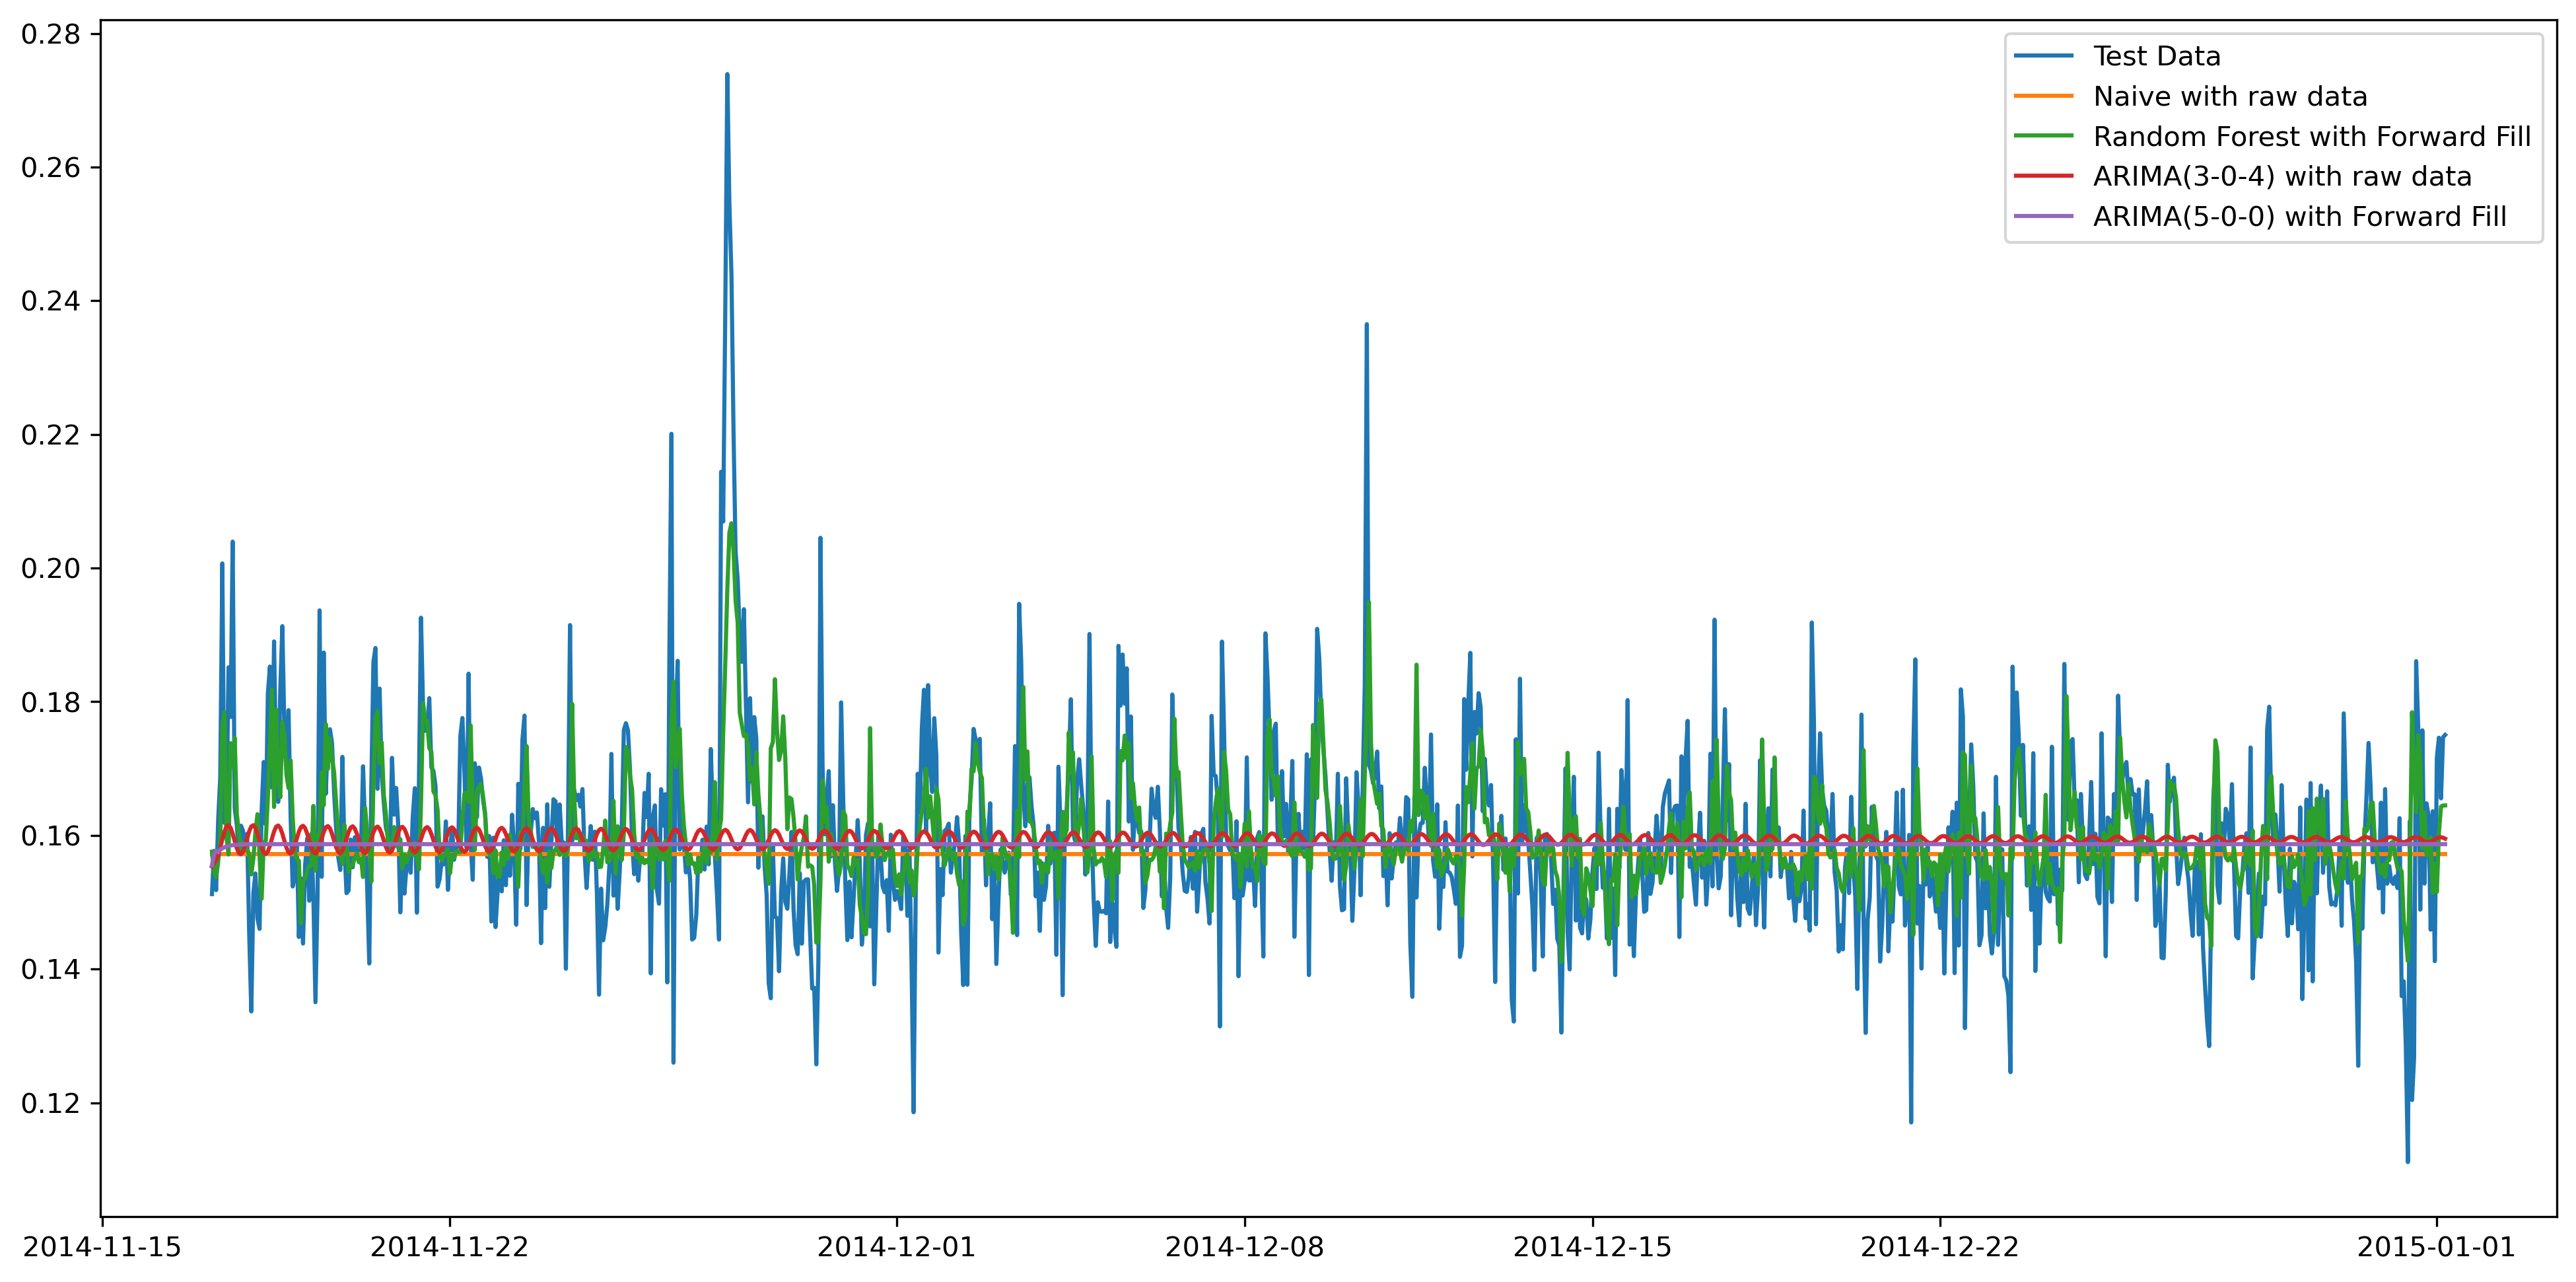

In [118]:
# Plot the positive best performers
plt.figure(figsize=(16,8), dpi=300)
plt.plot(listOfTestData_Simple_Models[0], label = 'Test Data')
plt.plot(listOfNaivePrediction[0], label = 'Naive with raw data')
plt.plot(pd.Series(listOfRFRegPrediction[2], index = listOfTestData_Simple_Models[2].index), label = 'Random Forest with Forward Fill')
plt.plot(listOfARIMA304Prediction[0], label = 'ARIMA(3-0-4) with raw data')
plt.plot(listOfARIMA500Prediction[2], label = 'ARIMA(5-0-0) with Forward Fill')
plt.legend()

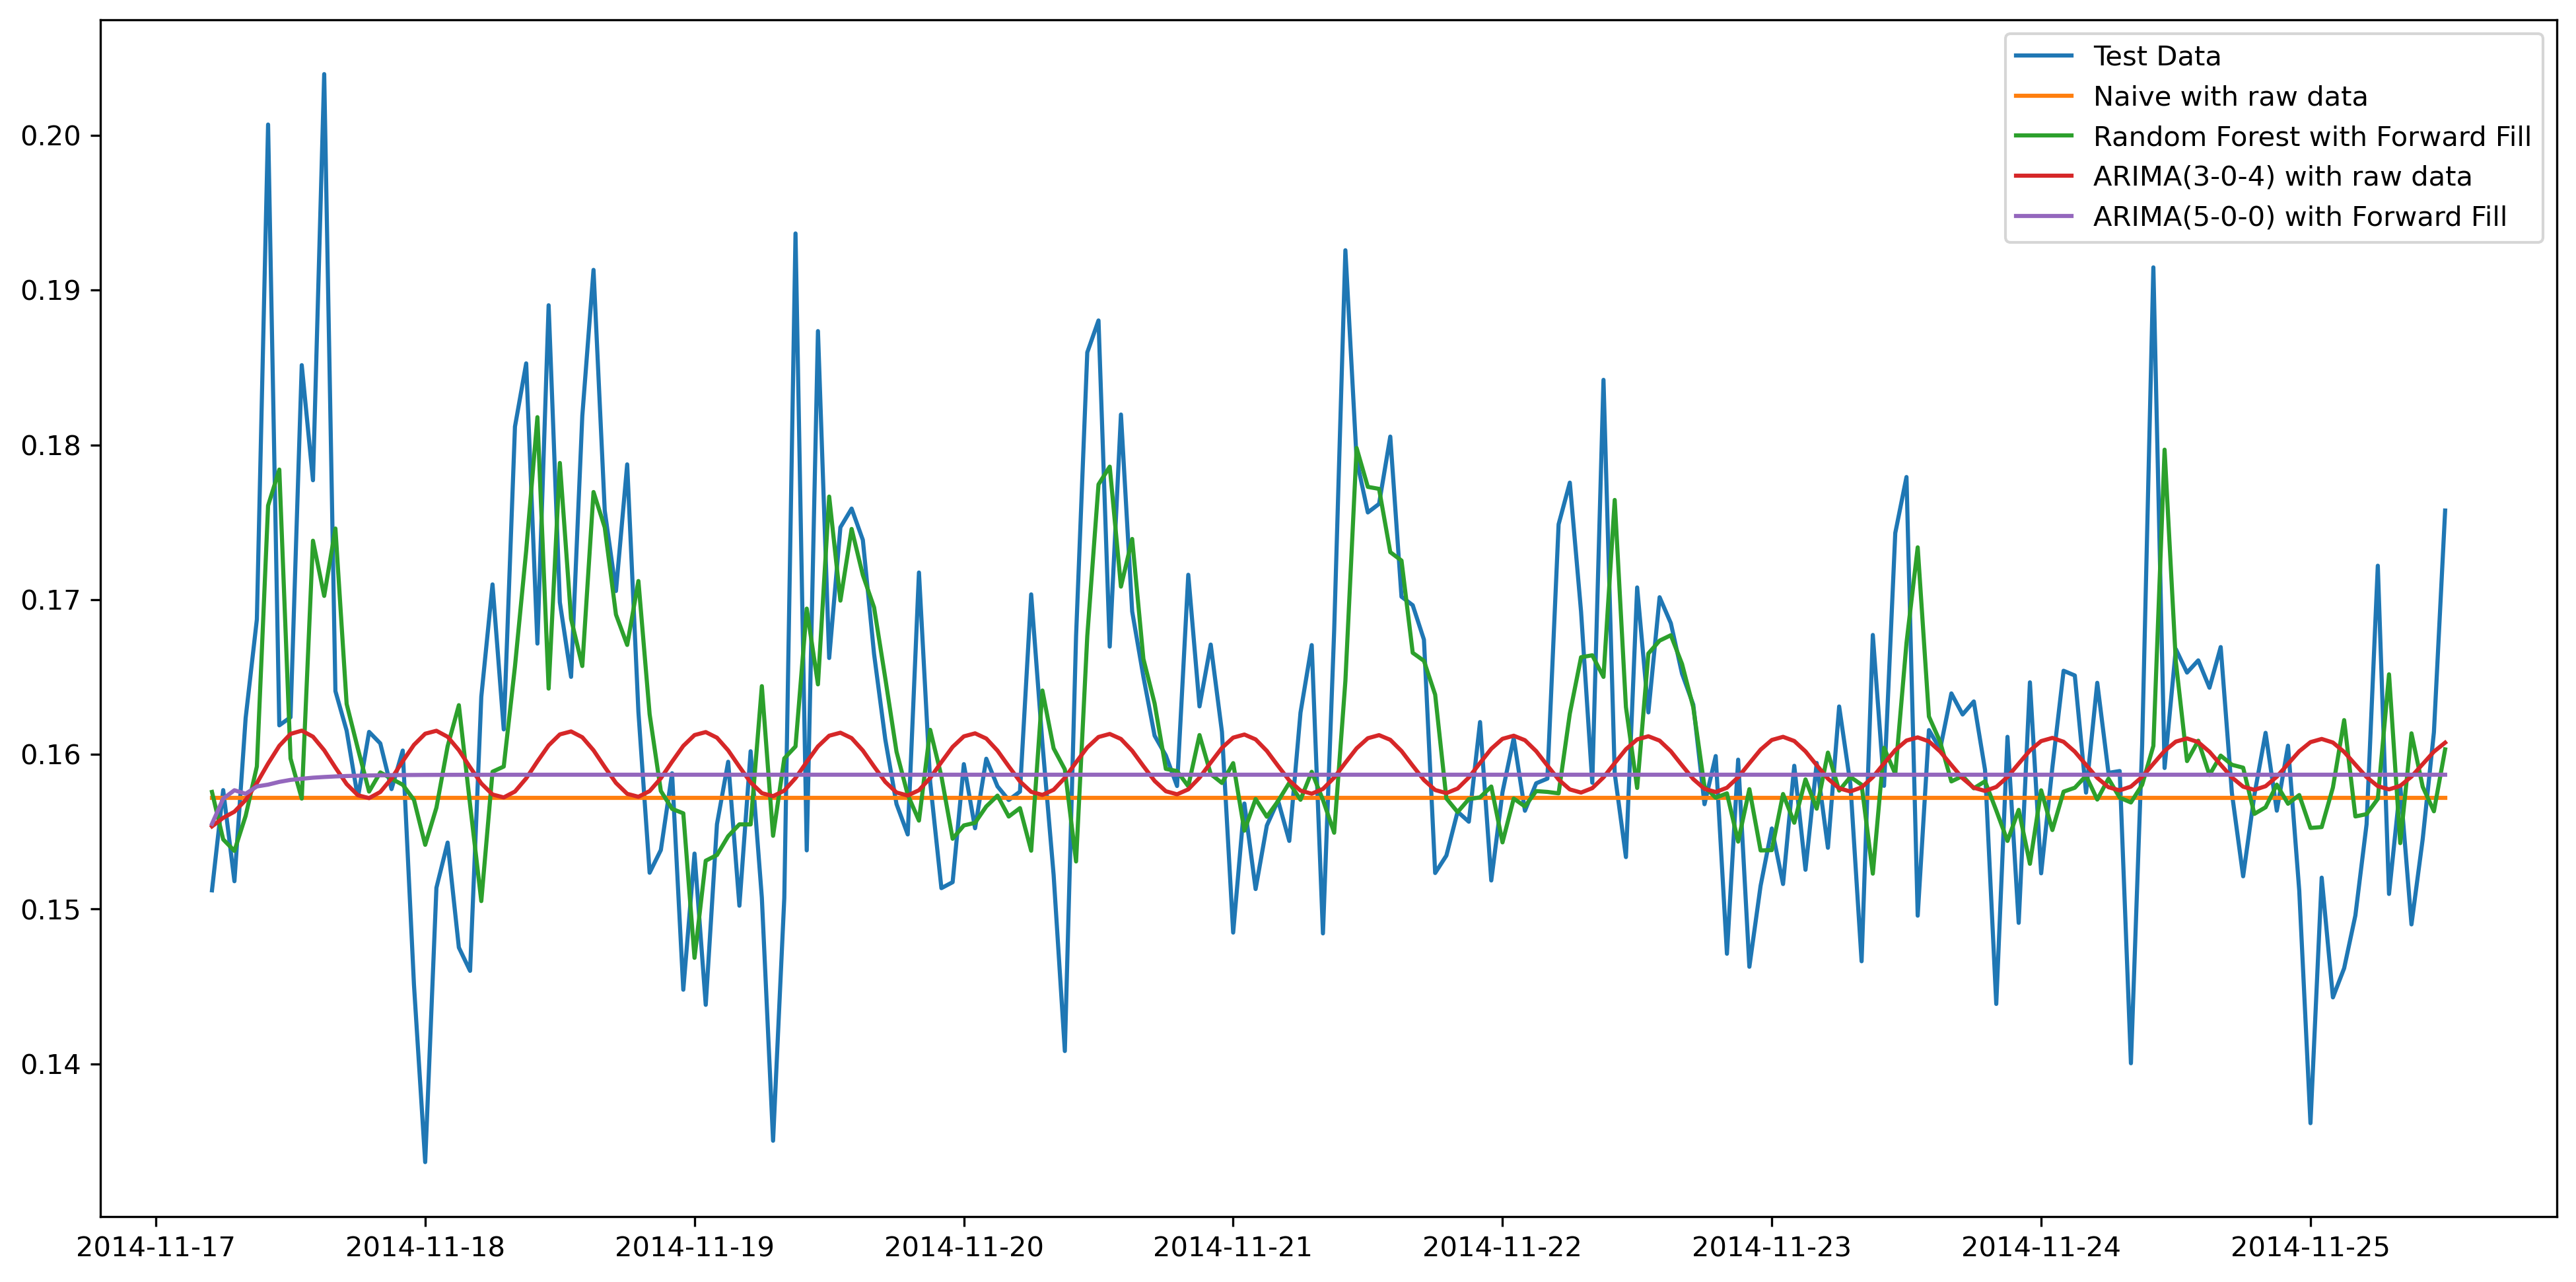

In [122]:
# Plot the positive best performers (First 200 predicted values)
plt.figure(figsize=(16,8), dpi=300)
plt.plot(listOfTestData_Simple_Models[0][:200], label = 'Test Data')
plt.plot(listOfNaivePrediction[0][:200], label = 'Naive with raw data')
plt.plot(pd.Series(listOfRFRegPrediction[2], index = listOfTestData_Simple_Models[2].index)[:200], label = 'Random Forest with Forward Fill')
plt.plot(listOfARIMA304Prediction[0][:200], label = 'ARIMA(3-0-4) with raw data')
plt.plot(listOfARIMA500Prediction[2][:200], label = 'ARIMA(5-0-0) with Forward Fill')
plt.legend()

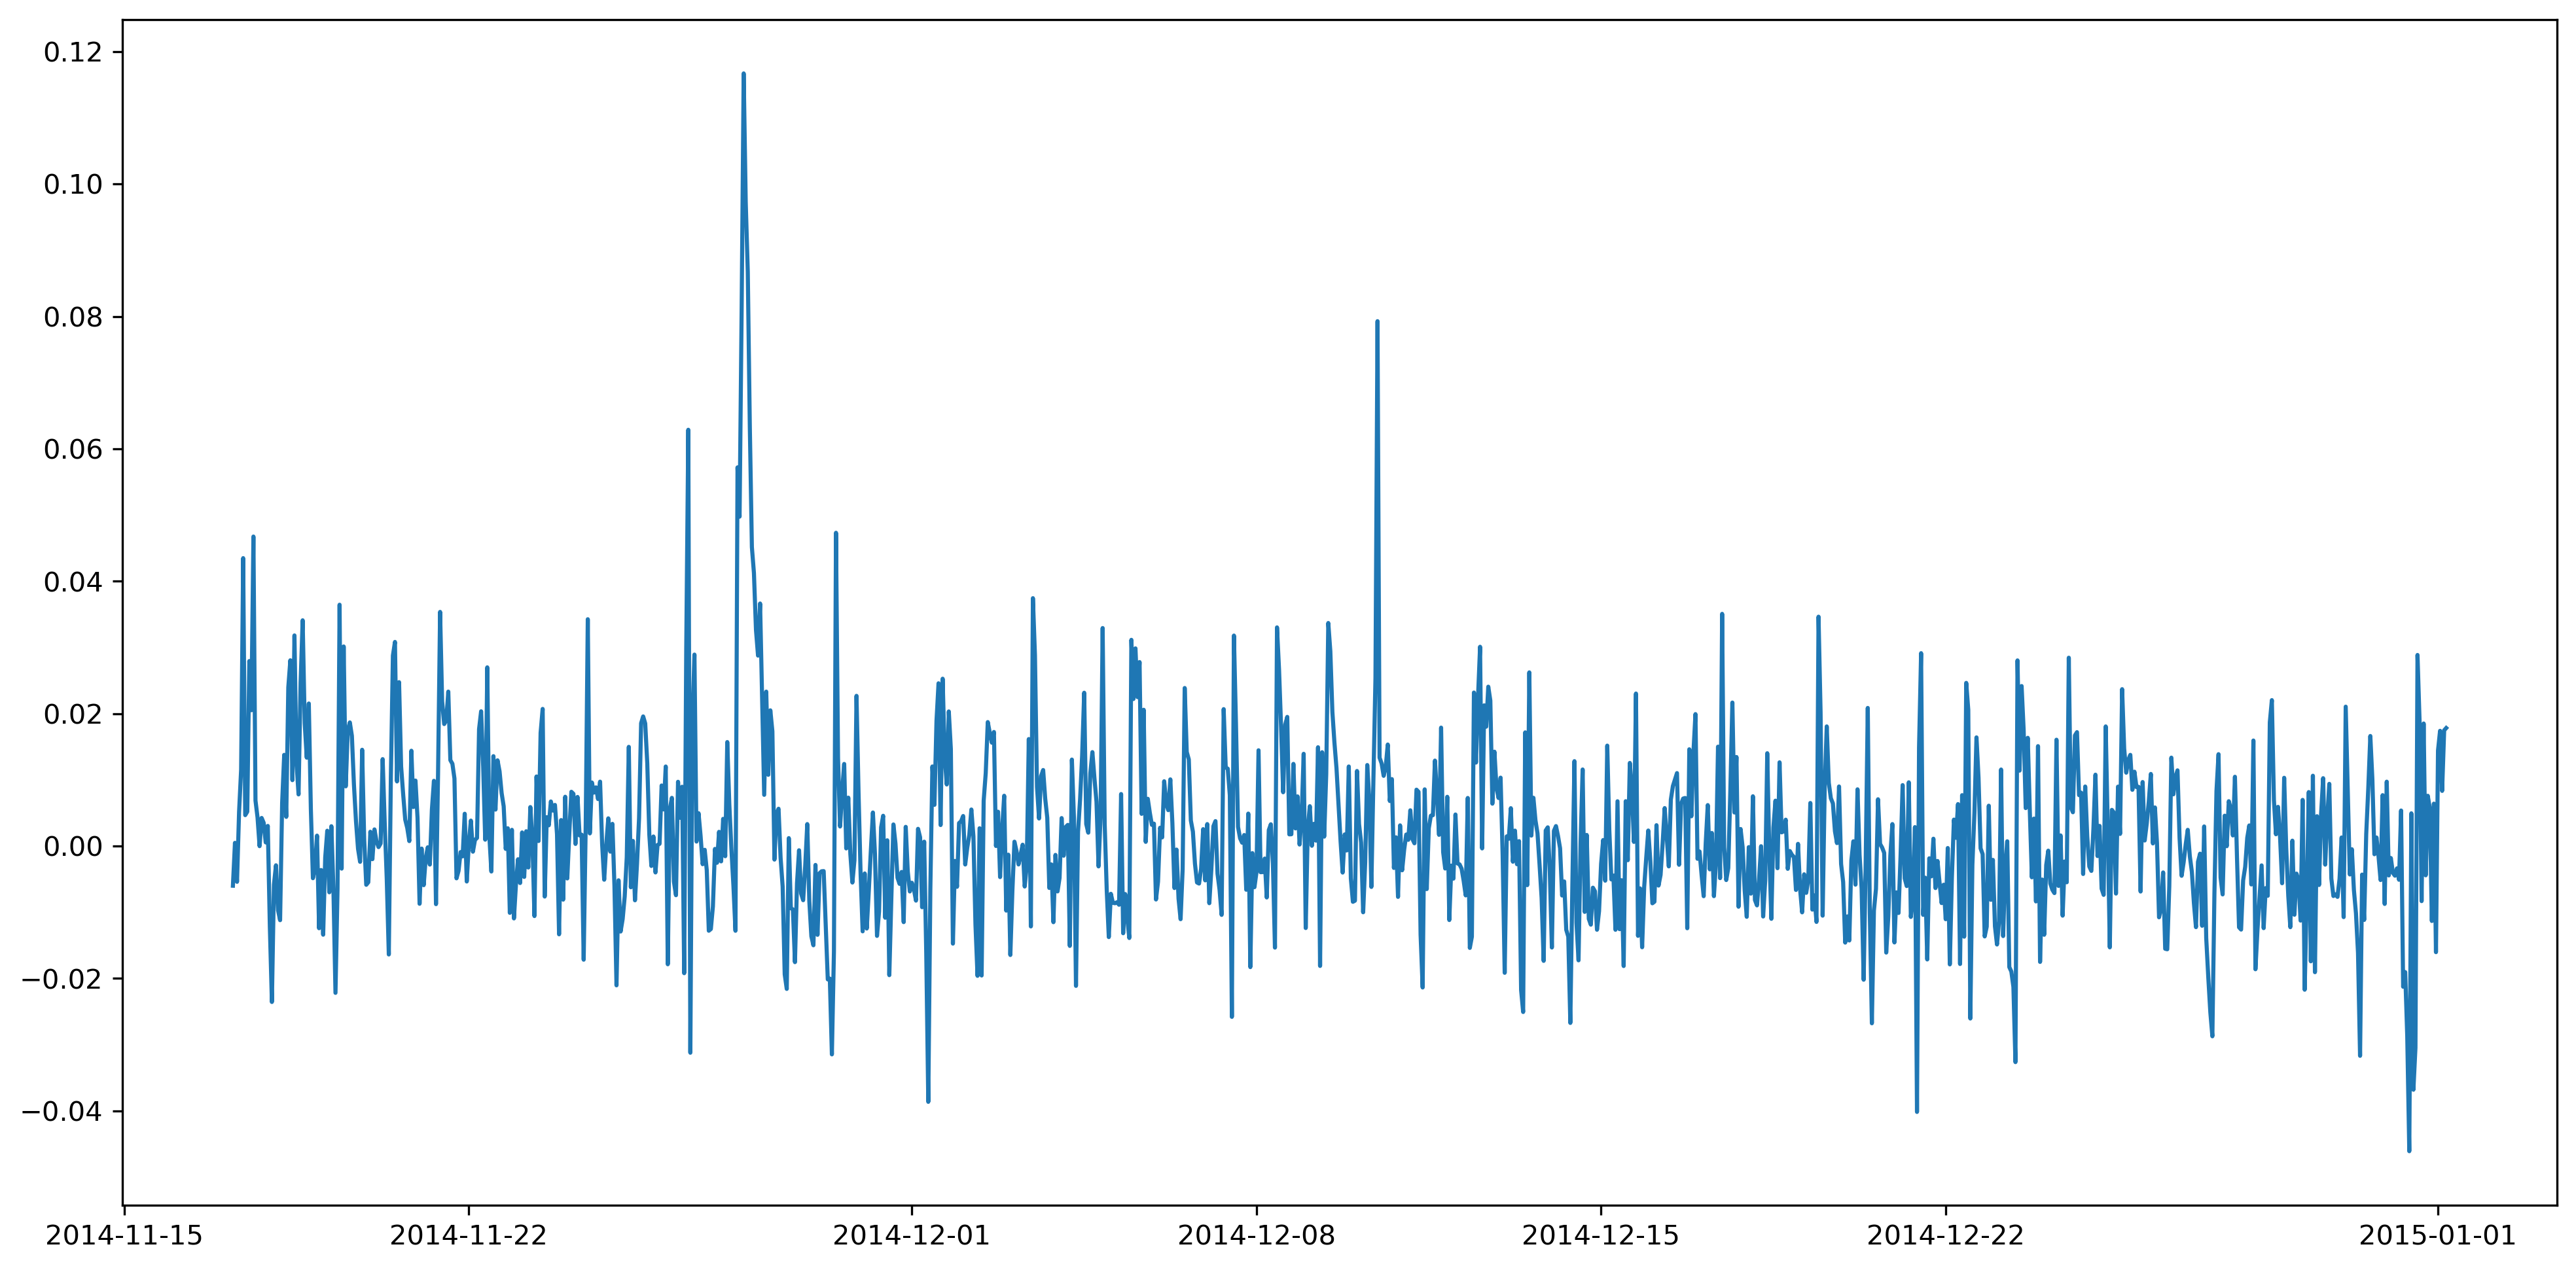

In [126]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(listOfTestData_Simple_Models[0]-listOfNaivePrediction[0])
plt.show()

Mean: 0.15934208692537866
Median: 0.158017043


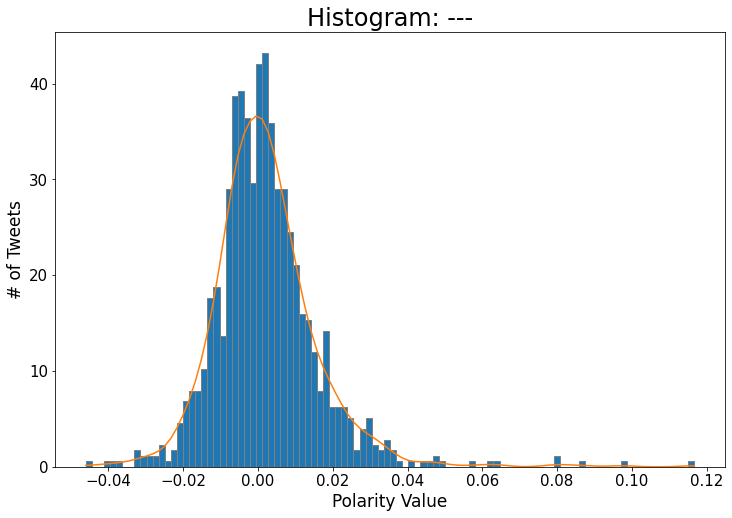

In [130]:
res = listOfTestData_Simple_Models[0]-listOfNaivePrediction[0]
density = stats.gaussian_kde(res)
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(res, 100, density=True, edgecolor='gray')
plt.plot(bins, density(bins))
plt.title('Histogram: ---', fontsize=24)
plt.xlabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel('# of Tweets', fontsize=17)
plt.yticks(fontsize=15)

print('Mean:', dataFr['pos'].mean())
print('Median:', dataFr['pos'].median())

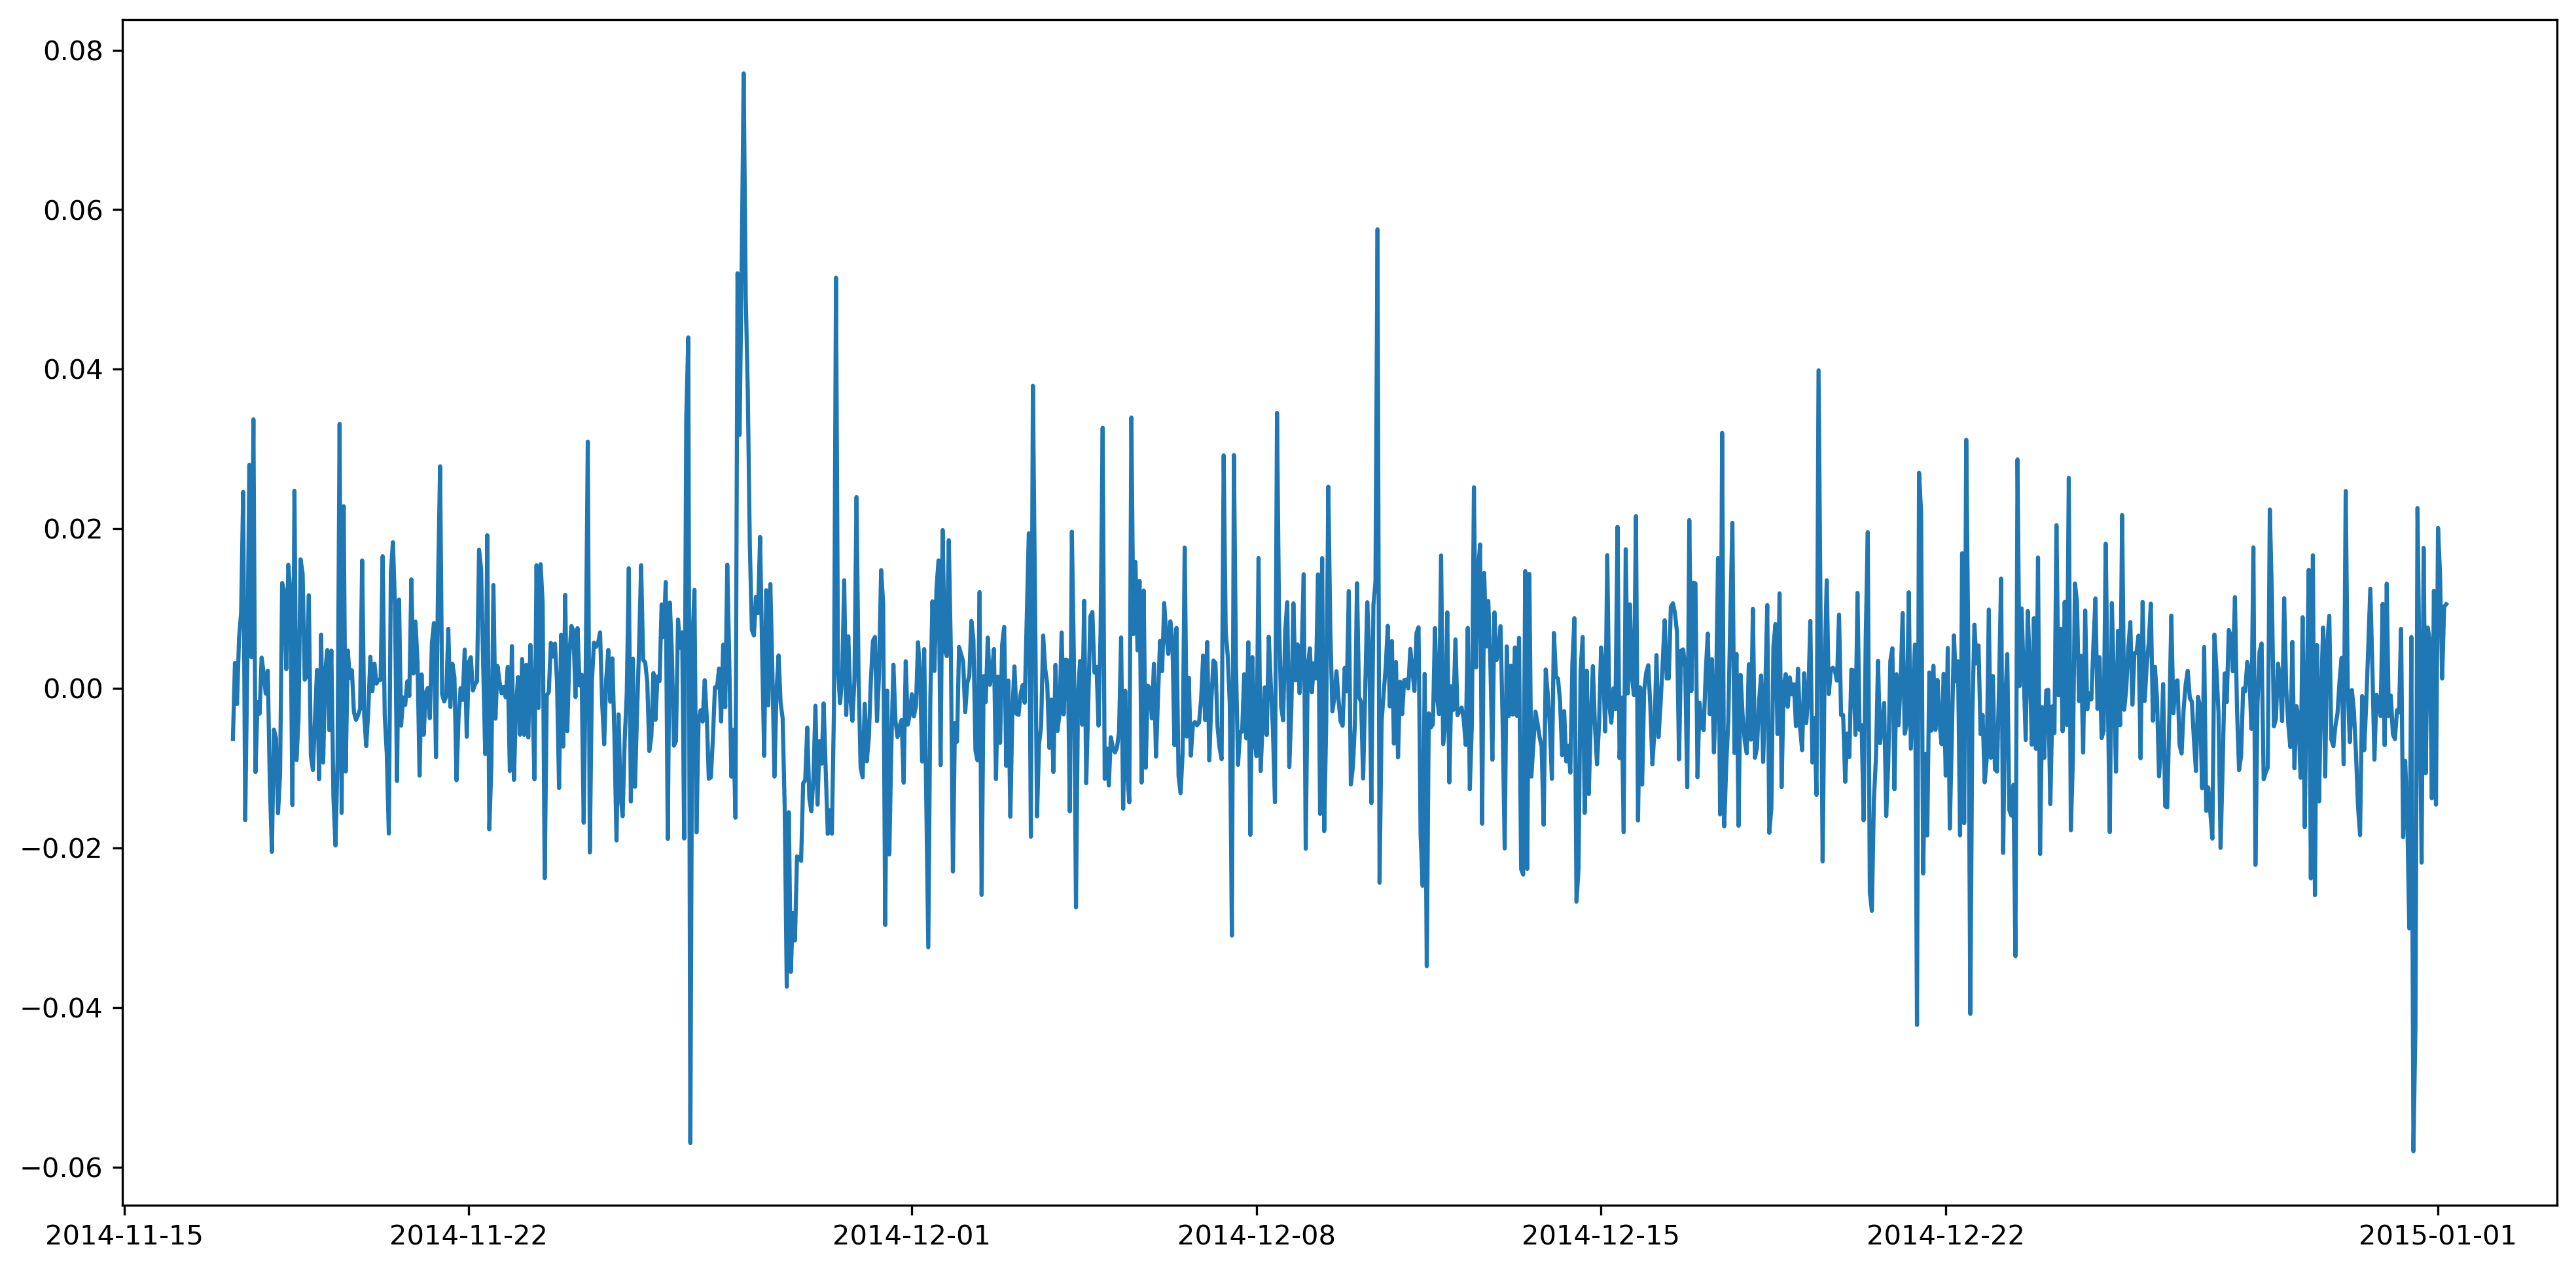

In [127]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(listOfTestData_Simple_Models[0]-pd.Series(listOfRFRegPrediction[2], index = listOfTestData_Simple_Models[2].index))
plt.show()

Mean: 0.15934208692537866
Median: 0.158017043


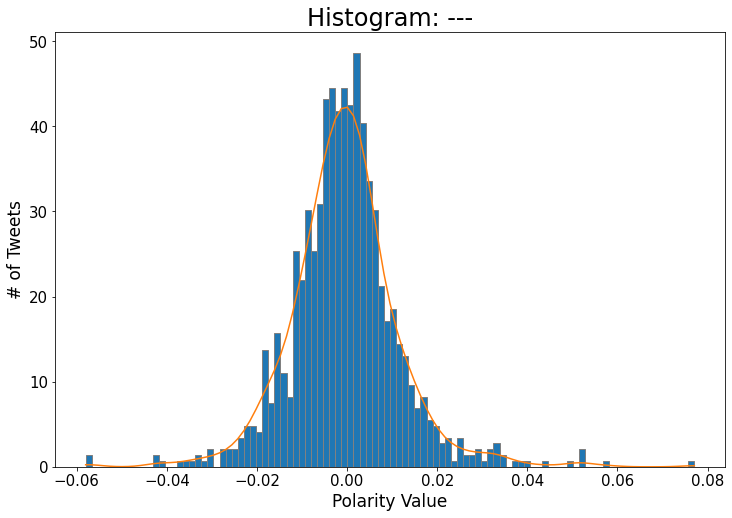

In [131]:
res = listOfTestData_Simple_Models[0]-pd.Series(listOfRFRegPrediction[2], index = listOfTestData_Simple_Models[2].index)
density = stats.gaussian_kde(res)
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(res, 100, density=True, edgecolor='gray')
plt.plot(bins, density(bins))
plt.title('Histogram: ---', fontsize=24)
plt.xlabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel('# of Tweets', fontsize=17)
plt.yticks(fontsize=15)

print('Mean:', dataFr['pos'].mean())
print('Median:', dataFr['pos'].median())

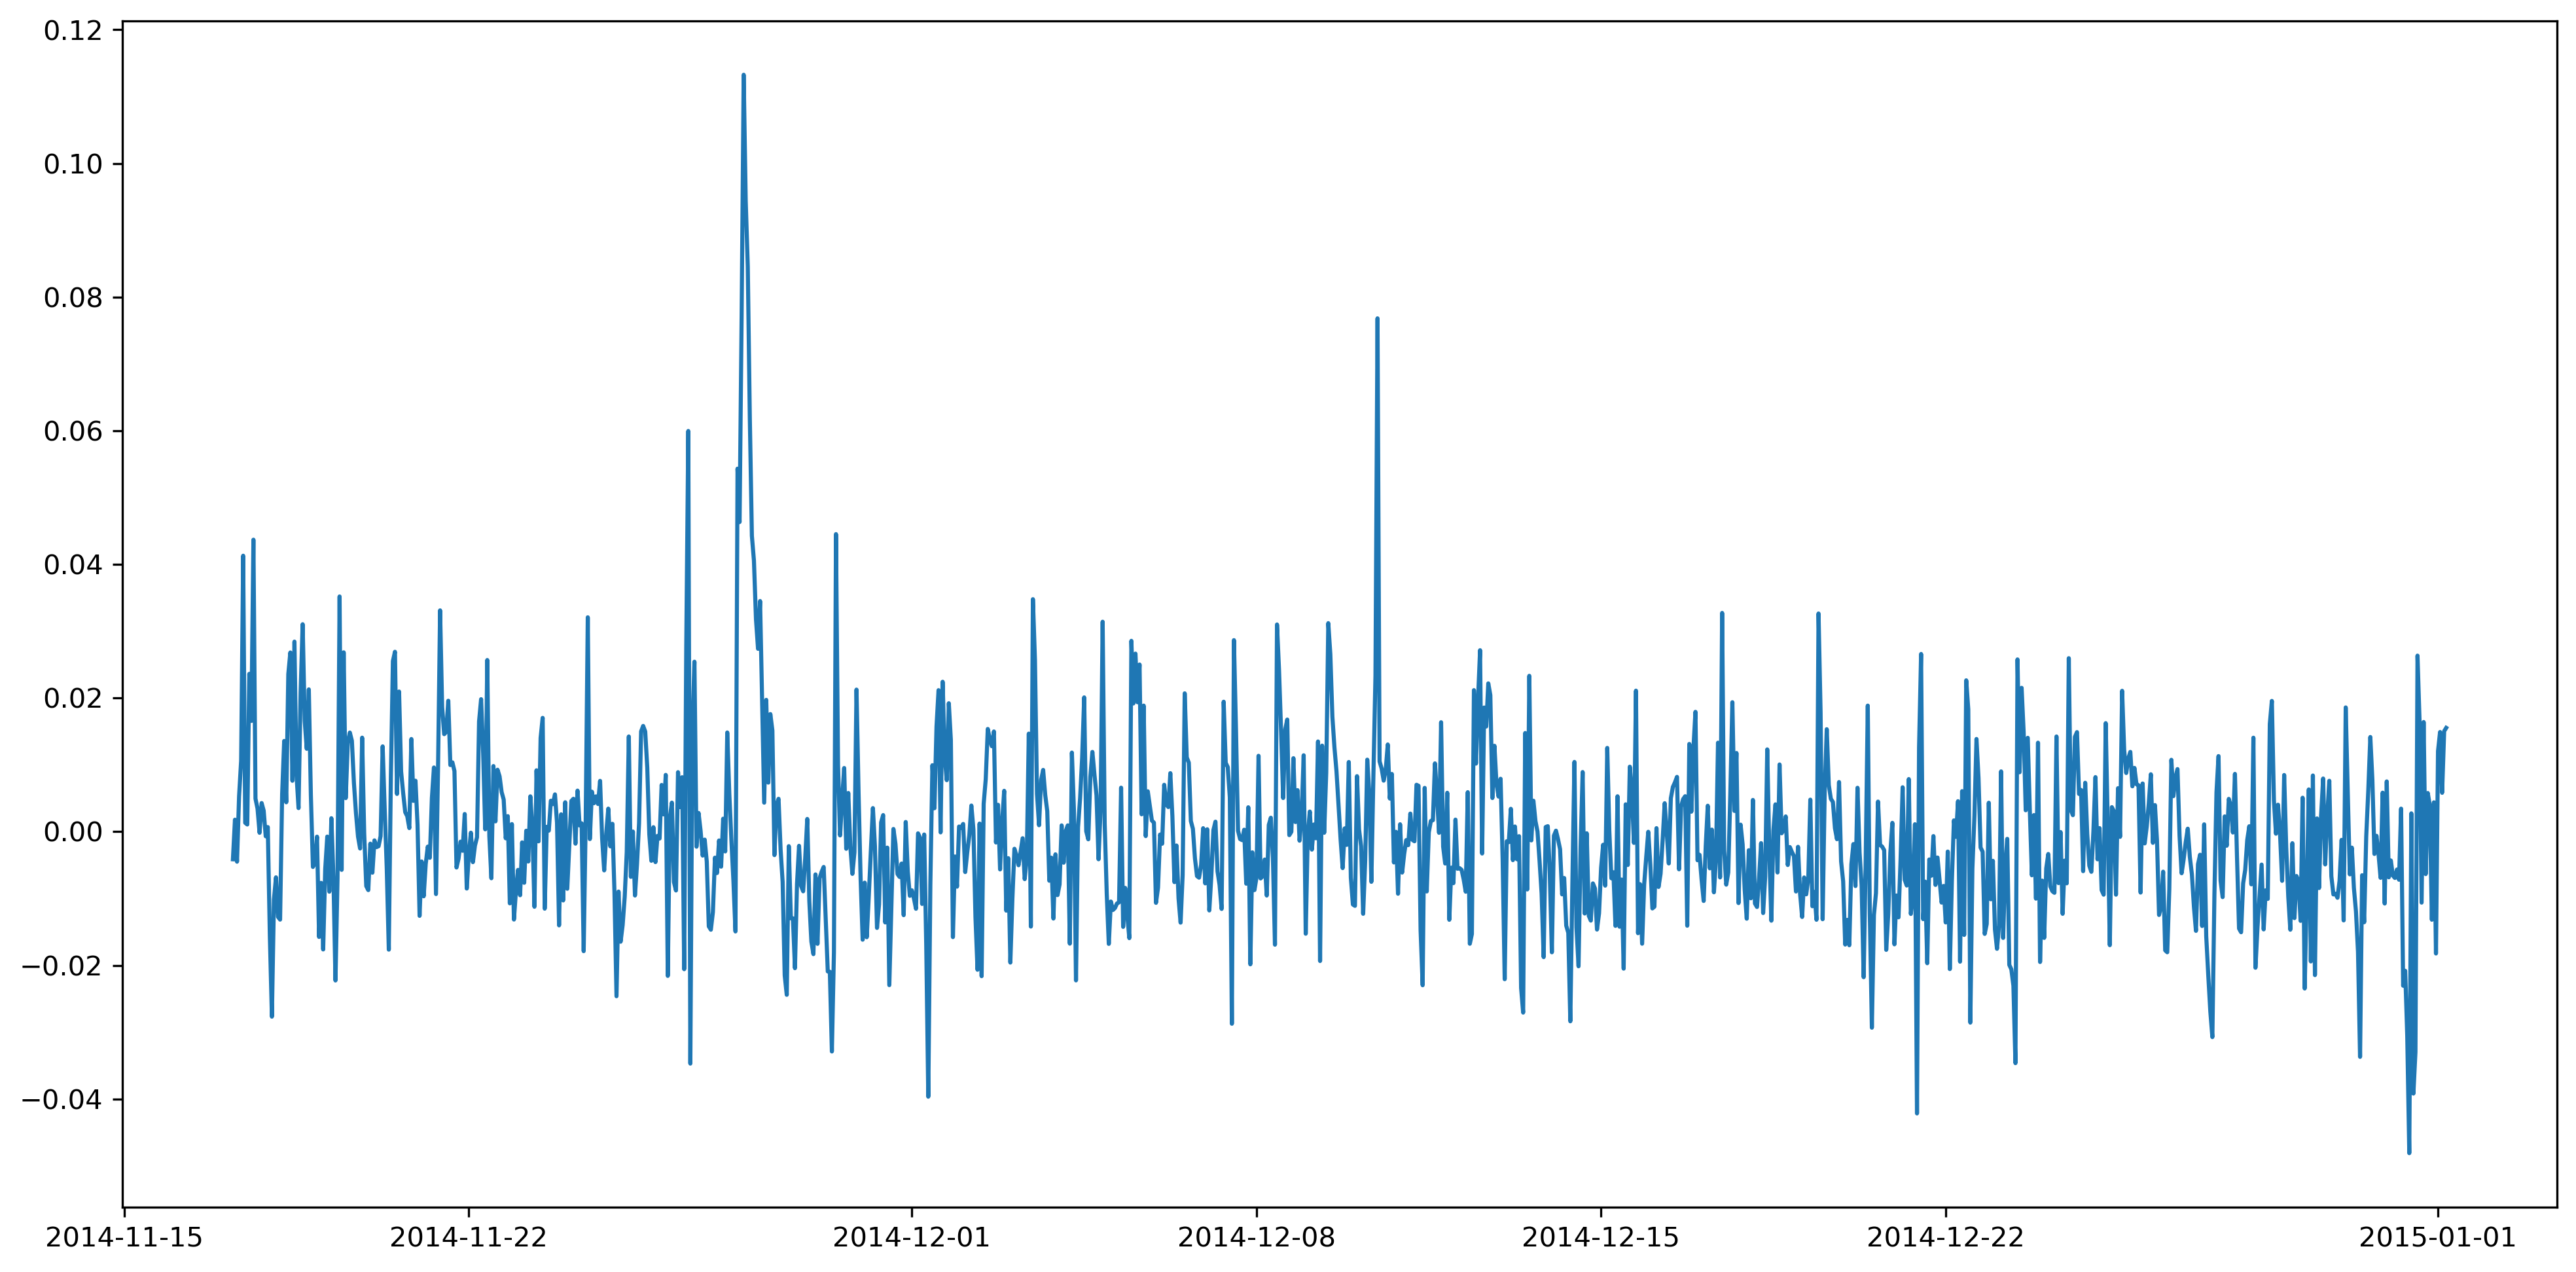

In [128]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(listOfTestData_Simple_Models[0]-listOfARIMA304Prediction[0])
plt.show()

Mean: 0.15934208692537866
Median: 0.158017043


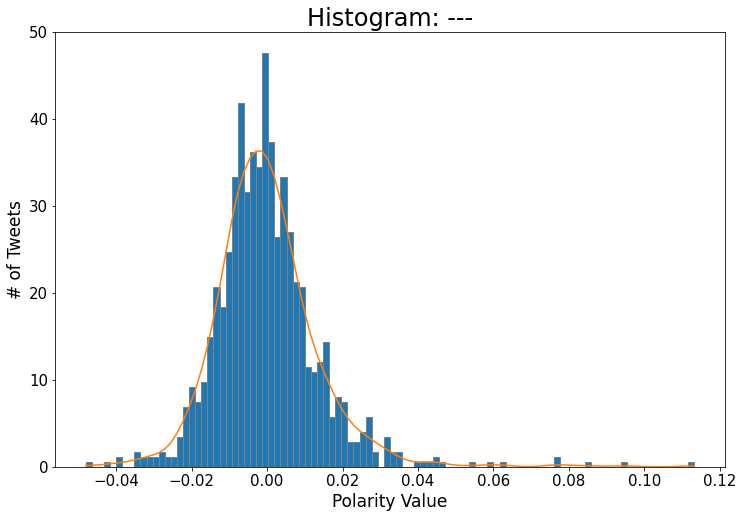

In [133]:
res = listOfTestData_Simple_Models[0]-listOfARIMA304Prediction[0]
density = stats.gaussian_kde(res)
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(res, 100, density=True, edgecolor='gray')
plt.plot(bins, density(bins))
plt.title('Histogram: ---', fontsize=24)
plt.xlabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel('# of Tweets', fontsize=17)
plt.yticks(fontsize=15)

print('Mean:', dataFr['pos'].mean())
print('Median:', dataFr['pos'].median())

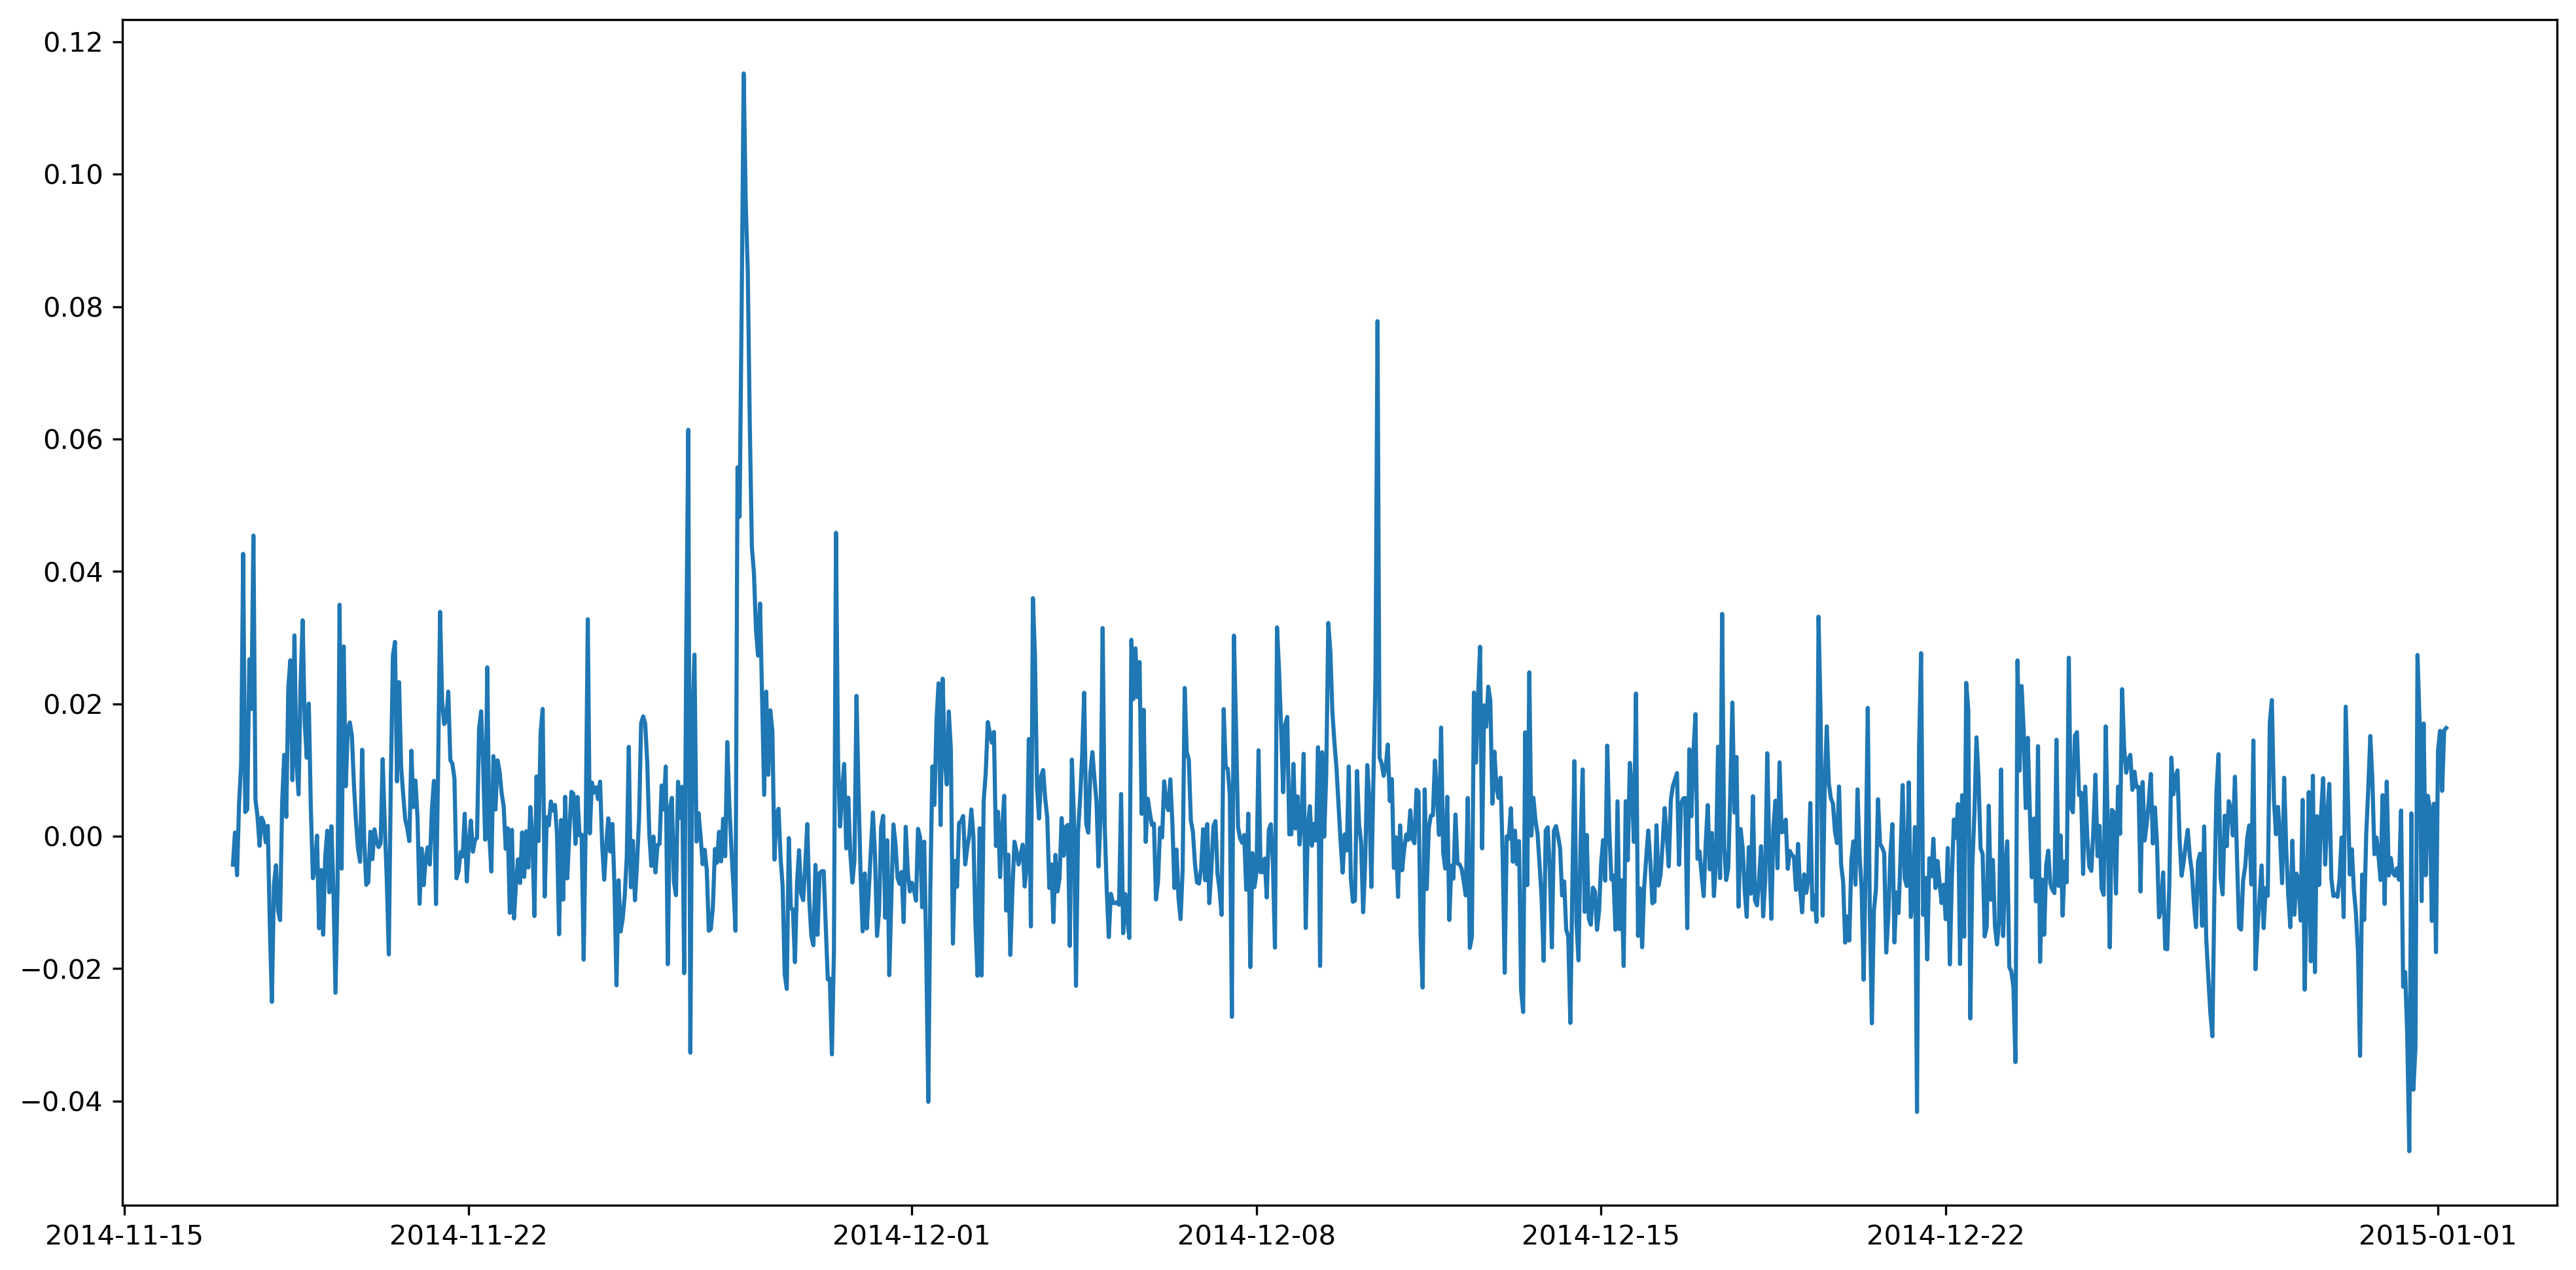

In [129]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(listOfTestData_Simple_Models[0]-listOfARIMA500Prediction[2])
plt.show()

Mean: 0.15934208692537866
Median: 0.158017043


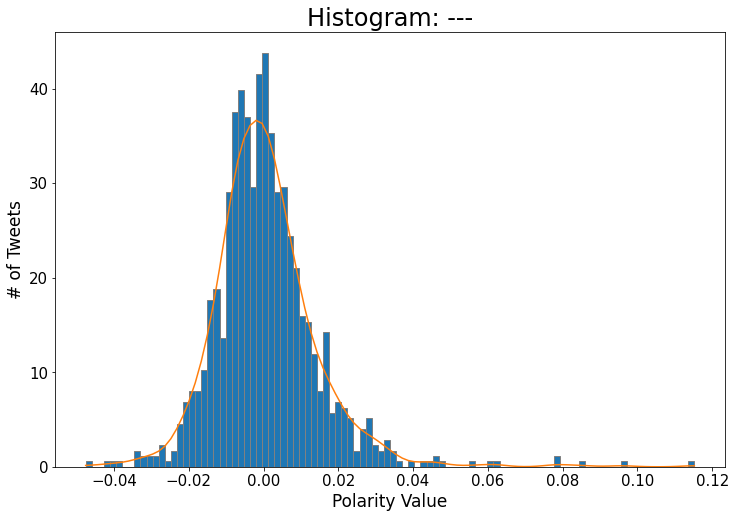

In [132]:
res = listOfTestData_Simple_Models[0]-listOfARIMA500Prediction[2]
density = stats.gaussian_kde(res)
plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(res, 100, density=True, edgecolor='gray')
plt.plot(bins, density(bins))
plt.title('Histogram: ---', fontsize=24)
plt.xlabel('Polarity Value', fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel('# of Tweets', fontsize=17)
plt.yticks(fontsize=15)

print('Mean:', dataFr['pos'].mean())
print('Median:', dataFr['pos'].median())

# =============================================================
# =============================================================
# =============================================================
# =============================================================
# =============================================================

# Simple Methods

In [1774]:
listOfData = [dataFr, df1, df2, df3]
listOfPositiveTrainData = [y_train_dataFr_pos, y_train_df1_pos, y_train_df2_pos, y_train_df3_pos]
listOfPositiveTestData = [y_test_dataFr_pos, y_test_df1_pos, y_test_df2_pos, y_test_df3_pos]
listOfNegativeTrainData = [y_train_dataFr_neg, y_train_df1_neg, y_train_df2_neg, y_train_df3_neg]
listOfNegativeTestData = [y_test_dataFr_neg, y_test_df1_neg, y_test_df2_neg, y_test_df3_neg]

In [ ]:
# Naïve: Use last value as the predicted value
def naive(train, test, title):
    pred = pd.Series(train[len(train)-1], index = test.index)
    plt.figure(figsize=(12, 6), dpi=300)
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel('Polarity Value')
    plt.plot(train[-200:], label = 'Train')
    plt.plot(test[:50], label = 'Test')
    plt.plot(pred[:50], label = 'Naive')
    plt.legend(loc='best')
    return pred

In [ ]:
listOfPositiveNaivePrediction = [None]*4
for i in range(0,4):
    listOfPositiveNaivePrediction[i]=naive(listOfPositiveTrainData[i], listOfPositiveTestData[i], 'Positive dataFr')

In [ ]:
listOfNegativeNaivePrediction = [None]*4
for i in range(0,4):
    listOfNegativeNaivePrediction[i]=naive(listOfNegativeTrainData[i], listOfNegativeTestData[i], 'Negative dataFr')

In [ ]:
# Average: Use the average of the forecast horizon as the predicted value
def average(train, test, horizon, title):
    if(horizon>len(train)):
        color = '\033[91m'
        print(f"{color}Horizon cannot be larger than the available Training Set!{color}")
        return
    pred = pd.Series(np.mean(train[-horizon:]), index = test.index)
    plt.figure(figsize=(12, 6), dpi=300)
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel('Polarity Value')
    plt.plot(train[-200:], label = 'Train')
    plt.plot(test[:50], label = 'Test')
    plt.plot(pred[:50], label = 'Average')
    plt.legend(loc='best')
    return pred

In [ ]:
listOfPositiveAverage4WeekPrediction = [None]*4
forecastHorizon = 24*7*4
for i in range(0,4):
    listOfPositiveAverage4WeekPrediction[i]=average(listOfPositiveTrainData[i], listOfPositiveTestData[i], forecastHorizon, 'Positive dataFr')

In [ ]:
listOfPositiveAverage1WeekPrediction = [None]*4
forecastHorizon = 24*7
for i in range(0,4):
    listOfPositiveAverage1WeekPrediction[i]=average(listOfPositiveTrainData[i], listOfPositiveTestData[i], forecastHorizon, 'Positive dataFr')

In [ ]:
# Seasonal naïve: e last observed value from the same 1season
# Here, I am using that the user's sentiment has a monthly (4 week) seasonality
def snNaive(train, test, season, title):
    seasonalValues = train[-season:]
    seasonalValuesLength = len(seasonalValues)
    testLength = len(test)
    pred = pd.Series(float, index = test.index)
    predIndex = 0
    while(testLength>=seasonalValuesLength):
        testLength = testLength-seasonalValuesLength
        pred[predIndex:predIndex+seasonalValuesLength] = seasonalValues
        predIndex = predIndex+seasonalValuesLength
    pred[predIndex:predIndex+testLength] = seasonalValues[0:testLength]
    plt.figure(figsize=(12, 6), dpi=300)
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel('Polarity Value')
    plt.plot(train[-200:], label = 'Train')
    plt.plot(test[:50], label = 'Test')
    plt.plot(pred[:50], label = 'Seasonal Naive')
    plt.legend(loc='best')
    return pred

In [ ]:
listOfPositiveSeasonalNaive4WeekPrediction = [None]*4
season = 24*7*4
for i in range(0,4):
    listOfPositiveSeasonalNaive4WeekPrediction[i]=snNaive(listOfPositiveTrainData[i], listOfPositiveTestData[i], season, 'Positive Seasonal Naive')

In [ ]:
listOfPositiveSeasonalNaive1WeekPrediction = [None]*4
season = 24*7
for i in range(0,4):
    listOfPositiveSeasonalNaive1WeekPrediction[i]=snNaive(listOfPositiveTrainData[i], listOfPositiveTestData[i], season, 'Positive Seasonal Naive')

In [ ]:
# Drift: fit a line between the first and last value of the forecast horizon to predict future
# Last value of this rangle will be the last value of the training set; first value can be set using the 'horizon' parameter
def drift(train, test, horizon, title):
    endVal = train[len(train)-1]
    startVal = train[-horizon]
    endIdx = len(train)-1
    startIdx = len(train)-horizon
    m = (endVal-startVal)/(endIdx-startIdx)
    c = endVal - m*endIdx
    pred = pd.Series(float, index = test.index)
    for i in range(0, len(test)):
        delta = test.index[i] - train.index[endIdx]
        delta = delta.days*24+delta.seconds//3600
        pred[test.index[i]] = m*(endIdx+delta)+c
    plt.figure(figsize=(12, 6), dpi=300)
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel('Polarity Value')
    plt.plot(train[-200:], label = 'Train')
    plt.plot(test[:50], label = 'Test')
    plt.plot(pred[:50], label = 'Drift')
    plt.legend(loc='best')
    return pred

In [ ]:
listOfPositiveDrift1WeekPrediction = [None]*4
horizon = 24*7
for i in range(0,4):
    listOfPositiveDrift1WeekPrediction[i]=drift(listOfPositiveTrainData[i], listOfPositiveTestData[i], horizon, 'Positive Drift 1 Week')

In [ ]:
listOfPositiveDrift4WeekPrediction = [None]*4
horizon = 24*7*4
for i in range(0,4):
    listOfPositiveDrift4WeekPrediction[i]=drift(listOfPositiveTrainData[i], listOfPositiveTestData[i], horizon, 'Positive Drift 4 Weeks')

In [ ]:
# Rolling Average: Use the rolling average of the forecast horizon as the predicted value
def rollingAverage(train, test, horizon, title):
    if(horizon>len(train)):
        color = '\033[91m'
        print(f"{color}Horizon cannot be larger than the available Training Set!{color}")
        return
    window = deque(train[-horizon:])
    pred = pd.Series(float, index = test.index)
    for i in range(0, len(pred)):
        pred[i] = np.mean(window)
        window.rotate(-1)
        window[len(window)-1] = pred[i]

    plt.figure(figsize=(12, 6), dpi=300)
    plt.title(title)
    plt.xlabel('Timestamp')
    plt.ylabel('Polarity Value')
    plt.plot(train[-200:], label = 'Train')
    plt.plot(test[:50], label = 'Test')
    plt.plot(pred[:50], label = 'Rolling Average')
    plt.legend(loc='best')
    return pred

In [ ]:
listOfPositiveRollingAverage1WeekPrediction = [None]*4
forecastHorizon = 24*7
for i in range(0,4):
    listOfPositiveRollingAverage1WeekPrediction[i]=rollingAverage(listOfPositiveTrainData[i], listOfPositiveTestData[i], forecastHorizon, 'Positive Rolling Average 1 Week')

In [ ]:
listOfPositiveRollingAverage4WeekPrediction = [None]*4
forecastHorizon = 24*7*4
for i in range(0,4):
    listOfPositiveRollingAverage4WeekPrediction[i]=rollingAverage(listOfPositiveTrainData[i], listOfPositiveTestData[i], forecastHorizon, 'Positive Rolling Average 4 Week')

In [ ]:
# Comparison of baseline methods for positive sentiments
plt.figure(figsize=(12, 6), dpi=300)
plt.xlabel('Timestamp')
plt.ylabel('Polarity Value')
plt.plot(listOfPositiveTrainData[0][-200:], label = 'Train')
plt.plot(listOfPositiveTestData[0][:50], label = 'Test')
plt.plot(listOfPositiveNaivePrediction[0][:50], label = 'Naive')
plt.plot(listOfPositiveAverage1WeekPrediction[0][:50], label = 'Average of 1 Week')
plt.plot(listOfPositiveAverage4WeekPrediction[0][:50], label = 'Average of 4 Week')
plt.plot(listOfPositiveSeasonalNaive1WeekPrediction[0][:50], label = 'Seasonal Naive 1 Week')
plt.plot(listOfPositiveSeasonalNaive4WeekPrediction[0][:50], label = 'Seasonal Naive 4 Week')
plt.plot(listOfPositiveDrift1WeekPrediction[0][:50], label = 'Drift 1 Week')
plt.plot(listOfPositiveDrift4WeekPrediction[0][:50], label = 'Drift 4 Week')
plt.plot(listOfPositiveRollingAverage1WeekPrediction[0][:50], label = 'Rolling Average of 1 Week')
plt.plot(listOfPositiveRollingAverage4WeekPrediction[0][:50], label = 'Rolling Average of 4 Week')
plt.legend(loc='best')

In [2109]:
# Comparison of baseline methods for negative sentiments

In [ ]:
#Performance Metrics Function
def performanceMetrics(test, pred, i, algo):
    rowHeader = ['raw_', 'interpolation_', 'ffill_', 'bfill_']
    print(rowHeader[i]+algo, end=',')
    # R-squared
    print(r2_score(test, pred), end=',')
    # MAE = Mean Absolute Error
    print(mean_absolute_error(test, pred), end=',')
    # MAPE = Mean Absolute Percentage Error
    print(mean_absolute_percentage_error(test, pred), end=',')
    # MSE = Mean Squared Error
    print(mean_squared_error(test, pred), end=',')
    # RMSE = Root Mean Squared Error
    print(math.sqrt(mean_squared_error(test, pred)), end=',')
    # NRMSE = Normalized Root Mean Squared Error
    print(math.sqrt(mean_squared_error(test, pred))/np.mean(test), end=',')
    # ME = Mean Error
    print(np.mean(test-pred), end=',')
    # MPE = Mean Percentage Error
    print(np.mean((test-pred)/test))

In [ ]:
list1 = [None, None, None, None, None, None, None]
list2 = [None, None, None, None, None, None, None]
list3 = [None, None, None, None, None, None, None]
performanceTable = [list1, list2, list3]
namesOfPerformanceTableLayer1 = ['Simple Algorithms', 'Regressions', 'ARIMAs']
namesOfPerformanceTableLayer2 = ['Positive Data (allows missing values)', 'Positive Data (missing value handled through interpolation)', 'Positive Data (missing value handled through forward fill)', 'Positive Data (missing value handled through backward fill)', 'Negative Data (allows missing values)', 'Negative Data (missing value handled through interpolation)', 'Negative Data (missing value handled through forward fill)', 'Negative Data (missing value handled through backward fill)']

In [ ]:
def performanceMetricsEntryGenerator(test, pred, i, algo):
    # R-squared
    r2 = r2_score(test, pred)
    # MAE = Mean Absolute Error
    mae = mean_absolute_error(test, pred)
    # MAPE = Mean Absolute Percentage Error
    mape = mean_absolute_percentage_error(test, pred)
    # MSE = Mean Squared Error
    mse = mean_squared_error(test, pred)
    # RMSE = Root Mean Squared Error
    rmse = math.sqrt(mean_squared_error(test, pred))
    # NRMSE = Normalized Root Mean Squared Error
    nrmse = math.sqrt(mean_squared_error(test, pred))/np.mean(test)
    # ME = Mean Error
    me = np.mean(test-pred)
    # MPE = Mean Percentage Error
    mpe = np.mean((test-pred)/test)
    dataAsDict = {'Algorithm':algo, 'R-squared':r2, 'MAE':mae, 'MAPE':mape, 'MSE':mse, 'RMSE':rmse, 'NRMSE':nrmse, 'ME':me, 'MPE':mpe}
    return dataAsDict

In [ ]:
for dataIndex in range(0,4):
    entryTable = pd.DataFrame(columns=['Algorithm', 'R-squared', 'MAE', 'MAPE', 'MSE', 'RMSE', 'NRMSE', 'ME', 'MPE'])
    listOfAlgoNames = ['Naive', 'Average of 1 Week', 'Average of 4 Week', 'Seasonal Naive 1 Week', 'Seasonal Naive 4 Week', 'Drift 1 Week', 'Drift 4 Week', 'Rolling Average 1 Week', 'Rolling Average 4 Week']
    listOfPredictedSets = [listOfPositiveNaivePrediction, listOfPositiveAverage1WeekPrediction, listOfPositiveAverage4WeekPrediction, listOfPositiveSeasonalNaive1WeekPrediction, listOfPositiveSeasonalNaive4WeekPrediction, listOfPositiveDrift1WeekPrediction, listOfPositiveDrift4WeekPrediction, listOfPositiveRollingAverage1WeekPrediction, listOfPositiveRollingAverage4WeekPrediction]
    for i in range(0, len(listOfAlgoNames)):    
        entry = performanceMetricsEntryGenerator(listOfPositiveTestData[dataIndex], listOfPredictedSets[i][dataIndex], 0, listOfAlgoNames[i])
        entryTable = entryTable.append(entry, ignore_index=True)
    performanceTable[0][dataIndex] = entryTable

In [ ]:
print(',R-squared,'+'MAE,'+'MAPE,'+'MSE,'+'RMSE,'+'NRMSE,'+'ME,'+'MPE')
for i in range(0,4):
    performanceMetrics(listOfPositiveTestData[i], listOfPositiveNaivePrediction[i], i, 'naive')

In [ ]:
print(',R-squared,'+'MAE,'+'MAPE,'+'MSE,'+'RMSE,'+'NRMSE,'+'ME,'+'MPE')
for i in range(0,4):
    performanceMetrics(listOfPositiveTestData[i], listOfPositiveAverage1WeekPrediction[i], i, 'avg1week')

In [ ]:
print(',R-squared,'+'MAE,'+'MAPE,'+'MSE,'+'RMSE,'+'NRMSE,'+'ME,'+'MPE')
for i in range(0,4):
    performanceMetrics(listOfPositiveTestData[i], listOfPositiveAverage4WeekPrediction[i], i, 'avg4week')

In [ ]:
print(',R-squared,'+'MAE,'+'MAPE,'+'MSE,'+'RMSE,'+'NRMSE,'+'ME,'+'MPE')
for i in range(0,4):
    performanceMetrics(listOfPositiveTestData[i], listOfPositiveSeasonalNaive1WeekPrediction[i], i, 'seasonalNaive1Week')

In [ ]:
print(',R-squared,'+'MAE,'+'MAPE,'+'MSE,'+'RMSE,'+'NRMSE,'+'ME,'+'MPE')
for i in range(0,4):
    performanceMetrics(listOfPositiveTestData[i], listOfPositiveSeasonalNaive4WeekPrediction[i], i, 'seasonalNaive4Week')

In [ ]:
print(',R-squared,'+'MAE,'+'MAPE,'+'MSE,'+'RMSE,'+'NRMSE,'+'ME,'+'MPE')
for i in range(0,4):
    performanceMetrics(listOfPositiveTestData[i], listOfPositiveDrift1WeekPrediction[i], i, 'drift1Week')

In [ ]:
print(',R-squared,'+'MAE,'+'MAPE,'+'MSE,'+'RMSE,'+'NRMSE,'+'ME,'+'MPE')
for i in range(0,4):
    performanceMetrics(listOfPositiveTestData[i], listOfPositiveDrift4WeekPrediction[i], i, 'drift4Week')

In [ ]:
print(',R-squared,'+'MAE,'+'MAPE,'+'MSE,'+'RMSE,'+'NRMSE,'+'ME,'+'MPE')
for i in range(0,4):
    performanceMetrics(listOfPositiveTestData[i], listOfPositiveRollingAverage1WeekPrediction[i], i, 'rollingAvg1Week')

In [ ]:
print(',R-squared,'+'MAE,'+'MAPE,'+'MSE,'+'RMSE,'+'NRMSE,'+'ME,'+'MPE')
for i in range(0,4):
    performanceMetrics(listOfPositiveTestData[i], listOfPositiveRollingAverage4WeekPrediction[i], i, 'rollingAvg4Week')

In [ ]:
# Residual Diagnostics
# A good forecasting method will yield residuals with the following properties.
# 1. Residuals are uncorrelated. If not, some information left out and should be used in the forecast.
# 2. Mean(residuals) = 0
# Constant variance
# Normally distributed
r = listOfPositiveTestData[0]-listOfPositiveNaivePrediction[0]
print('Mean:', np.mean(r))
plt.figure(figsize=(16,8), dpi=300)
plt.plot(r)
density = stats.gaussian_kde(r)
plt.figure(figsize=(16,8))
n, bins, patches = plt.hist(r, 100, density=True, edgecolor='gray')
plt.plot(bins, density(bins))
plt.title('Set a title')
plt.xlabel('Put label on X axis')
plt.ylabel('Put label on Y axis')

print('Mean:', r.mean())
print('Median:', r.median())

fig, ax = plt.subplots(figsize=(16,8))
plot_acf(r, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,8))
plot_pacf(r, ax=ax)
plt.show()

sm.stats.acorr_ljungbox(r, lags=[24], return_df=True)#['lb_pvalue']<0.05

In [ ]:
# Avobe residual diagnostics shows some info left out
# So trying differencing

###############################################
# DO NOT EXECUTE THIS
#from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob
 
# difference the dataset
dataFrPosDiff = difference(dataFr['pos'], 24*7)
plt.plot(dataFrPosDiff[:200])
plt.show()

# invert the difference
inverted = [inverse_difference(dataFr['pos'][i], dataFrPosDiff[i]) for i in range(len(dataFrPosDiff))]
plt.plot(inverted[:200])
plt.show()

print('Positive Stats:')
adf_test(dataFrPosDiff)
print('Positive Stats:')
kpss_test(dataFrPosDiff)
###############################################

In [ ]:
dataFrPosDiff = pd.Series(dataFrPosDiff, index = dataFr.index[24*7:])

In [ ]:
test_size=24*45 # I am setting aside last 45 days of data as test set
y_train_dataFr_pos_diff, y_test_dataFr_pos_diff = temporal_train_test_split(dataFrPosDiff, test_size = test_size)

In [ ]:
y_test_dataFr_pos_diff

In [ ]:
PositiveNaivePredictionDiff=naive(y_train_dataFr_pos_diff, y_test_dataFr_pos_diff, 'Positive dataFr Naive Diff')

In [ ]:
r = y_test_dataFr_pos_diff-PositiveNaivePredictionDiff
print('Mean:', np.mean(r))
plt.figure(figsize=(16,8), dpi=300)
plt.plot(r)
density = stats.gaussian_kde(r)
plt.figure(figsize=(16,8))
n, bins, patches = plt.hist(r, 100, density=True, edgecolor='gray')
plt.plot(bins, density(bins))
plt.title('Set a title')
plt.xlabel('Put label on X axis')
plt.ylabel('Put label on Y axis')

print('Mean:', r.mean())
print('Median:', r.median())

fig, ax = plt.subplots(figsize=(16,8))
plot_acf(r, ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(16,8))
plot_pacf(r, ax=ax)
plt.show()

sm.stats.acorr_ljungbox(r, lags=[1], return_df=True)#['lb_pvalue']<0.05

In [ ]:
# Moving Average
# Do not know what to do with this
x = dataFr['pos'].rolling(12)
plt.figure(figsize=(16,8), dpi=300)
plt.plot(dataFr['pos'][200:500], label = 'Actual')
plt.plot(x.mean()[200:500], label = 'Rolling Avg')
plt.legend()

# Regression

In [ ]:
# Support Vector Regressor
# Linear Regression
# KNeighbors Regressor
# Random Forest Regressor
# Decision Tree Regressor

In [ ]:
def reduction(data, nF = 24):
    features = []
    target = []
    for i in range(len(data)-nF):
        features.append(data[i:i+nF])
        target.append(data[i+nF])
    features = np.array(features)
    target = np.array(target)
    return features, target

In [ ]:
def temporal_features_target_split(features, target, test_size):
    features_train, features_test = temporal_train_test_split(features, test_size = test_size)
    target_train, target_test = temporal_train_test_split(target, test_size = test_size)
    return features_train, target_train, features_test, target_test

# UNSCALED SPLIT

In [ ]:
# Split the data for regression
# Now, I have four different versions of the data
# Version 1: dataFr where I do not handle the missing values and use the data as is
# Version 2: df1 where I use interpolation to fill-up the missing values
# Version 3: df2 where I use forward fill to fill-up the missing values
# Version 4: df3 where I use backward fill to fill-up the missing values

test_size=24*45 # I am setting aside last 45 days of data as test set

# Here I create four different sets of train and test for each of the different versions
# dataFr Positive
dataFr_pos_features, dataFr_pos_target= reduction(dataFr['pos'])
dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test = temporal_features_target_split(dataFr_pos_features, dataFr_pos_target, test_size)
# dataFr Negative

# df1 Positive
df1_pos_features, df1_pos_target= reduction(df1['pos'])
df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test = temporal_features_target_split(df1_pos_features, df1_pos_target, test_size)
# df1 Negative

# df2 Positive
df2_pos_features, df2_pos_target= reduction(df2['pos'])
df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test = temporal_features_target_split(df2_pos_features, df2_pos_target, test_size)
# df2 Negative

# df3 Positive
df3_pos_features, df3_pos_target= reduction(df3['pos'])
df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test = temporal_features_target_split(df3_pos_features, df3_pos_target, test_size)
# df3 Negative

In [ ]:
def linearReg(features_train, target_train, features_test, target_test):
    reg = LinearRegression().fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    '''
    plt.figure(figsize=(16,8), dpi=300)
    plt.plot(target_test[:20], label = 'Test')
    plt.plot(target_pred[:20],  label = 'Linear Regression')
    plt.legend()
    '''
    print('Train Score:', reg.score(features_train, target_train))
    print('Test Score:', reg.score(features_test, target_test))
    return target_pred

In [ ]:
dataFr_pos_target_pred = linearReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = linearReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = linearReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = linearReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

In [ ]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(dataFr_pos_target_test[:20], label = 'Test dataFr')
plt.plot(dataFr_pos_target_pred[:20], label = 'Pred dataFr')
plt.plot(df1_pos_target_pred[:20], label = 'Pred df1')
plt.plot(df2_pos_target_pred[:20], label = 'Pred df2')
plt.plot(df3_pos_target_pred[:20], label = 'Pred df3')
plt.legend()

In [ ]:
def unpack(val):
    return val[0]

def scaling(dt):
    list(sc.fit_transform(np.array(data).reshape(-1, 1)))
    sc_list = list(sc.fit_transform(np.array(dt).reshape(-1, 1)))
    sc_list = list(map(unpack, sc_list))
    sc_series = pd.Series(sc_list, index = dt.index)
    return sc_series

# SCALED SPLIT***

In [ ]:
# Split the data for regression and apply scaling using StandardScaller
# Now, I have four different versions of the data
# Version 1: dataFr where I do not handle the missing values and use the data as is
# Version 2: df1 where I use interpolation to fill-up the missing values
# Version 3: df2 where I use forward fill to fill-up the missing values
# Version 4: df3 where I use backward fill to fill-up the missing values

test_size=24*45 # I am setting aside last 45 days of data as test set

# Here I create four different sets of train and test for each of the different versions
# dataFr Positive
dataFr_pos_features, dataFr_pos_target= reduction(scaling(dataFr['pos']))
dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test = temporal_features_target_split(dataFr_pos_features, dataFr_pos_target, test_size)
# dataFr Negative

# df1 Positive
df1_pos_features, df1_pos_target= reduction(scaling(df1['pos']))
df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test = temporal_features_target_split(df1_pos_features, df1_pos_target, test_size)
# df1 Negative

# df2 Positive
df2_pos_features, df2_pos_target= reduction(scaling(df2['pos']))
df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test = temporal_features_target_split(df2_pos_features, df2_pos_target, test_size)
# df2 Negative

# df3 Positive
df3_pos_features, df3_pos_target= reduction(scaling(df3['pos']))
df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test = temporal_features_target_split(df3_pos_features, df3_pos_target, test_size)
# df3 Negative

In [ ]:
dataFr_pos_target_pred = linearReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = linearReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = linearReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = linearReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

In [ ]:
def SVReg(features_train, target_train, features_test, target_test):
    reg = SVR(kernel='rbf').fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    '''
    plt.figure(figsize=(16,8), dpi=300)
    plt.plot(target_test[:200], label = 'Test')
    plt.plot(target_pred[:200],  label = 'Support Vector Regression')
    plt.legend()
    '''
    print('Train Score:', reg.score(features_train, target_train))
    print('Test Score:', reg.score(features_test, target_test))
    return target_pred

In [ ]:
dataFr_pos_target_pred = SVReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = SVReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = SVReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = SVReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

In [ ]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(dataFr_pos_target_test[:20], label = 'Test dataFr')
plt.plot(dataFr_pos_target_pred[:20], label = 'Pred dataFr')
plt.plot(df1_pos_target_pred[:20], label = 'Pred df1')
plt.plot(df2_pos_target_pred[:20], label = 'Pred df2')
plt.plot(df3_pos_target_pred[:20], label = 'Pred df3')
plt.legend()

In [ ]:
dataFr_pos_target_pred = SVReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = SVReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = SVReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = SVReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

In [ ]:
def KNReg(features_train, target_train, features_test, target_test):
    reg = KNeighborsRegressor(n_neighbors=8).fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    '''
    plt.figure(figsize=(16,8), dpi=300)
    plt.plot(target_test[:200], label = 'Test')
    plt.plot(target_pred[:200],  label = 'K Neighbors Regression')
    plt.legend()
    '''
    print('Train Score:', reg.score(features_train, target_train))
    print('Test Score:', reg.score(features_test, target_test))
    return target_pred

In [ ]:
dataFr_pos_target_pred = KNReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = KNReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = KNReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = KNReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

In [ ]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(dataFr_pos_target_test[:20], label = 'Test dataFr')
plt.plot(dataFr_pos_target_pred[:20], label = 'Pred dataFr')
plt.plot(df1_pos_target_pred[:20], label = 'Pred df1')
plt.plot(df2_pos_target_pred[:20], label = 'Pred df2')
plt.plot(df3_pos_target_pred[:20], label = 'Pred df3')
plt.legend()

In [ ]:
dataFr_pos_target_pred = KNReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = KNReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = KNReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = KNReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

In [ ]:
def DTReg(features_train, target_train, features_test, target_test):
    reg = DecisionTreeRegressor(random_state=0).fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    '''
    plt.figure(figsize=(16,8), dpi=300)
    plt.plot(target_test[:200], label = 'Test')
    plt.plot(target_pred[:200],  label = 'K Neighbors Regression')
    plt.legend()
    '''
    print('Train Score:', reg.score(features_train, target_train))
    print('Test Score:', reg.score(features_test, target_test))
    return target_pred

In [ ]:
dataFr_pos_target_pred = DTReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = DTReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = DTReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = DTReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

In [ ]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(dataFr_pos_target_test[:20], label = 'Test dataFr')
plt.plot(dataFr_pos_target_pred[:20], label = 'Pred dataFr')
plt.plot(df1_pos_target_pred[:20], label = 'Pred df1')
plt.plot(df2_pos_target_pred[:20], label = 'Pred df2')
plt.plot(df3_pos_target_pred[:20], label = 'Pred df3')
plt.legend()

In [ ]:
dataFr_pos_target_pred = DTReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = DTReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = DTReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = DTReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

In [ ]:
def RFReg(features_train, target_train, features_test, target_test):
    reg = RandomForestRegressor(max_depth=12, random_state=0).fit(features_train, target_train)
    target_pred = reg.predict(features_test)
    '''
    plt.figure(figsize=(16,8), dpi=300)
    plt.plot(target_test[:200], label = 'Test')
    plt.plot(target_pred[:200],  label = 'K Neighbors Regression')
    plt.legend()
    '''
    print('Train Score:', reg.score(features_train, target_train))
    print('Test Score:', reg.score(features_test, target_test))
    return target_pred

In [ ]:
dataFr_pos_target_pred = RFReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = RFReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = RFReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = RFReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

In [ ]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(dataFr_pos_target_test[:20], label = 'Test dataFr')
plt.plot(dataFr_pos_target_pred[:20], label = 'Pred dataFr')
plt.plot(df1_pos_target_pred[:20], label = 'Pred df1')
plt.plot(df2_pos_target_pred[:20], label = 'Pred df2')
plt.plot(df3_pos_target_pred[:20], label = 'Pred df3')
plt.legend()

In [ ]:
dataFr_pos_target_pred = RFReg(dataFr_pos_features_train, dataFr_pos_target_train, dataFr_pos_features_test, dataFr_pos_target_test)
df1_pos_target_pred = RFReg(df1_pos_features_train, df1_pos_target_train, df1_pos_features_test, df1_pos_target_test)
df2_pos_target_pred = RFReg(df2_pos_features_train, df2_pos_target_train, df2_pos_features_test, df2_pos_target_test)
df3_pos_target_pred = RFReg(df3_pos_features_train, df3_pos_target_train, df3_pos_features_test, df3_pos_target_test)

# Statistical tests used to test whether Time series is stationary or not
### Augmented Dickey-Fuller test (ADF Test) and Kwiatkowski-Phillips-Schmidt-Shin test (KPSS test) 
https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

In [ ]:
# Load Statsmodels 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Load Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print('Test Statistic > Critical Value (1%)', dfoutput['Test Statistic']>dfoutput['Critical Value (1%)'])
    print('Test Statistic > Critical Value (5%)', dfoutput['Test Statistic']>dfoutput['Critical Value (5%)'])
    print('Test Statistic > Critical Value (10%)', dfoutput['Test Statistic']>dfoutput['Critical Value (10%)'])
    print('p-value > 0.05', dfoutput['p-value']>0.05)
    print(0.05/dfoutput['p-value'])
print('Positive Stats:')
adf_test(data['positive'])
print('Negative Stats:')
adf_test(data['negative'])

# Since everything is coming false, we can reject the null hypothesis and can call the data stationary

In [ ]:
# Function to print out results in customised manner
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    print('Test Statistic < Critical Value (10%)', kpss_output['Test Statistic']<kpss_output['Critical Value (10%)'])
    print('Test Statistic < Critical Value (5%)', kpss_output['Test Statistic']<kpss_output['Critical Value (5%)'])
    print('Test Statistic < Critical Value (2.5%)', kpss_output['Test Statistic']<kpss_output['Critical Value (2.5%)'])
    print('Test Statistic < Critical Value (1%)', kpss_output['Test Statistic']<kpss_output['Critical Value (1%)'])
    
    print('p-value < 0.05', kpss_output['p-value']<0.05)
    print(0.05/kpss_output['p-value'])
    
print('Positive Stats:')
kpss_test(data['positive'])
print('Negative Stats:')
kpss_test(data['negative'])

The following are the possible outcomes of applying both the tests.

- Case 1: Both tests conclude that the given series is stationary – The series is stationary
- Case 2: Both tests conclude that the given series is non-stationary – The series is non-stationary
- Case 3: ADF concludes non-stationary and KPSS concludes stationary – The series is trend stationary. To make the series strictly stationary, the trend needs to be removed in this case. Then the detrended series is checked for stationarity.
- Case 4: ADF concludes stationary and KPSS concludes non-stationary – The series is difference stationary. Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

Assuming we have a daily seasonality and applying differencing to address that

In [ ]:
from matplotlib import pyplot

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob
 
# difference the dataset
diffPositive = difference(data['positive'], 24)
pyplot.plot(diffPositive[:200])
pyplot.show()

# invert the difference
inverted = [inverse_difference(data['positive'][i], diffPositive[i]) for i in range(len(diffPositive))]
pyplot.plot(inverted[:200])
pyplot.show()

print('Positive Stats:')
adf_test(diffPositive)
print('Positive Stats:')
kpss_test(diffPositive)



In [ ]:
# difference the dataset
diffNegative = difference(data['negative'], 24)
pyplot.plot(diffNegative[:200])
pyplot.show()

# invert the difference
inverted = [inverse_difference(data['negative'][i], diffNegative[i]) for i in range(len(diffPositive))]
pyplot.plot(inverted[:200])
pyplot.show()

print('Negative Stats:')
adf_test(diffNegative)
print('Negative Stats:')
kpss_test(diffNegative)

# Univariate Time Series Data = One variable at a time for different time periods

In [ ]:
import sktime
from sktime import datasets

In [ ]:
airline = datasets.load_airline()

In [ ]:
airline.index[0].end_time

In [ ]:
len(airline)/12

In [ ]:
plt.plot(airline.values)

In [ ]:
from sktime.utils.plotting import plot_series
fig, ax = plot_series(airline[:72], airline[72:])
ax.set_title = ('adasdas asdasasd as')

In [ ]:
airline.index

In [ ]:
plot_series(dataFr['positive'][0:100])
#dataFr['positive']

In [ ]:
# Creating Index for the 'Data_Filled' dataframe

dataFr.head(10)
year = 2014
month = 5
day = 16
hour = 17
indexList = []


for _ in iter(int, 1):
#for l in range(0, len(dataFr)):
    dtStamp = datetime.datetime(year, month, day, hour)
    indexList.append(dtStamp)
    if(year==2015 and month==1 and day==1 and hour==4):
        break
    hour = hour+1
    if(hour == 24):
        hour = 0
        day = day+1
        if(day == 31 and (month == 6 or month == 9 or month == 11)):
            day = 1
            month = month+1
        elif(day == 32):
            day = 1
            month = month+1
        if(month == 13):
            month = 1
            year = year+1

In [ ]:
Data_Filled = pd.DataFrame(np.nan, columns = ['pos', 'neg'], 
                   index = indexList)
Data_Filled

In [ ]:
i = 0
for idx in dataFr.index:
    Data_Filled.loc[idx]['pos'] = float(dataFr.loc[idx]['positive'])
    Data_Filled.loc[idx]['neg'] = float(dataFr.loc[idx]['negative'])

In [ ]:
print(len(y_train))
print(len(y_test))

In [ ]:
#plot_series(y_train, y_test, labels = ['Train', 'Test'])
plot_series(Data_Filled['pos'])

In [ ]:
# Handling Missing Values
Data_Filled.isna().sum()

df1 = Data_Filled.interpolate()
df1
plot_series(df1['pos'])


df2 = Data_Filled.ffill()
df2
plot_series(df2['pos'])


df3 = Data_Filled.bfill()
df3
plot_series(df3['pos'])

In [ ]:
# Now, we have four different versions of the data
# Version 1: Data_Filled where I do not handle the missing values and use the data as is
# Version 2: df1 where I use interpolation to fill-up the missing values
# Version 3: df2 where I use forward fill to fill-up the missing values
# Version 4: df3 where I use backward fill to fill-up the missing values

from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.model_selection import temporal_train_test_split

test_size=24*66

# Here I create four different sets of train and test for each of the different versions
y_train_dataFr_pos, y_test_dataFr_pos = temporal_train_test_split(dataFr['positive'], test_size = int(len(dataFr['positive'])*.20))
y_train_dataFr_neg, y_test_dataFr_neg = temporal_train_test_split(dataFr['negative'], test_size = int(len(dataFr['negative'])*.20))

y_train_df1_pos, y_test_df1_pos = temporal_train_test_split(df1['pos'], test_size = int(len(df1['pos'])*.20))
y_train_df1_neg, y_test_df1_neg = temporal_train_test_split(df1['neg'], test_size = int(len(df1['neg'])*.20))

y_train_df2_pos, y_test_df2_pos = temporal_train_test_split(df2['pos'], test_size = int(len(df2['pos'])*.20))
y_train_df2_neg, y_test_df2_neg = temporal_train_test_split(df2['neg'], test_size = int(len(df2['neg'])*.20))

y_train_df3_pos, y_test_df3_pos = temporal_train_test_split(df3['pos'], test_size = int(len(df3['pos'])*.20))
y_train_df3_neg, y_test_df3_neg = temporal_train_test_split(df3['neg'], test_size = int(len(df3['neg'])*.20))

print('\nStat for dataFr or missing values not handled')
print(len(y_train_dataFr_pos), len(y_test_dataFr_pos))
print(len(y_train_dataFr_neg), len(y_test_dataFr_neg))

print('\nStat for df1 or missing values handled by interpolation')
print(len(y_train_df1_pos), len(y_test_df1_pos))
print(len(y_train_df1_neg), len(y_test_df1_neg))

print('\nStat for df2 or missing values handled by forward fill')
print(len(y_train_df2_pos), len(y_test_df2_pos))
print(len(y_train_df2_neg), len(y_test_df2_neg))

print('\nStat for df3 or missing values handled by backward fill')
print(len(y_train_df3_pos), len(y_test_df3_pos))
print(len(y_train_df3_neg), len(y_test_df3_neg))

In [ ]:
# Plots for 'dataFr or missing values not handled'
plot_series(y_train_dataFr_pos, y_test_dataFr_pos)
plot_series(y_train_dataFr_neg, y_test_dataFr_neg)

In [ ]:
# Plots for 'df1 or missing values handled by interpolation'
plot_series(y_train_df1_pos, y_test_df1_pos)
plot_series(y_train_df1_neg, y_test_df1_neg)

In [ ]:
# Plots for 'df2 or missing values handled by forward fill'
plot_series(y_train_df2_pos, y_test_df2_pos)
plot_series(y_train_df2_neg, y_test_df2_neg)

In [ ]:
# Plots for 'df3 or missing values handled by backward fill'
plot_series(y_train_df3_pos, y_test_df3_pos)
plot_series(y_train_df3_neg, y_test_df3_neg)

In [ ]:
plt.figure(figsize=(12, 6), dpi=300)
plt.title('Distribution of positive porarity values (missing values handled using interpolation)')
plt.xlabel('Timestamp')
plt.ylabel('Positive Polarity Value')
plt.plot(y_train_df3_pos, marker = 'o', markeredgecolor = 'white')
plt.plot(y_test_df3_pos, marker = 'o', markeredgecolor = 'white')

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train_df1_pos, y_test_df1_pos = temporal_train_test_split(list(range(1,100)), 30)

In [ ]:
y_test.isna().sum()
y_pred = forecaster.predict()

In [ ]:
dataFr[594:].head(20)

In [ ]:
plt.plot(y_train, y_test)

In [ ]:
Data_Filled['pos'].dropna()

# PREV

In [ ]:
data.describe()

In [ ]:
data.plot()

In [ ]:
data[0:250].plot()

In [ ]:
data[251:500].plot()

In [ ]:
data_mean = data.rolling(window = 3).mean()
data_mean

In [ ]:
data.plot()
data_mean.plot()

In [ ]:
data[0:250].plot()
data_mean[0:250].plot()

In [ ]:
data[251:500].plot()
data_mean[251:500].plot()

In [ ]:
data_1day = pd.concat([data, data.shift(1)], axis = 1)
data_1day.columns = ['positive', 'negative', 'posPred1Day', 'negPred1Day']
data_1day

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [ ]:
data_1day_nan_removed = data_1day[1:]
data_1day_nan_removed

In [ ]:
posPred1Day_error = mean_squared_error(data_1day_nan_removed.positive, data_1day_nan_removed.posPred1Day)
print(posPred1Day_error)
print(np.sqrt(posPred1Day_error))

In [ ]:
negPred1Day_error = mean_squared_error(data_1day_nan_removed.negative, data_1day_nan_removed.negPred1Day)
print(negPred1Day_error)
print(np.sqrt(negPred1Day_error))

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
tempIdx = dataFr.index[0]
dataFr.loc[tempIdx]
Data_Filled.loc[tempIdx]['pos'] = dataFr.loc[tempIdx]['positive']
Data_Filled.loc[tempIdx]['neg'] = dataFr.loc[tempIdx]['negative']
Data_Filled

In [ ]:
# plot acf to to identify Q
# ARIMA (p, d, q)

plot_acf(data['positive']) # q

<Figure size 4800x2400 with 0 Axes>

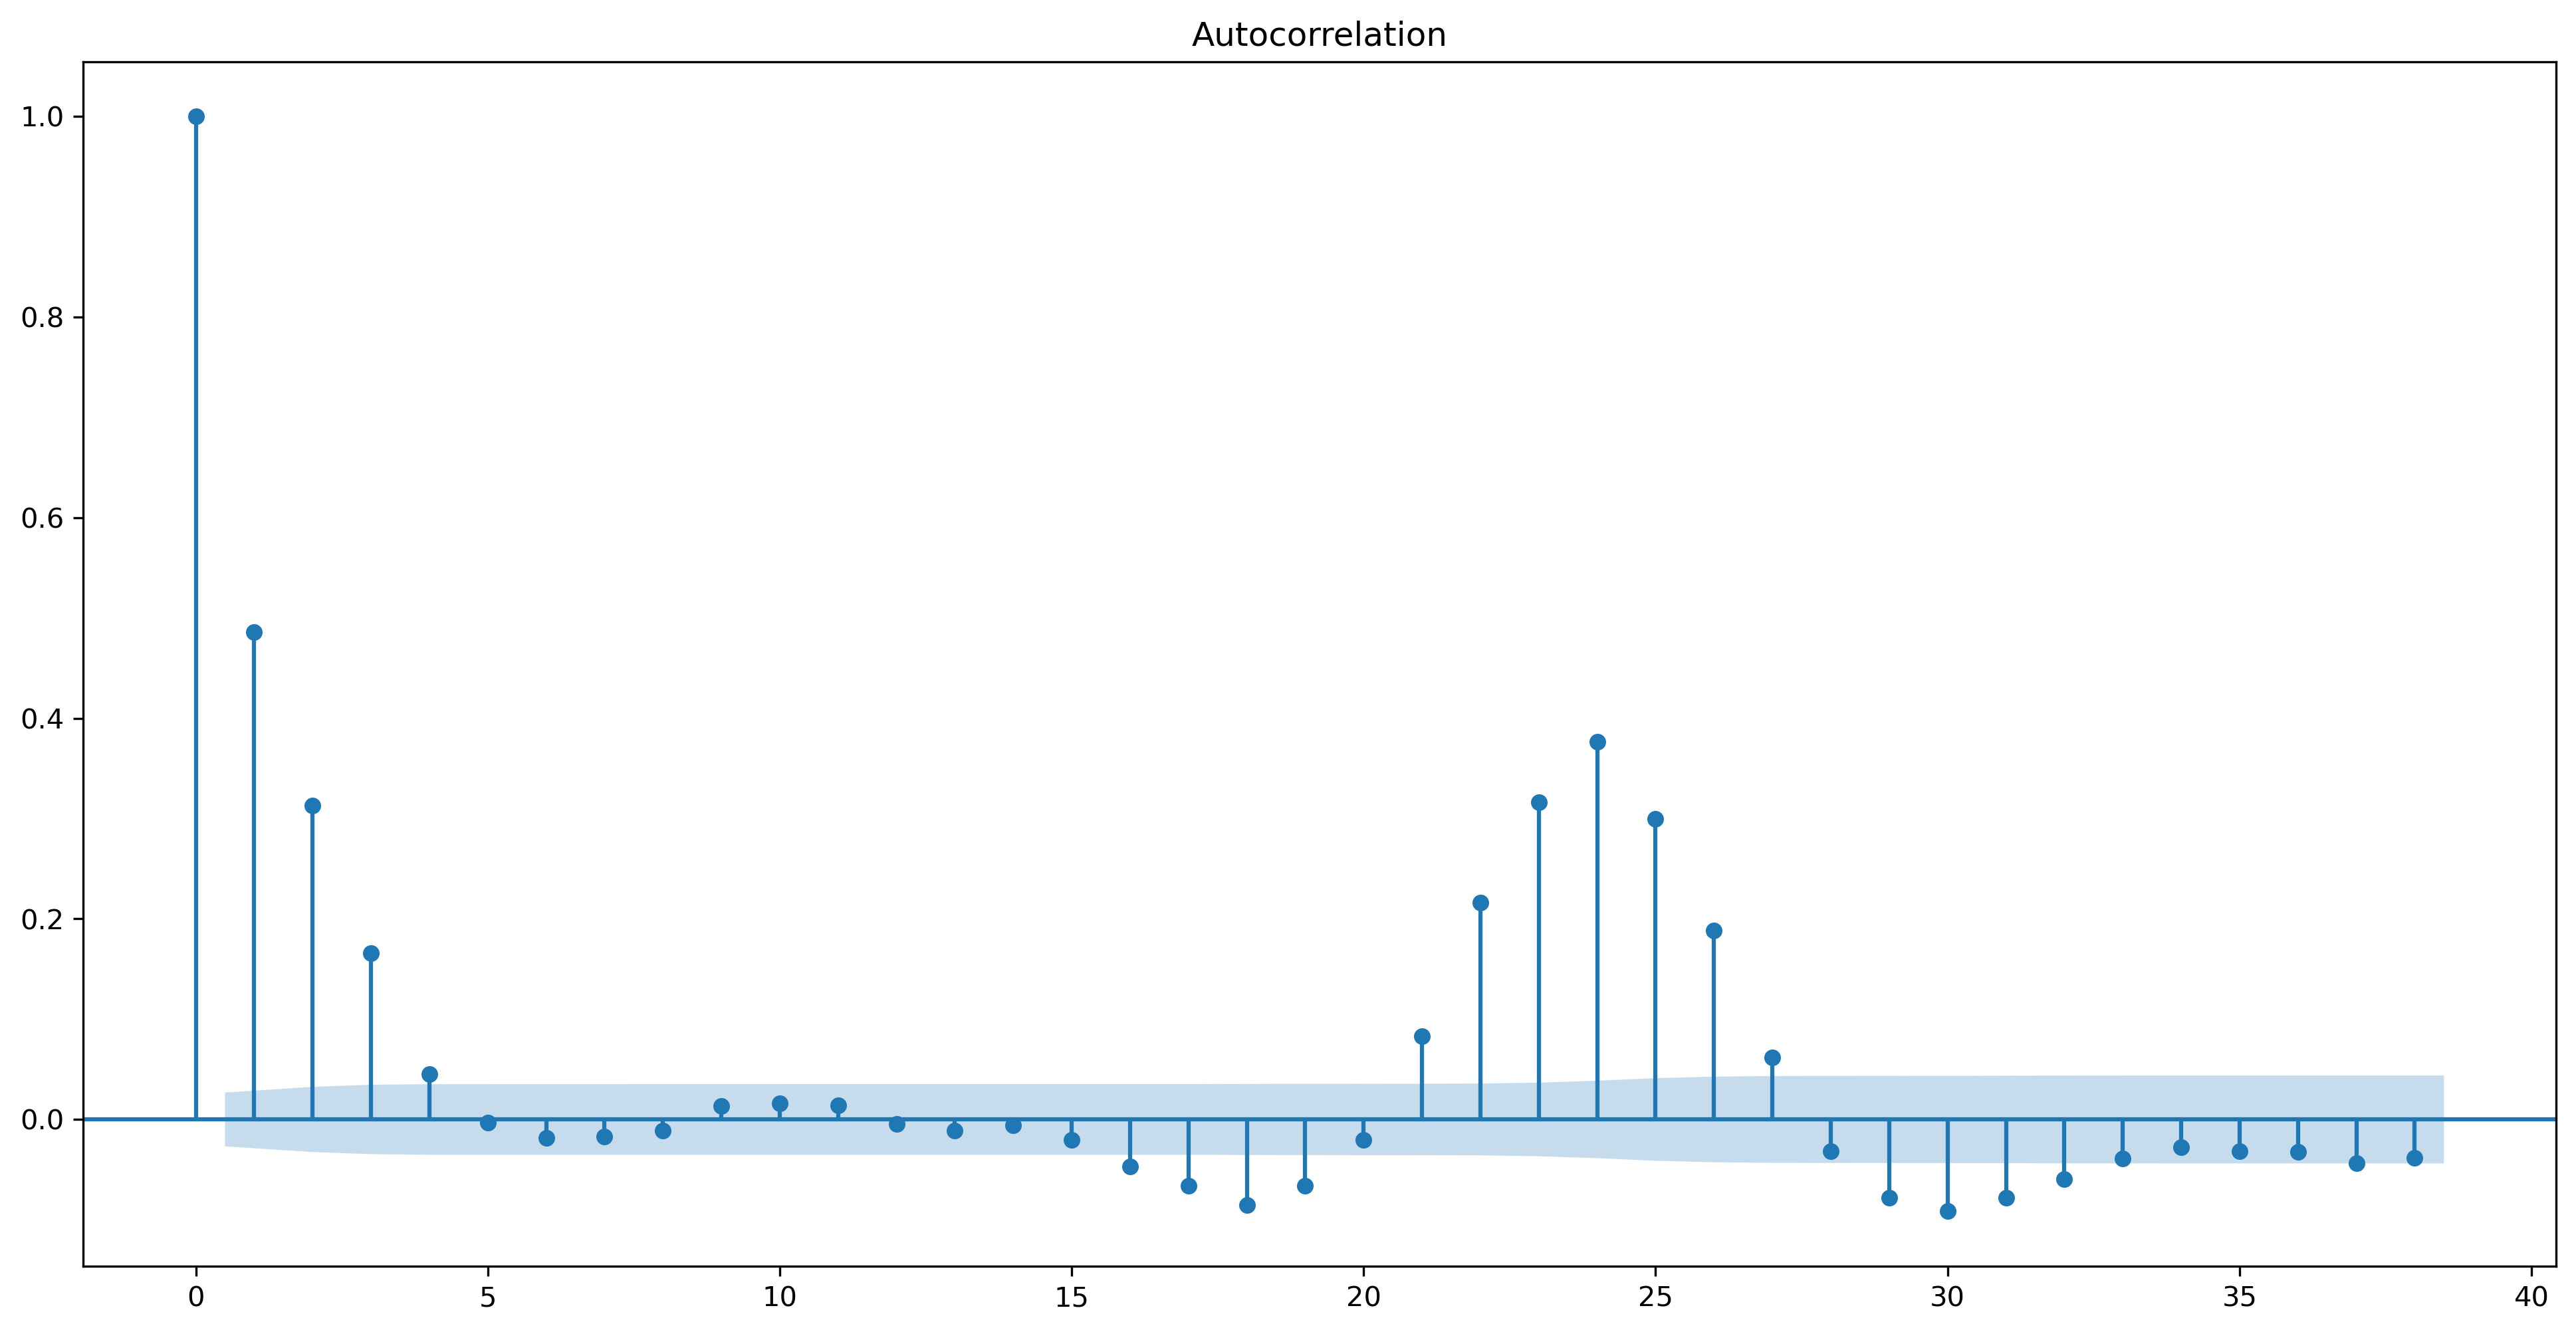

In [2118]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(16,8), dpi= 300)
    plot_acf(dataFr['pos'])
plt.show()

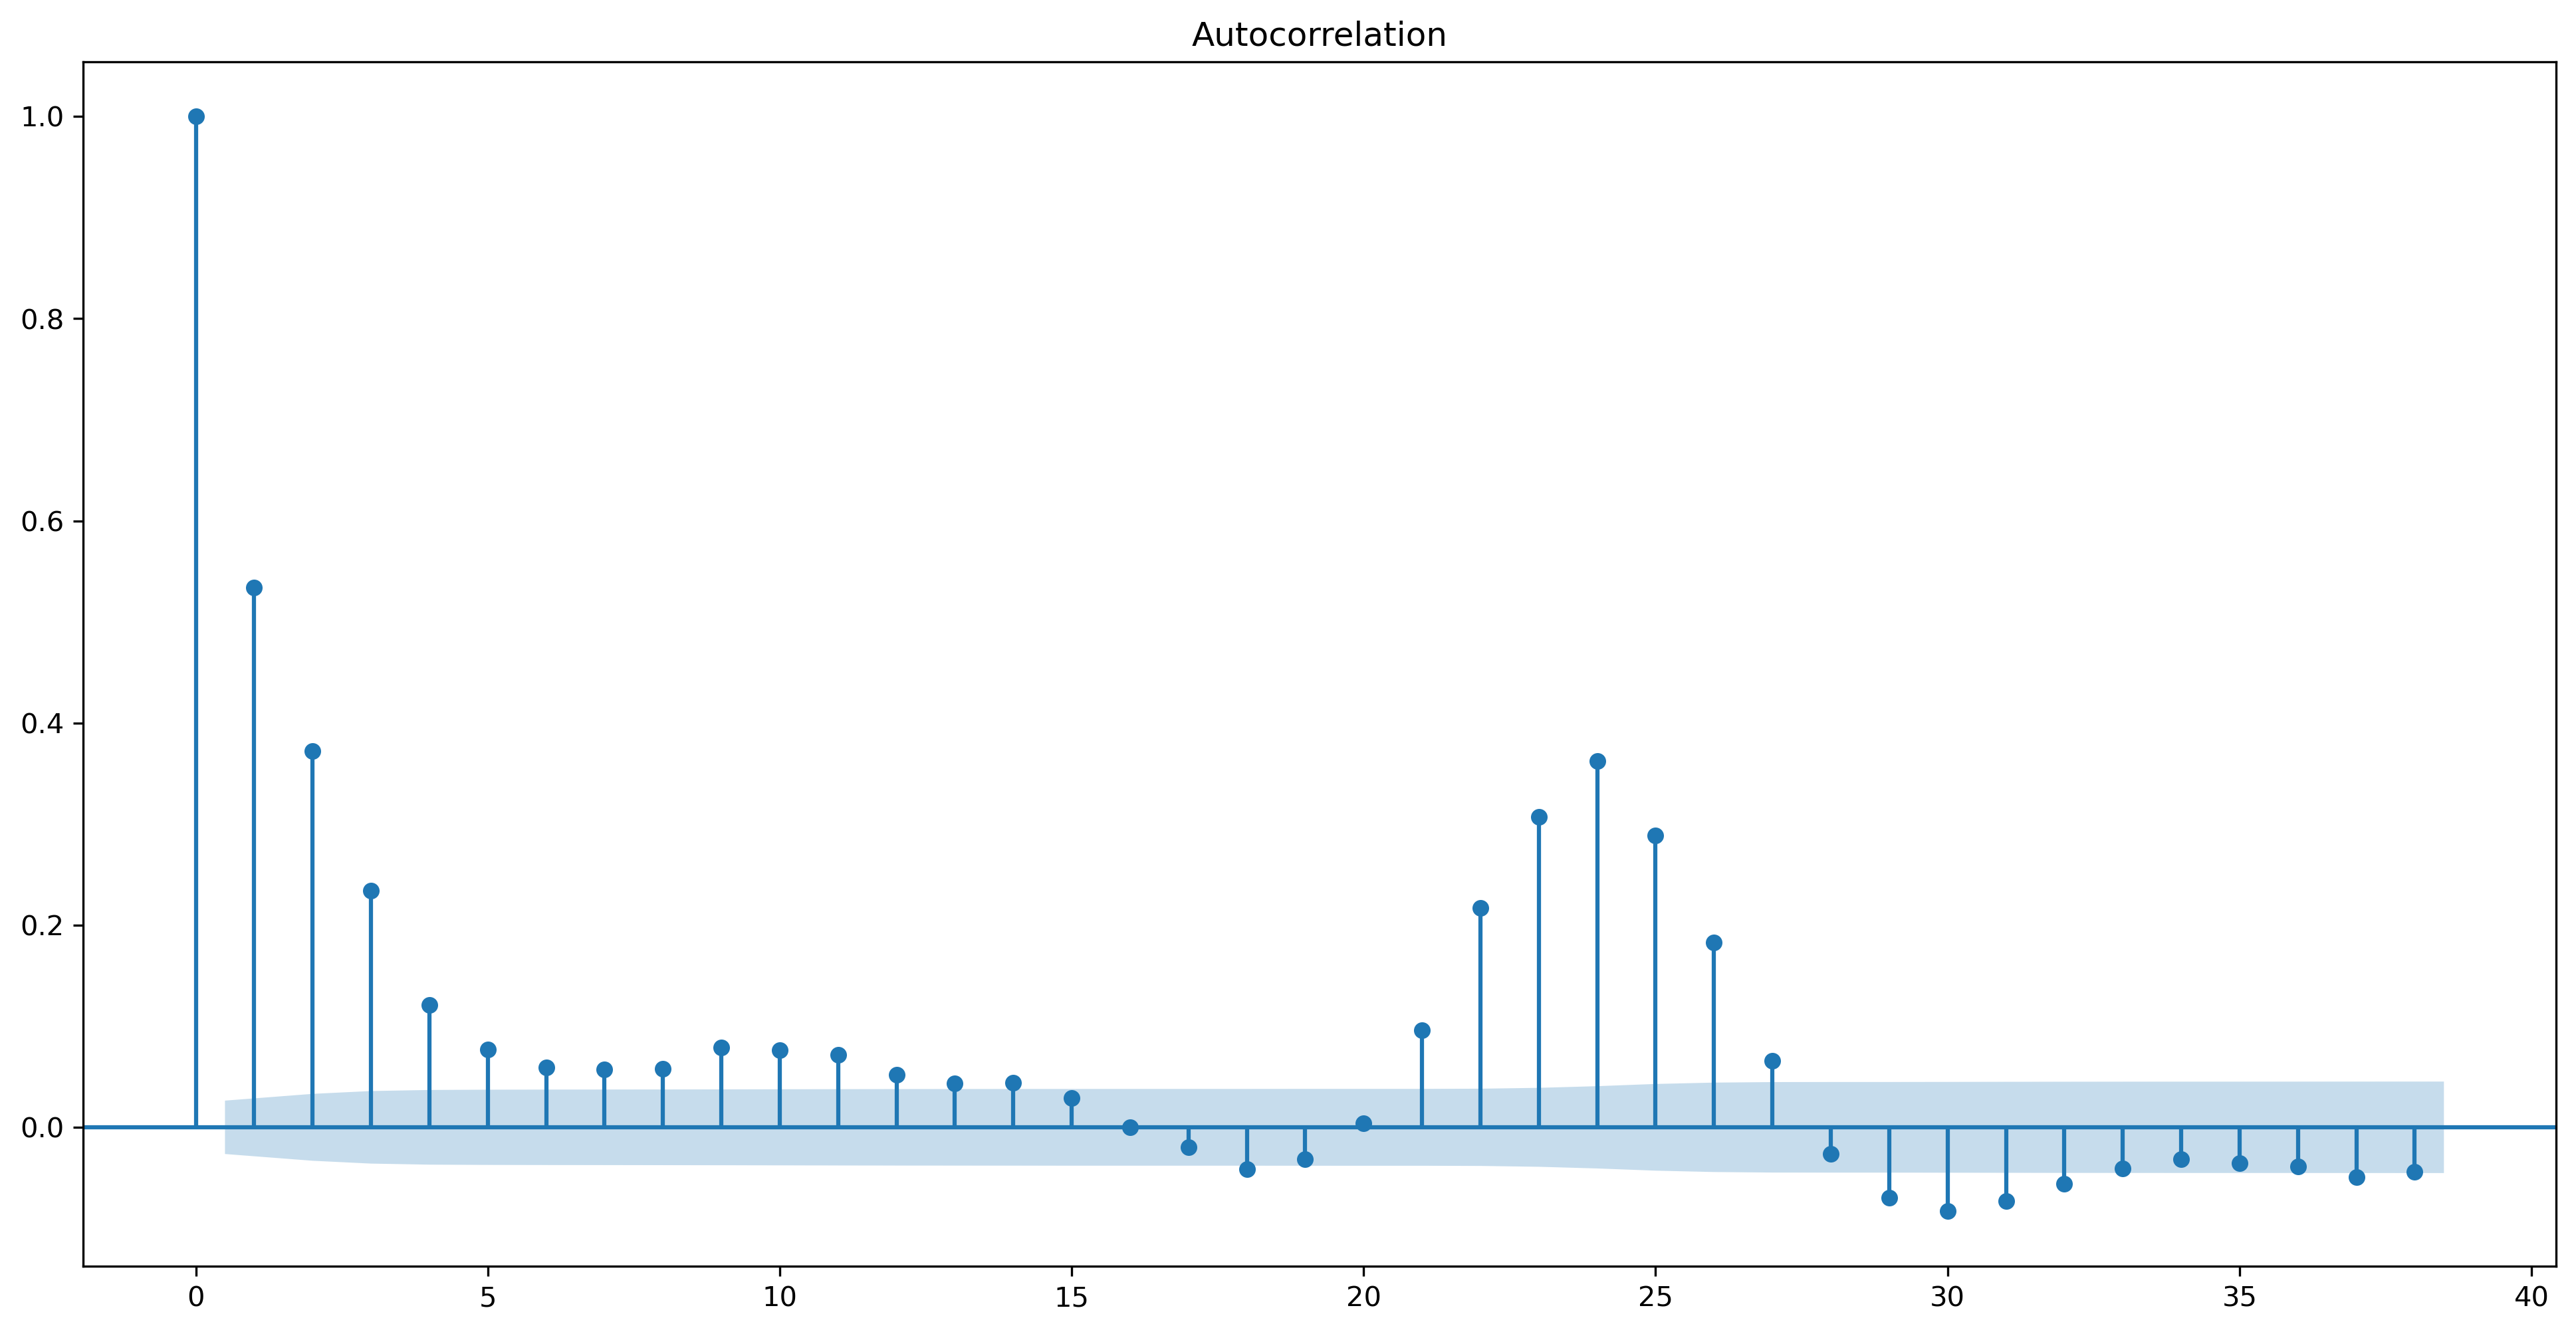

In [2119]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(16,8), dpi= 300)
    plot_acf(df1['pos'])
plt.show()

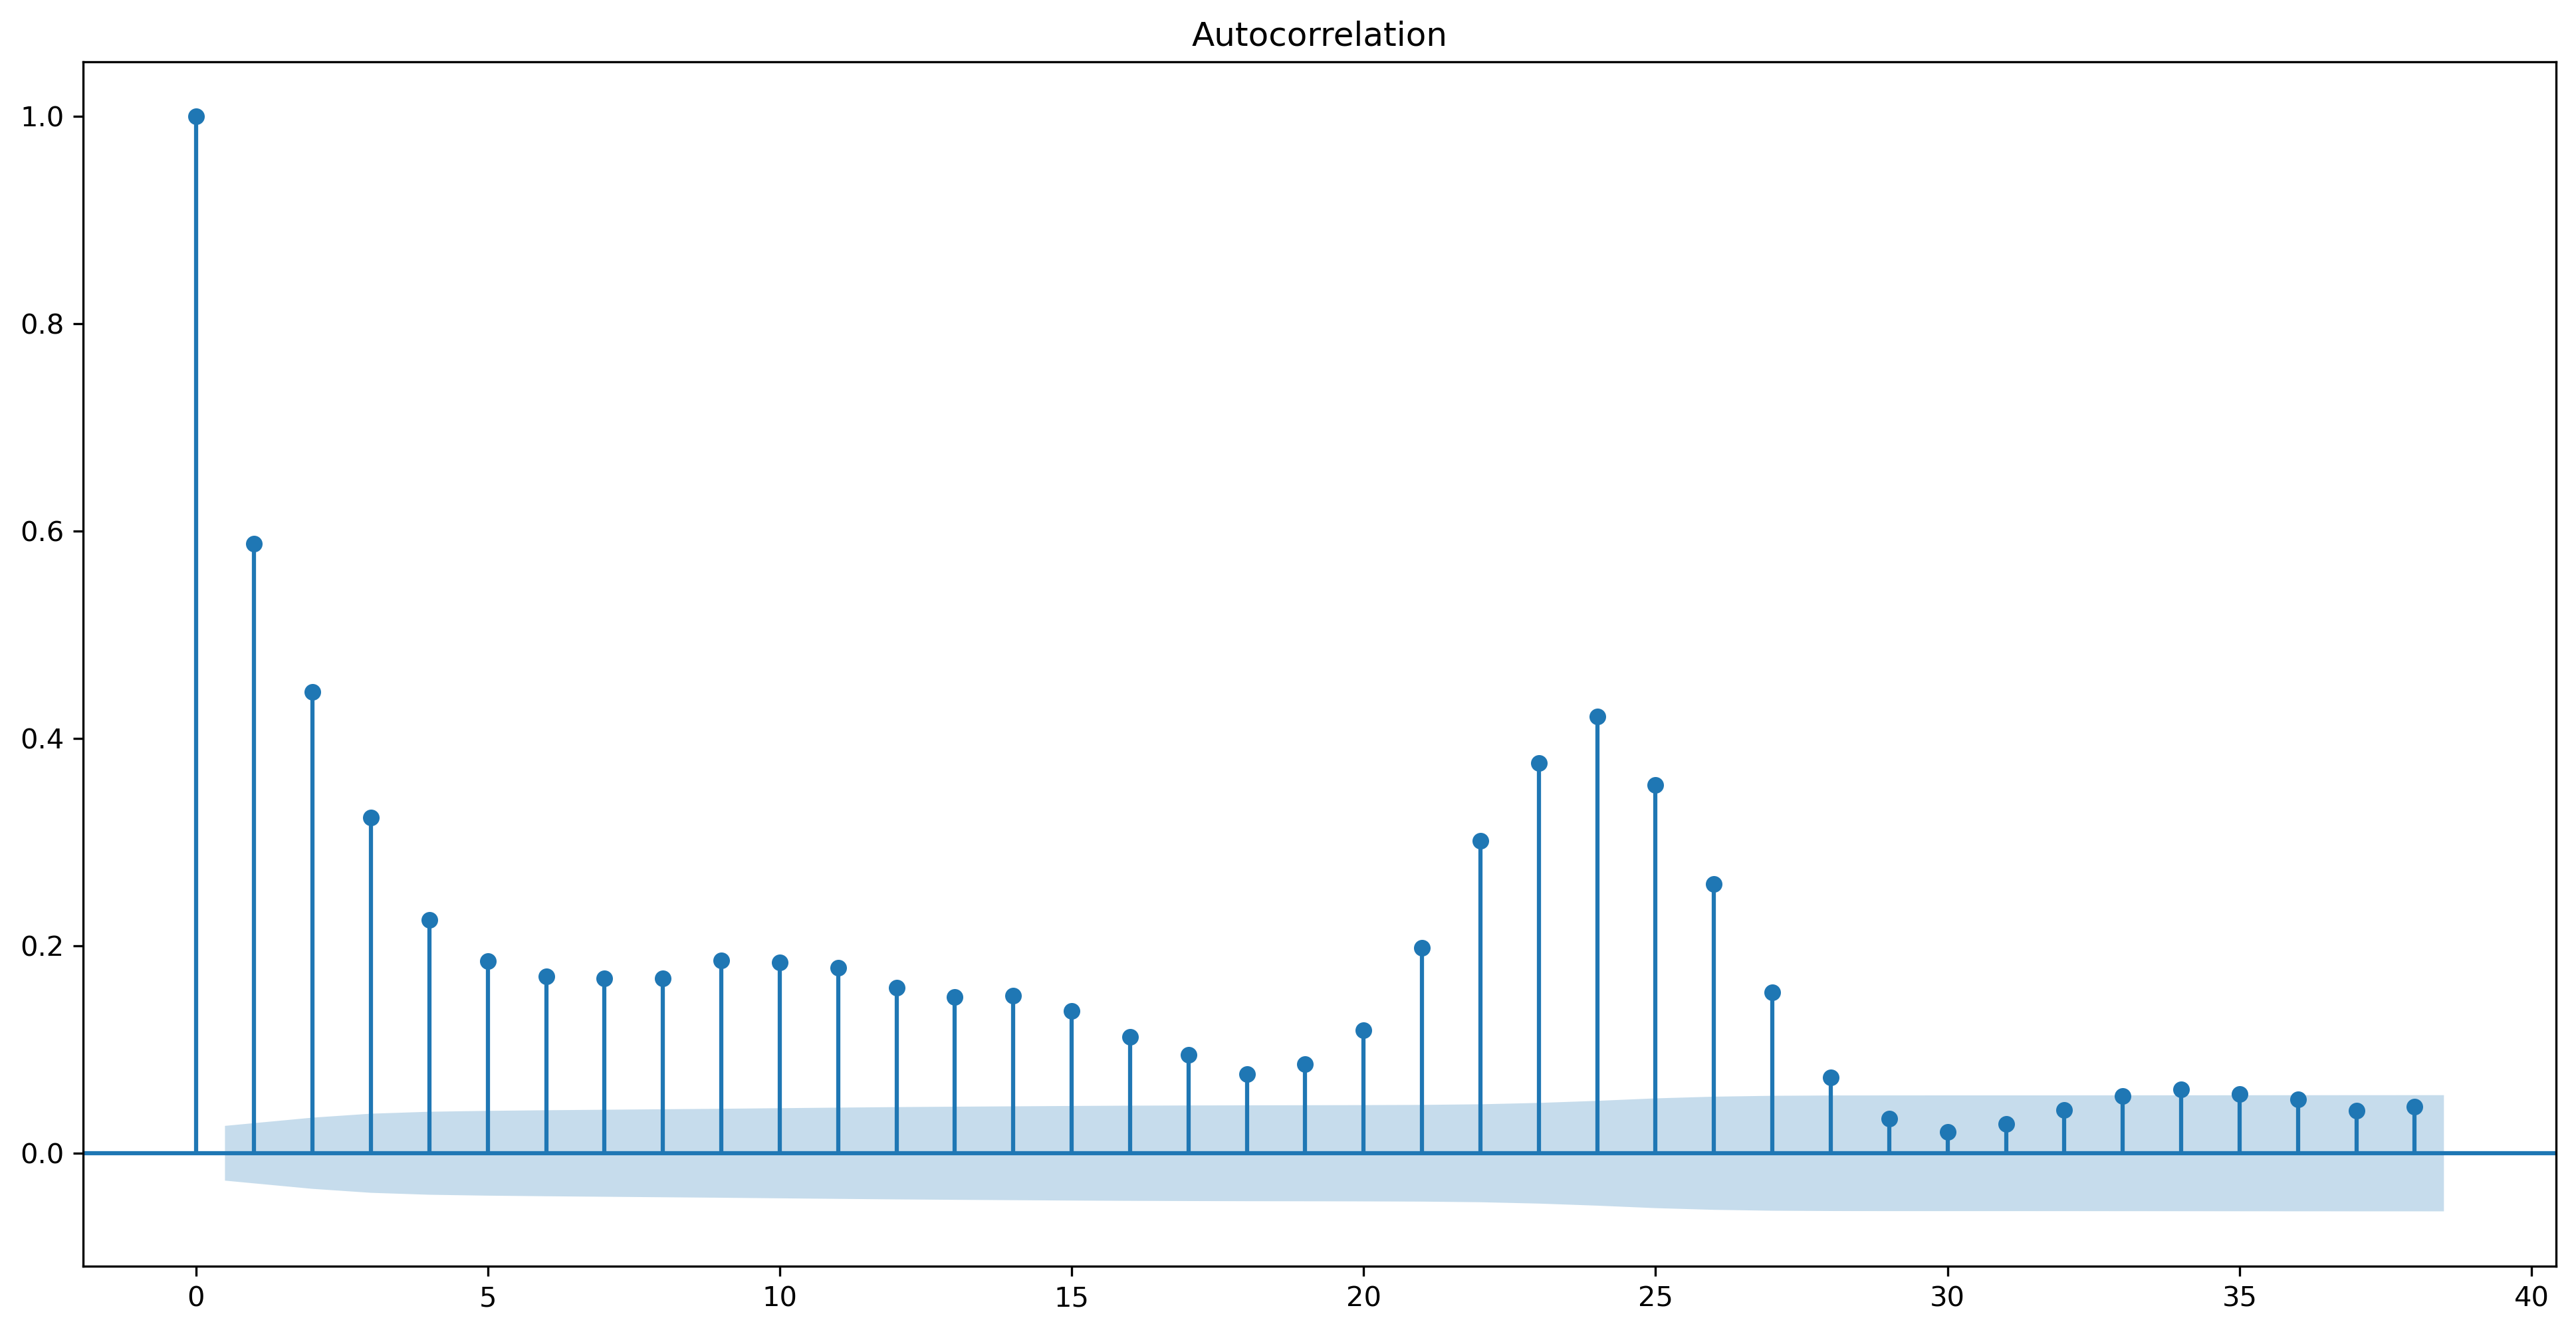

In [2120]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(16,8), dpi= 300)
    plot_acf(df2['pos'])
plt.show()

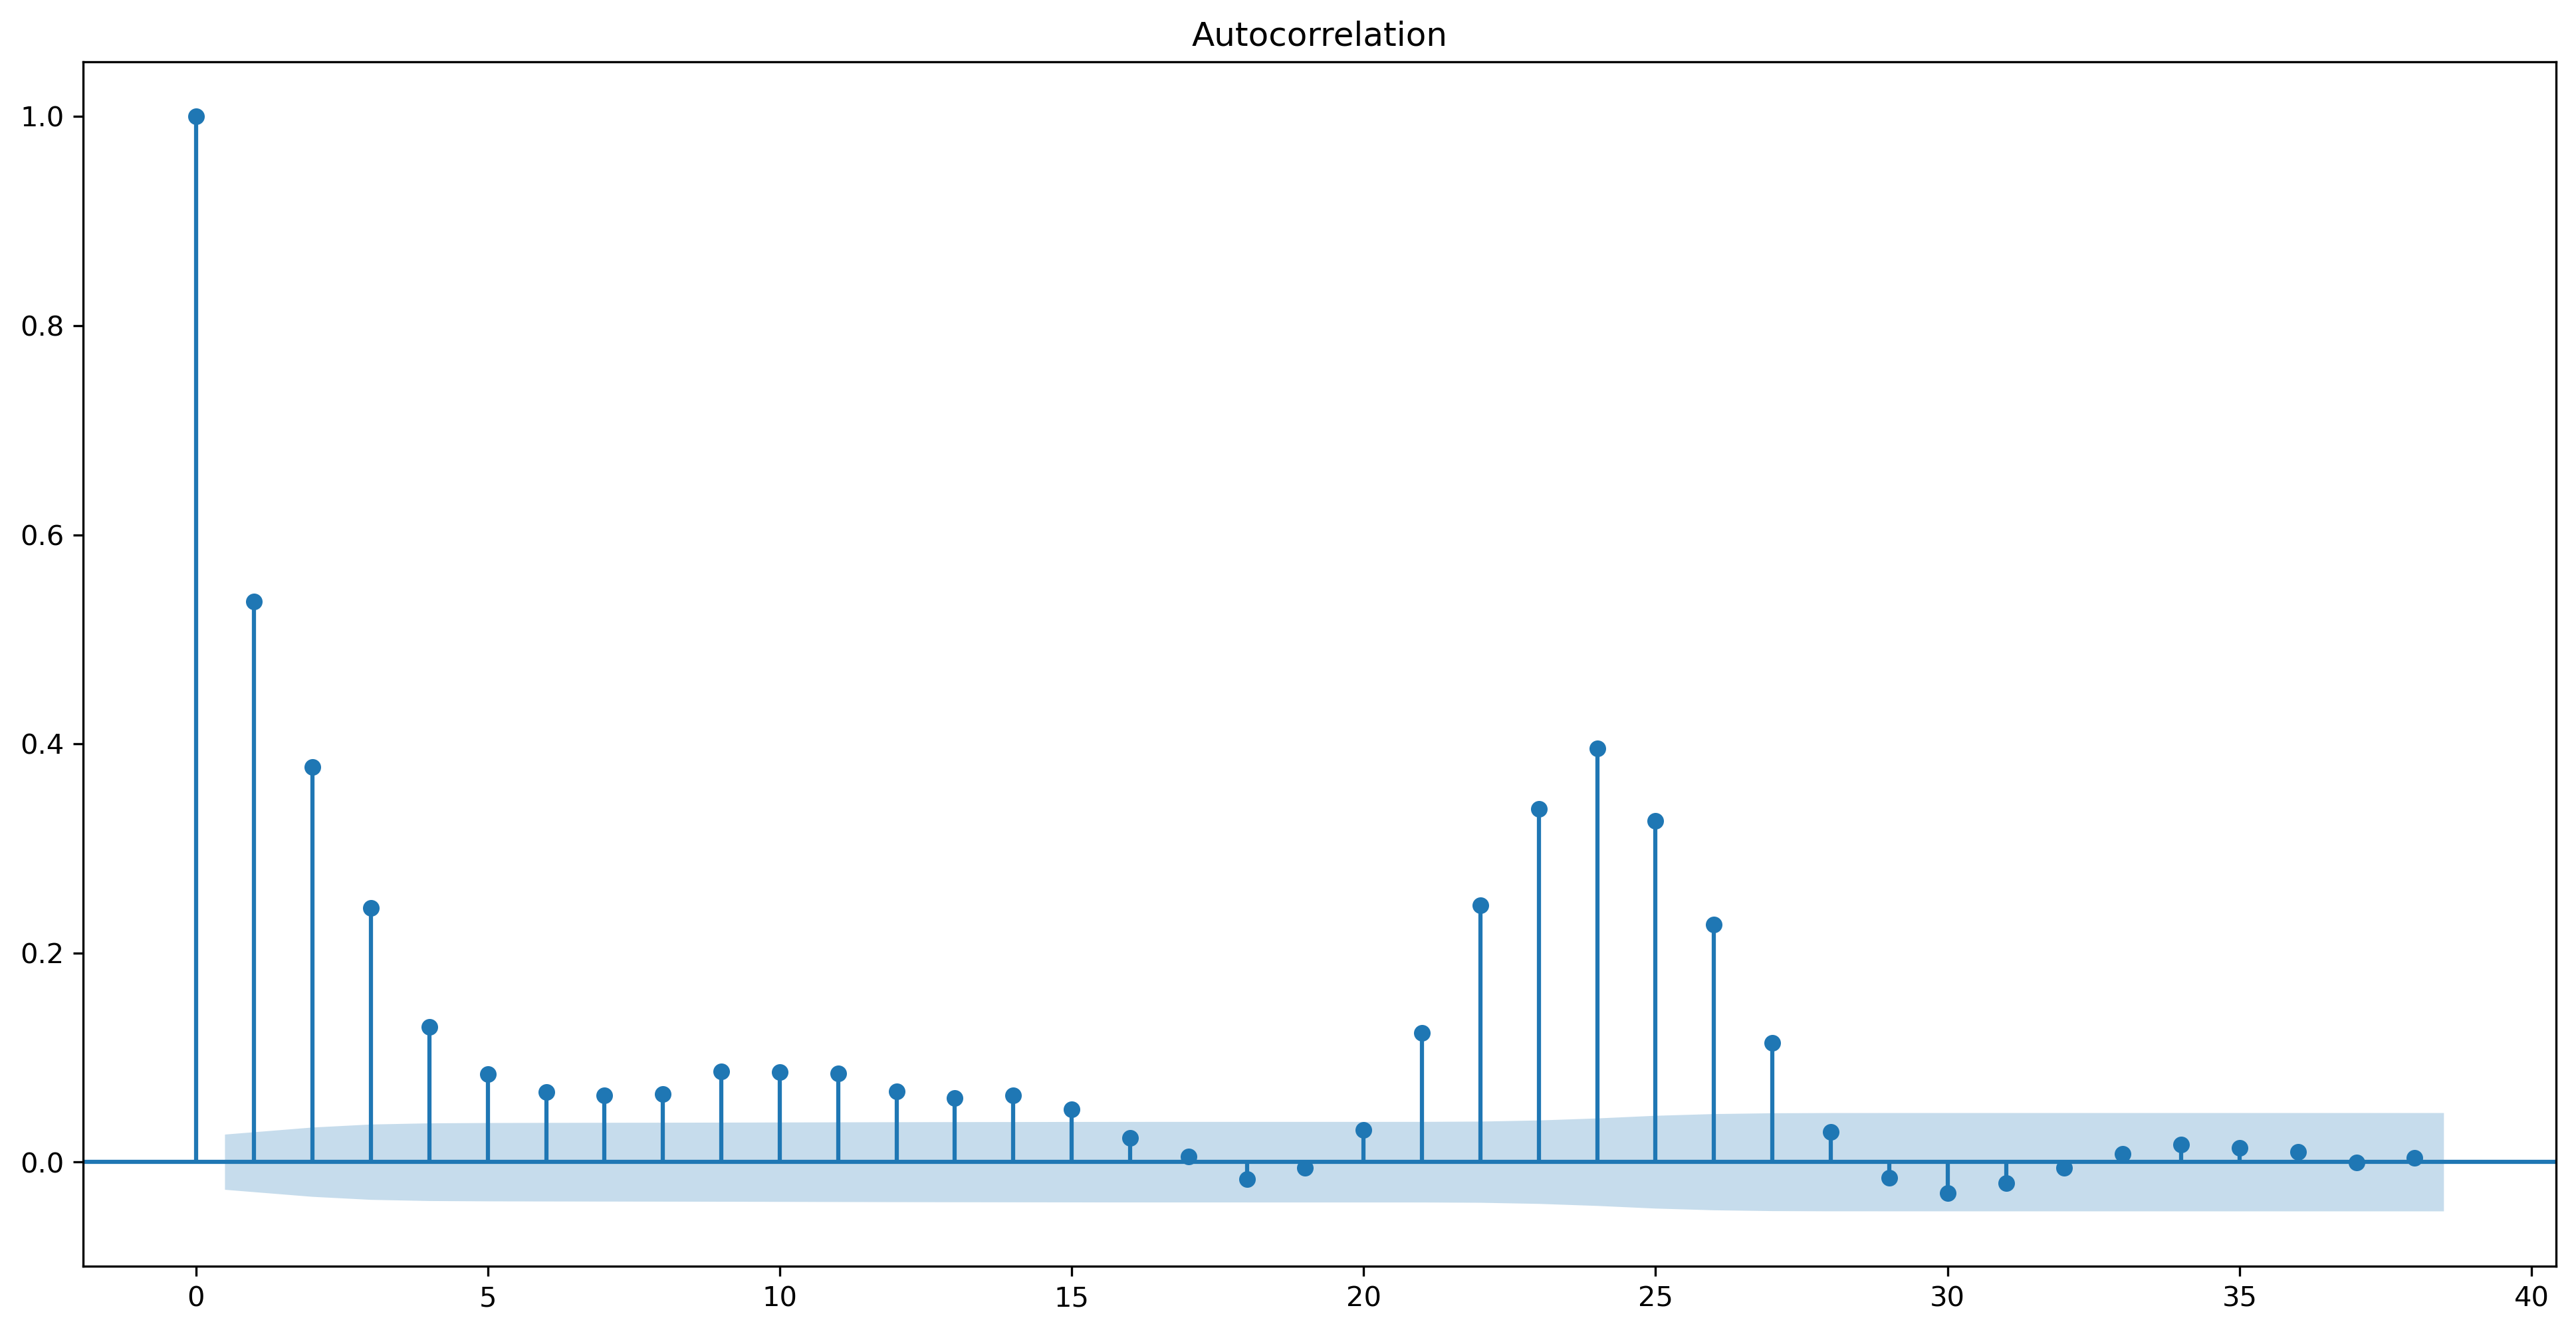

In [2121]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(16,8), dpi= 300)
    plot_acf(df3['pos'])
plt.show()

In [ ]:
plot_pacf(data['positive']) # p

In [ ]:
dataFr.head(10)
year = 2014
month = 5
day = 16
hour = 17
idxIter = 0


for _ in iter(int, 1):
#for l in range(0, len(dataFr)):
    dtStamp = datetime.datetime(year, month, day, hour)
    idx = dataFr.index[idxIter]
    if(dtStamp==idx):
        idxIter = idxIter+1
        print(dtStamp, idx)
    else:
        print(dtStamp, ">>>NO MATCH<<<")
    if(year==2015 and month==1 and day==1 and hour==4):
        break
    hour = hour+1
    if(hour == 24):
        hour = 0
        day = day+1
        if(day == 31 and (month == 6 or month == 9 or month == 11)):
            day = 1
            month = month+1
        elif(day == 32):
            day = 1
            month = month+1
        if(month == 13):
            month = 1
            year = year+1
    
            

In [ ]:
datetime.datetime(2020, 5, 17, 12)>dataFr.index[0]

In [ ]:
prevIdx = ""
curCounter = 0
for i in dataFr.index:
    curIdx = str(i).split()[0]
    #print(curIdx)
    if(curIdx != prevIdx and prevIdx != ""):
        print (prevIdx, "->", curCounter)
        curCounter = 1
        prevIdx = curIdx
    else:
        curCounter = curCounter + 1
        prevIdx = curIdx
        if(i==dataFr.index[len(dataFr)-1]):
            print (prevIdx, "->", curCounter)
            curCounter = 0
            break


    

In [ ]:
# p = 3,4,5,6
# d = 0
# q = 5,6,7

print(len(data))

data_train = data['positive'][0:4500]
data_test = data['positive'][4500:]
print(len(data_train))
print(len(data_test))

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
data_model = ARIMA(data_train, order = (3,0,5))

In [ ]:
data_model_fit = data_model.fit()

In [ ]:
data_model_fit.aic

#### TOPIC

In [ ]:
#Dependencies
import pandas as pd
import gensim #the library for Topic modelling
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models
import pyLDAvis.gensim_models #LDA visualization library

from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.simplefilter('ignore')
from itertools import chain

In [ ]:
from sqlalchemy import create_engine
import pandas as pd





POSTGRES_ADDRESS = 'localhost' ## INSERT YOUR DB ADDRESS IF IT'S NOT ON PANOPLY
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES USERNAME
POSTGRES_PASSWORD = 'qwerty' ## CHANGE THIS TO YOUR PANOPLY/POSTGRES PASSWORD
POSTGRES_DBNAME = 'TwitterProjectV2' ## CHANGE THIS TO YOUR DATABASE NAME
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME,
                        password=POSTGRES_PASSWORD,
                        ipaddress=POSTGRES_ADDRESS,
                        port=POSTGRES_PORT,
                        dbname=POSTGRES_DBNAME))

cnx = create_engine(postgres_str)


query = "SELECT * FROM raw_tweet_il"
df = pd.read_sql_query(query, con=cnx)

In [ ]:
#len(df)
#df.to_csv(index=False)
#df.to_csv('D:/GitHub/CSI703_Spring2022_Samiul/Assignments/Assignment5to100/Data/tweets_il.csv', index=False)

In [ ]:
df_backedup = pd.read_csv('D:/GitHub/CSI703_Spring2022_Samiul/Assignments/Assignment5to100/Data/tweets_il.csv')

In [ ]:
df_backedup.head()

In [ ]:
df.head()

In [ ]:
df.iloc[202]['text']

In [ ]:
len(df)

In [ ]:
#clean the data
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = ' '.join([lemma.lemmatize(word) for word in punc_free.split()])
    return normalized

In [ ]:
df['text_clean']=df['text'].apply(clean)


In [ ]:
df.tail()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate(df.iloc[202]['text'])
plt.imshow(wordcloud, interpolation='bilinear')
#plt.axis("off")
plt.show()

In [ ]:
len(df['text'][:500])
tweets500 = df['text'][20000:1020000].str.cat(sep=' ')
#tweets500

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(width=1920, height=1080, stopwords=['him', 'who\'s', 'himself', 'whom', 'his', 'why', 'how', 'why\'s', 'how\'s', 'with', 'i', 'won\'t', 'i\'d', 'would', 'i\'ll', 'wouldn\'t', 'i\'m', 'you', 'i\'ve', 'you\'d', 'if', 'you\'ll', 'in', 'you\'re', 'into', 'you\'ve', 'is', 'your', 'isn\'t', 'yours', 'it', 'yourself', 'it\'s', 'yourselves', 'its', 'itself', 'let\'s', 'me', 'more', 'most', 'mustn\'t', 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours'
    ,'a', 'ourselves', 'about', 'out', 'above', 'over', 'after', 'own', 'again', 'same', 'against', 'shan\'t', 'all', 'she', 'am', 'she\'d', 'an', 'she\'ll', 'and', 'she\'s', 'any', 'should', 'are', 'shouldn\'t', 'aren\'t', 'so', 'as', 'some', 'at', 'such', 'be', 'than', 'because', 'that', 'been', 'that\'s', 'before', 'the', 'being', 'their', 'below', 'theirs', 'between', 'them', 'both', 'themselves', 'but', 'then', 'by', 'there', 'can\'t', 'there\'s', 'cannot', 'these', 'could', 'they', 'couldn\'t', 'they\'d', 'did', 'they\'ll', 'didn\'t', 'they\'re', 'do', 'they\'ve', 'does', 'this', 'doesn\'t', 'those', 'doing', 'through', 'don\'t', 'to', 'down', 'too', 'during', 'under', 'each', 'until', 'few', 'up', 'for', 'very', 'from', 'was', 'further', 'wasn\'t', 'had', 'we', 'hadn\'t', 'we\'d', 'has', 'we\'ll', 'hasn\'t', 'we\'re', 'have', 'we\'ve', 'haven\'t', 'were', 'having', 'weren\'t', 'he', 'what', 'he\'d', 'what\'s', 'he\'ll', 'when', 'he\'s', 'when\'s', 'her', 'where', 'here', 'where\'s', 'here\'s', 'which', 'hers', 'while', 'herself', 'who'
,'thi', 'gt', 'there', 'so', 'or', 'is', 'that', 'with', 'at', 'on', 'the', 'of', 't', 'in', 'and', 'my', 'but','CO', 'amp', 'http', 'a', 'was', 'I', 'to', 'be', 'fuck', 'nigga', 'shit', 'fucking']).generate(tweets500)
plt.figure(figsize=(12, 9), dpi=1200).patch.set_facecolor('xkcd:white')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Wordcloud of the tweets made from IL during 2014') # Instead of selecting 20 mil tweets,
                                                        # I am using half of those to reduce runtime.
plt.show()

In [ ]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(dataFr['pos'])
#plt.plot(scaling(dataFr['pos']))

In [ ]:
plt.figure(figsize=(16,8), dpi=300)
plt.plot(scaling(dataFr['pos']))

In [ ]:
dataFr['pos'].max()

In [ ]:
scaling(dataFr['pos']).min()